# Recommendation System Deep Learning Research

* Reference Github:
    * https://github.com/wzhe06/SparrowRecSys/tree/master/TFRecModel/src/com/sparrowrecsys/offline/tensorflow
    * https://github.com/ZiyaoGeng/Recommender-System-with-TF2.0
    
    
* Content
    * Explore the data quality and preprocessing
    * Data Visualization
    * Model Establishment and Test
    * Real life recommendation movies that were not seen by user
    * Summary

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import pydot

# Import data set:
  * df_movie: contains the movie categories and types
  * df_user: contains user basic features
  * df_rating: contains the rate (1~5)that one user made to one moive

In [2]:
df_movie=pd.read_csv(r"D:\CS\NTU\DeepLearning\project\ml-100k\movie.csv",encoding = 'gb18030')
df_user=pd.read_csv(r"D:\CS\NTU\DeepLearning\project\ml-100k\user.csv")
df_rating=pd.read_csv(r"D:\CS\NTU\DeepLearning\project\ml-100k\rating.csv")

# Explore the data quality and preprocessing

The key point of recommendation deep learning model is to dig the user behaviours, product features based on the dataset.

In [841]:
#check the composition of files and their size
print(df_movie.shape)
print(df_user.shape)
print(df_rating.shape)


(1682, 24)
(943, 5)
(100000, 4)


* check whether there is null value


In [842]:
df_rating.isnull().sum() ##rating file doesnt have null value 

user id       0
 item id      0
 rating       0
 timestamp    0
dtype: int64

In [843]:
df_user.isnull().sum() ##user file doesnt have null value 

user id         0
 age            0
 gender         0
 occupation     0
 zip code       0
dtype: int64

In [844]:
df_movie.isnull().sum() ## movie file has null value in three columns

movie id                   0
 movie title               0
 release date              1
 video release date     1682
 IMDb URL                  3
 unknown                   0
 Action                    0
 Adventure                 0
 Animation                 0
Children's                 0
 Comedy                    0
 Crime                     0
 Documentary               0
 Drama                     0
 Fantasy                   0
Film-Noir                  0
 Horror                    0
 Musical                   0
 Mystery                   0
 Romance                   0
 Sci-Fi                    0
Thriller                   0
 War                       0
 Western                   0
dtype: int64

Text(0, 0.5, 'null count')

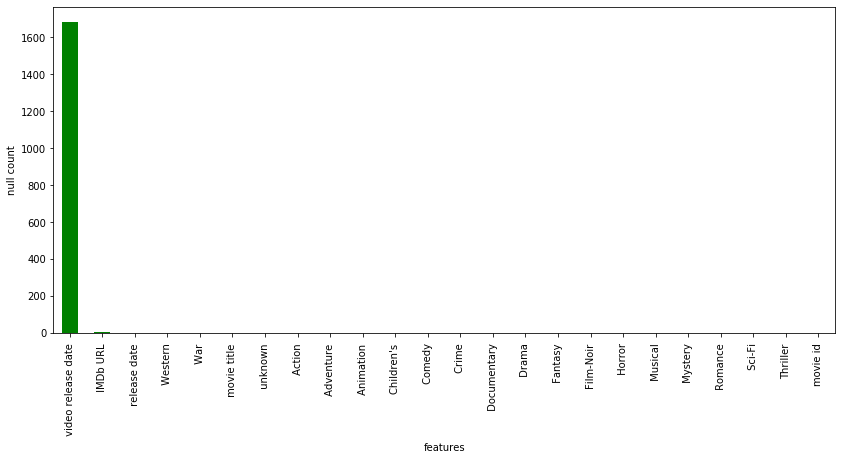

In [845]:
# null number visualization
null_value=(df_movie.isnull().sum()).sort_values(ascending=False)
null_value.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("features")
plt.ylabel("null count")

* It seems that "release date","video release date","IMDb URL" has null value. Considering the data we need, we could just drop the "IMDb URL", and the shape of movie dataset is 1682, which means "video release date" is all missed for every data, so this feature can also be eliminated. So we only need to fill the data in "release date"
* the columns contains a lot of space, we also need to eliminate them

In [846]:
def get_column_no_space(data):
    columns=[]
    for column in data.columns:
        columns.append(column.strip())
    return columns

In [847]:
#eliminate the space
df_movie.columns=get_column_no_space(df_movie)
df_user.columns=get_column_no_space(df_user)
df_rating.columns=get_column_no_space(df_rating)

In [848]:
df_rating

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [19]:
# drop the IMDb URL and video released date
movie=df_movie.drop(["IMDb URL","video release date"],axis=1)
movie

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1-Jan-95,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1-Jan-95,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1-Jan-95,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1-Jan-95,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1-Jan-95,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),6-Feb-98,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),6-Feb-98,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),1-Jan-98,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),1-Jan-94,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Then we need to find the NaN value in "release data"

In [ ]:
# find the null value in "release date"
movie[movie["release date"].isnull()]

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_rating[df_rating["item id"]==267] ## find the rating record of this movie

,user id,item id,rating,timestamp
2172,130,267,5,875801239
3781,5,267,4,875635064
7245,268,267,3,875742077
12475,297,267,3,875409139
14756,319,267,4,875707690
15292,1,267,4,875692955
49295,532,267,3,875441348
93523,833,267,1,875655669
99723,422,267,4,875655986



The NO.267 Movie is a mystery with unknown movie title and missing release date, while some people seems really like it, so we will not delete it and could add a mean date to this table.To do this ,we need first check the dtype of all the features

* check the data type

In [ ]:
movie.dtypes

movie id         int64
movie title     object
release date    object
unknown          int64
Action           int64
Adventure        int64
Animation        int64
Children's       int64
Comedy           int64
Crime            int64
Documentary      int64
Drama            int64
Fantasy          int64
Film-Noir        int64
Horror           int64
Musical          int64
Mystery          int64
Romance          int64
Sci-Fi           int64
Thriller         int64
War              int64
Western          int64
dtype: object

In [ ]:
df_user.dtypes

user id        int64
age            int64
gender        object
occupation    object
zip code      object
dtype: object

In [ ]:
df_rating.dtypes

user id      int64
item id      int64
rating       int64
timestamp    int64
dtype: object

* it seems the "release date" didn't have the proper type. What's more, we don't need the specific date and only year is enough. we change it to be an int64 with only years.

In [ ]:
#split the "release date" to three columns 
movie[["day","month","year"]]=movie.drop(266,axis=0)["release date"].str.split("-",expand=True)

In [ ]:
# and only year column is what we need
movie=movie.drop(["day","month","release date"],axis=1)

In [ ]:
# fill the null value of no.267 movie with a mean year 
year=list(movie.drop(266,axis=0)["year"].astype("int64"))
year_266=round(np.mean(year))

year.insert(266,year_266)

#the year is only contians the last two digits, then we fix it into the standard way.
movie["year"]=year
movie["year"]=movie["year"]+1900

In [ ]:
# show the year of these movie
np.sort(movie["year"].unique())

array([1922, 1926, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998])

* we could see the moive is from 1992 to 1998, this data set is actually very old

## DIG the total movie(products) features from rating file
* add the number of users who rated this movie,show how popular this movie is.
* add the average rating of this movie, show how good this movie is.
* add the standard deviation of this movie, show how controversial this movie is.

In [ ]:
#change the name of title
rating=df_rating
rating=rating.rename({"item id":"movie id"},axis=1)
rating

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
#count number of users who rated this movie
count=rating.groupby("movie id").count().iloc[:,0]

#average rating of this movie,
mean_value=rating.groupby("movie id")["rating"].mean()

#standard deviation of this movie
std_value=rating.groupby("movie id")["rating"].std()

In [ ]:
#add to the movie dataset
movie=pd.merge(movie,mean_value,on="movie id")
movie=pd.merge(movie,std_value,on="movie id")
movie=pd.merge(movie,count,on="movie id")

In [ ]:
movie=movie.rename({"rating_x":"movieMeanRating","rating_y":"movieStd","user id":"ratingCount"},axis=1)

* notice when the situation that only one user rated a movie, the std whould be zero.So we need to fill the null to 0

In [ ]:
movie["movieStd"]=movie["movieStd"].fillna(0)

In [ ]:
movie.isnull().sum()

movie id           0
movie title        0
unknown            0
Action             0
Adventure          0
Animation          0
Children's         0
Comedy             0
Crime              0
Documentary        0
Drama              0
Fantasy            0
Film-Noir          0
Horror             0
Musical            0
Mystery            0
Romance            0
Sci-Fi             0
Thriller           0
War                0
Western            0
year               0
movieMeanRating    0
movieStd           0
ratingCount        0
dtype: int64

Now let's see what the movie with all the features looks like

In [ ]:
movie

,movie id,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,movieMeanRating,movieStd,ratingCount
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,3.878319,0.927897,452
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,3.206107,0.966497,131
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,3.033333,1.212760,90
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,3.550239,0.965069,209
4,5,Copycat (1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995,3.302326,0.946446,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1998,1.000000,0.000000,1
1678,1679,B. Monkey (1998),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1998,3.000000,0.000000,1
1679,1680,Sliding Doors (1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1998,2.000000,0.000000,1
1680,1681,You So Crazy (1994),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1994,3.000000,0.000000,1


* we could see that the movie type is classified by the genres, but we want  to make these more dense, and the one hot progress will be done in tensorflow.feature_selection.
* in some recommendation model, it does not work if the one hot vector shows in the file above, it must become a one-hot vector groups.
  * for example:For NO.1 movie "Toy story":
    * [0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0] 
    * should be a group of belows:
    * [[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    * [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    * [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]]
* so in this case, we wiil flatten this into several columns named "movieGenre1" to "movieGenreN"

In [ ]:
movie_types=["unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir",
             "Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]

In [ ]:
# add the movie genres to new columns.
res_genres=[]
all_genres=movie.iloc[:,2:21] # movie genre
for i in range(movie.shape[0]):
    one_genres=[]
    for j in range(all_genres.shape[1]):
        if all_genres.iloc[i][j]==1:
            one_genres.append(movie_types[j])
    res_genres.append(one_genres)
movie["all_genres"]=res_genres

In [ ]:
max_length_genres=0
for i in res_genres:
    #calculate the maximum length of the genre types of one specific movie
    max_length_genres=max(max_length_genres,len(i))

#then we add the corresponding genres to the movieGenre
#if one moive's genre is less than max length genres, then we will fill string 0 to the following genres.
for i in range(max_length_genres):
    genre=[]
    for genres in movie["all_genres"]:
        if i<len(genres):
            genre.append(genres[i])
        else:
            genre.append("0")
    movie["movieGenre"+str(i+1)]=genre

In [ ]:
# we now could drop the columns of movie_types and all_genres to finish our movie feature engineering
movie_finished=movie.drop(movie_types,axis=1)
movie_finished=movie_finished.drop("all_genres",axis=1)

* finished dig about the features of movies and output to the google drive for further use

In [ ]:
#finished dig about the features of movies and output to the google drive for further use
movie_finished.to_csv("/content/drive/MyDrive/BS6204_Project/movie_features.csv",index=False)
movie_finished

,movie id,movie title,year,movieMeanRating,movieStd,ratingCount,movieGenre1,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6
0,1,Toy Story (1995),1995,3.878319,0.927897,452,Animation,Children's,Comedy,0,0,0
1,2,GoldenEye (1995),1995,3.206107,0.966497,131,Action,Adventure,Thriller,0,0,0
2,3,Four Rooms (1995),1995,3.033333,1.212760,90,Thriller,0,0,0,0,0
3,4,Get Shorty (1995),1995,3.550239,0.965069,209,Action,Comedy,Drama,0,0,0
4,5,Copycat (1995),1995,3.302326,0.946446,86,Crime,Drama,Thriller,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998,1.000000,0.000000,1,Drama,0,0,0,0,0
1678,1679,B. Monkey (1998),1998,3.000000,0.000000,1,Romance,Thriller,0,0,0,0
1679,1680,Sliding Doors (1998),1998,2.000000,0.000000,1,Drama,Romance,0,0,0,0
1680,1681,You So Crazy (1994),1994,3.000000,0.000000,1,Comedy,0,0,0,0,0


we could see that the max length of movie features are 6, and many movies do not have such long genres
* **From now, we finish the data cleaning and feature Engneering about the movie dataset.**
* Next, we will do the **user behaviour** digging

## DIG the total user features from rating and movie file
* add the number of movies that this user rates,show that how often and likely this user want to rate a movie.
* add the average rating of this user, show the baseline of this user rates.
* add the standard deviation of this user, show whether this user is critical or just be nice to every product.
* add the top 5 movie types this user probabily like.
* add the top 5 movie IDs that the user best like
* add the aevrage release year of good movies that user likes
* add the standard deviation of year of good movies that user likes

**it is differenct with movie**, user will rate the movie **in different time**. we need to calculate the mean and deviation of values **before** the time when user rates a new released movie. So we will allocate all the history values we need to list and then use the list to calculate statistical values like mean and diviation



In [ ]:
df_rating["timestamp"]

0        881250949
1        891717742
2        878887116
3        880606923
4        886397596
           ...    
99995    880175444
99996    879795543
99997    874795795
99998    882399156
99999    879959583
Name: timestamp, Length: 100000, dtype: int64

we could see that the timestamp is not human readable, then we need to change it to the year-month-day type

In [ ]:
import time
# define the function to change the time into standard type
def stamp_to_time(time_stamp):
    timeArray=time.localtime(time_stamp)
    return time.strftime("%Y-%m-%d %H:%M:%S",timeArray)

In [ ]:
rating["time"]=rating["timestamp"].apply(stamp_to_time)

In [ ]:
rating

,user id,movie id,rating,timestamp,time
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16
...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22 05:10:44
99996,716,204,5,879795543,1997-11-17 19:39:03
99997,276,1090,1,874795795,1997-09-20 22:49:55
99998,13,225,2,882399156,1997-12-17 22:52:36


Now we see the readable time when one user saw a movie and rated it, and next we could sort based on this "time" columns ,and allocate their history rating behaviours

In [ ]:
import copy
import collections
# # this function is to allocate 
#       * the history rating of this user
#       * history movie id list that user already seen
#       * top5 movies user liked best
#               before the time he rates a new movie
def get_user_history(rating):
    rating=rating.sort_values(by="time")
    li=list(rating.groupby(by="user id"))
    #allocate all the history to "histories",the final shape of histories will be identical to rating,which is 10000 length
    #initialize the histories dataframe
    histories=pd.DataFrame(np.zeros((0,8)))
    columns=[]
    for column in rating.columns:
        columns.append(column)
    columns.append("history_rating")
    columns.append("user_think_good_movie_id")
    columns.append("top5_liked_movies")
    
    ## the framework of all the human behaviours
    histories.columns=columns
    
    #loop the list baesd on the user ID
    for user in li:
        
        # get this users all behavioures as df
        df=user[1]
        
        # histoty of rating,     type：list(list())
        res_rate=[]
        #history of movie id,    type:list(list())
        res_movie_id=[]
        #top 5 like movies
        res_top_5_like_movie=[]

        # history of current rating,   type:list()
        his_rate=[]
        
        # history of  movie ids when user think good (rating>3.5),   type:list()
        user_think_good_movie_id=[]
        #list of top 5 like movies
        movie_id_top5_like=collections.deque()

        user_rating=np.array(df["rating"])
        user_rating_movie=np.array(df["movie id"])
        time_list=list(df["time"])

        # treversal all the rating record of this user
        for i in range(df.shape[0]):
            if i==0:
                count=i
                interval=0
            else:
                #only the time is bigger than the previous record time, then the history will be add.
                if time_list[i]>time_list[i-1]:
                    for j in range(interval+1):
                        his_rate.append(user_rating[count+j])

                        #add to the list when the user think this movie is good(rating>3.5)
                        if user_rating[count+j]>3.5:
                            user_think_good_movie_id.append(user_rating_movie[count+j])

                            # update the top5 liked movie based on user rating, if all the ratings in this file are 5 and the
                            # size of this top 5 liked movie is already 5 ,then we wiil
                            # eliminate the oldest one and add the latest one into the tail of the deque
                            if len(movie_id_top5_like)==0:
                                movie_id_top5_like.append(user_rating_movie[count+j])
                            else:
                                right=movie_id_top5_like.pop()
                                if len(movie_id_top5_like)==4 and user_rating[list(user_rating_movie).index(right)]==5:
                                    # indicate the deque is full, only check whether we need to update the latest to list
                                    if user_rating[count+j]==5:#update
                                        movie_id_top5_like.popleft()
                                        movie_id_top5_like.append(right)
                                        movie_id_top5_like.append(user_rating_movie[count+j])
                                    else:# the latest movie is not good enough to join the top 5 liked movies
                                        # then we add the old one that we poped 
                                        movie_id_top5_like.append(right)
                                else:
                                    #in this condition,deque is not full with 5 length.
                                    movie_id_top5_like.append(right)
                                    # first check the head of the deque, if current movie rating is larger than the previous one,
                                    # add it to the head directly
                                    left=movie_id_top5_like.popleft()
                                    if user_rating[count+j]>user_rating[list(user_rating_movie).index(left)]:
                                        movie_id_top5_like.appendleft(left)
                                        movie_id_top5_like.appendleft(user_rating_movie[count+j])
                                    else:
                                        movie_id_top5_like.appendleft(left)

                                        q=collections.deque()
                                        # if the rating is not larger than the previous one,
                                        # then check whether the rating of this movie is larger than tail
                                        # if rating is larger than tail, keep pop things out to a new queue until the deque is empty 
                                        # or the rating is smaller than the tail, and add the current one to the tail,
                                        # add the movies in new queue back to tail. 
                                        while len(movie_id_top5_like)>0:
                                            right=movie_id_top5_like.pop()
                                            q.append(right)
                                            if user_rating[count+j]<=user_rating[list(user_rating_movie).index(right)]:
                                                break
                                        movie_id_top5_like.append(q.pop())
                                        movie_id_top5_like.append(user_rating_movie[count+j])
                                        while len(movie_id_top5_like)<5 and len(q)>0:
                                            movie_id_top5_like.append(q.pop())

                                #adjust the size of movie_id_top5_like to be 5.
                                while len(movie_id_top5_like)>5:
                                    movie_id_top5_like.pop()
                    count=i
                    interval=0
                else:
                    interval+=1
            #then we get the deep copy of the information we get above to the list that we will add to the DataFrame
            res_rate.append(copy.deepcopy(his_rate))
            res_movie_id.append(copy.deepcopy(user_think_good_movie_id))
            res_top_5_like_movie.append(copy.deepcopy(list(movie_id_top5_like)))
        ## add to the value to the specific user's columns
        df["history_rating"]=res_rate
        df["user_think_good_movie_id"]=res_movie_id
        df["top5_liked_movies"]=res_top_5_like_movie

        #update the histories
        histories=pd.concat([histories,df],axis=0)
    return histories

#### this "get_user_history" function above is to allocate 
  * the history rating of this user
  * history movie id list that user already saw and thought the movies were good(they rated >3.5 for this movie id)
  * top5 movies user liked best. if all the top 5 movies are all rated 5 by movie, and the newest movie id also was rated by 5, then the oldest movie will be deleted, the newest 5 rated movie will be added into this top 5 movie list(Like LRU)
* **before the time** when he rates this new movie

In [ ]:
# we call the function above and get all the user behaviours
histories=get_user_history(rating)

In [ ]:
#merge the rating with the histories
samples=pd.merge(rating,histories.drop(["rating","timestamp","time"],axis=1),on=["user id","movie id"])

In [ ]:
samples.sort_values(by=["user id","time"])

,user id,movie id,rating,timestamp,time,history_rating,user_think_good_movie_id,top5_liked_movies
59972,1,168,5,874965478,1997-09-22 21:57:58,[],[],[]
92487,1,172,5,874965478,1997-09-22 21:57:58,[],[],[]
74577,1,165,5,874965518,1997-09-22 21:58:38,"[5, 5]","[168, 172]","[168, 172]"
48214,1,156,4,874965556,1997-09-22 21:59:16,"[5, 5, 5]","[168, 172, 165]","[168, 172, 165]"
15764,1,196,5,874965677,1997-09-22 22:01:17,"[5, 5, 5, 4]","[168, 172, 165, 156]","[168, 172, 165, 156]"
...,...,...,...,...,...,...,...,...
93377,943,449,1,888693158,1998-02-28 19:12:38,"[5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...","[64, 181, 28, 174, 100, 127, 508, 763, 50, 475...","[92, 721, 239, 2, 672]"
94914,943,229,2,888693158,1998-02-28 19:12:38,"[5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...","[64, 181, 28, 174, 100, 127, 508, 763, 50, 475...","[92, 721, 239, 2, 672]"
95003,943,230,1,888693158,1998-02-28 19:12:38,"[5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...","[64, 181, 28, 174, 100, 127, 508, 763, 50, 475...","[92, 721, 239, 2, 672]"
95291,943,228,3,888693158,1998-02-28 19:12:38,"[5, 4, 4, 4, 5, 2, 5, 5, 4, 4, 2, 5, 4, 3, 3, ...","[64, 181, 28, 174, 100, 127, 508, 763, 50, 475...","[92, 721, 239, 2, 672]"


from above we could see that based on the user id , and we add all the behaviours to the corresponding place, the first two rows contains null list in "history_rating","user_think_good_movie_id","top5_liked_movies", because they are the first two rating that user id 1 rated, so there is no any history for these rows for user id 1. 
#### Then we can dig our finall user behaviurs by calling the methods below 

In [ ]:
## get the mean history rating value of 
def Mean(self):
    if len(self)==0:
        return 0
    else:
        return np.mean(self)

## get the standard deviation of history rating values
def Std(self):
    if len(self)==0:
        return 0
    else:
        return 0 if len(self)==1 else np.std(self,ddof=1)

## get top 5 movie genres of this user like based on "top5_liked_movies" on the DataFrame "samples"
def top5_movie_grenres(samples):
    def sort_by_value(d): 
        items=d.items() 
        backitems=[[v[1],v[0]] for v in items] 
        backitems.sort() 
        return [ backitems[i][1] for i in range(0,len(backitems)) if i<5]
    top5_movie_id_list=list(samples.top5_liked_movies)
    top5_movie_genres_like_list=[]
    for movie_list in top5_movie_id_list:
        top_5_movie_genres_like=[]
        if len(movie_list)==0:
            top_5_movie_genres_like.append("0")
        else:
            ## get the movie genres of this top 5 movie list
            ## dict key is movie genres, dict value is the count
            top_5_dict=dict()
            for movie_ in movie_list:
                movie_feature=movie[movie["movie id"]==movie_]
                for genre in movie_feature["all_genres"].iloc[0]:
                    if top_5_dict.__contains__(genre):
                        top_5_dict[genre]=top_5_dict[genre]+1
                    else:
                        top_5_dict[genre]=1

            #sort the dict based on the count value,and only get top 5 of the genres
            top_list=sort_by_value(top_5_dict)
            top_5_movie_genres_like=top_list
        top5_movie_genres_like_list.append(top_5_movie_genres_like)
    return top5_movie_genres_like_list

#get the mean and std value of years of movies that user thinks good
def mean_and_Std_ReleaseYear(samples):
    good_movie_id=list(samples.user_think_good_movie_id)
    aveYear=[]
    stdYear=[]

    for movie_id_list in good_movie_id:
        year=[]
        if len(movie_id_list)!=0:
            for movie_id in movie_id_list:
                year.append(movie[movie["movie id"]==movie_id]["year"].item())
        if len(year)==0:
            aveYear.append(0)
            stdYear.append(0)
        else:
            aveYear.append(round(np.mean(year)))
            stdYear.append(0 if len(year)==1 else np.std(year,ddof=1))
    return aveYear,stdYear

#get the top 5 movie the user likes and  and the movie id,and add concat them to the rate framework
def top_5_movie_IDs_or_Genres(samples,name):
    max_length_movies=0
    for i in samples[name]:
        max_length_movies=max(max_length_movies,len(i))

    for i in range(max_length_movies):
        movieId_or_genres=[]
        for movies in samples[name]:
            if i<len(movies):
                movieId_or_genres.append(movies[i])
            else:
                if name=="top5_liked_movies":
                    movieId_or_genres.append(0)
                else:
                    movieId_or_genres.append("0")
        string=""
        if name=="top5_liked_movies":
            string="userLikedTop5_movie_id_"
        else:
            string="userLiked_movie_genre_"
        samples[string+str(i+1)]=movieId_or_genres

* **After defined the functions above, then we call these functions and add the feature columns into the rating samples**

In [ ]:
#the number of movies that this user rates
samples["userHistoryRatingCount"]=samples["history_rating"].apply(len)

# add the average history rating of this user
samples["userHistoryMeanRating"]=samples["history_rating"].apply(Mean)

# add the standard deviation history rating of this user
samples["userHistoryStdRating"]=samples["history_rating"].apply(Std)

# add the top 5 movie types this user probabily like.
samples["userHistoryTop5_liked_genres"]=top5_movie_grenres(samples)

# add the top 5 movie IDs that the user best like
top_5_movie_IDs_or_Genres(samples,"top5_liked_movies")


# add the top 5 movie genres that the user best like
top_5_movie_IDs_or_Genres(samples,"userHistoryTop5_liked_genres")



# add the aevrage release year of the movies user likes
# add the standard deviation of year of the best liked movie
aveYear,StrYear=mean_and_Std_ReleaseYear(samples)
samples["userRatingGoodMovieAveReleasedYear"]=aveYear
samples["userRatingGoodMovieStdReleasedYear"]=StrYear

*  After that, let's see a sample about one user of all the features,
* below is the user history behaviours we captured of user 943

In [ ]:
samples[samples["user id"]==943].sort_values(by="time").head(50)

,user id,movie id,rating,timestamp,time,history_rating,user_think_good_movie_id,top5_liked_movies,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userHistoryTop5_liked_genres,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,userLikedTop5_movie_id_4,userLikedTop5_movie_id_5,userLiked_movie_genre_1,userLiked_movie_genre_2,userLiked_movie_genre_3,userLiked_movie_genre_4,userLiked_movie_genre_5
84323,943,64,5,875409939,1997-09-28 01:25:39,[],[],[],0,0.000000,0.000000,[0],0,0,0,0,0,0,0,0,0,0
93735,943,28,4,875409978,1997-09-28 01:26:18,[5],[64],[64],1,5.000000,0.000000,[Drama],64,0,0,0,0,Drama,0,0,0,0
73174,943,181,4,875409978,1997-09-28 01:26:18,[5],[64],[64],1,5.000000,0.000000,[Drama],64,0,0,0,0,Drama,0,0,0,0
80079,943,174,4,875410099,1997-09-28 01:28:19,"[5, 4, 4]","[64, 181, 28]","[64, 181, 28]",3,4.333333,0.577350,"[Adventure, Romance, Sci-Fi, Thriller, War]",64,181,28,0,0,Adventure,Romance,Sci-Fi,Thriller,War
89206,943,100,5,875501725,1997-09-29 02:55:25,"[5, 4, 4, 4]","[64, 181, 28, 174]","[64, 181, 28, 174]",4,4.250000,0.500000,"[Romance, Sci-Fi, Thriller, War, Adventure]",64,181,28,174,0,Romance,Sci-Fi,Thriller,War,Adventure
68857,943,1067,2,875501756,1997-09-29 02:55:56,"[5, 4, 4, 4, 5]","[64, 181, 28, 174, 100]","[64, 100, 181, 28, 174]",5,4.400000,0.547723,"[Crime, Romance, Sci-Fi, War, Adventure]",64,100,181,28,174,Crime,Romance,Sci-Fi,War,Adventure
73982,943,127,5,875501774,1997-09-29 02:56:14,"[5, 4, 4, 4, 5, 2]","[64, 181, 28, 174, 100]","[64, 100, 181, 28, 174]",6,4.000000,1.095445,"[Crime, Romance, Sci-Fi, War, Adventure]",64,100,181,28,174,Crime,Romance,Sci-Fi,War,Adventure
85483,943,508,5,875501795,1997-09-29 02:56:35,"[5, 4, 4, 4, 5, 2, 5]","[64, 181, 28, 174, 100, 127]","[64, 100, 127, 181, 28]",7,4.142857,1.069045,"[Adventure, Romance, Sci-Fi, War, Crime]",64,100,127,181,28,Adventure,Romance,Sci-Fi,War,Crime
97674,943,763,4,875501813,1997-09-29 02:56:53,"[5, 4, 4, 4, 5, 2, 5, 5]","[64, 181, 28, 174, 100, 127, 508]","[64, 100, 127, 508, 181]",8,4.250000,1.035098,"[Adventure, Romance, Sci-Fi, Thriller, War]",64,100,127,508,181,Adventure,Romance,Sci-Fi,Thriller,War
96160,943,50,4,875501835,1997-09-29 02:57:15,"[5, 4, 4, 4, 5, 2, 5, 5, 4]","[64, 181, 28, 174, 100, 127, 508, 763]","[64, 100, 127, 508, 181]",9,4.222222,0.971825,"[Adventure, Romance, Sci-Fi, Thriller, War]",64,100,127,508,181,Adventure,Romance,Sci-Fi,Thriller,War


* From now on, we finally **dig and collect all the user behaviours** from user rating files.Now, it is time to combine all together and make our final dataset.

* In case of time limitation, we will output the files to the Google drive for convienence

In [ ]:
samples.to_csv("/content/drive/MyDrive/BS6204_Project/human_behaviours_2.csv",index=False)

In [ ]:
human_behaviours=pd.read_csv("/content/drive/MyDrive/BS6204_Project/human_behaviours_2.csv")

### combine user features, movie features and user behaviours(rating files) together
* Combine human behaviours, movie_finished and user together to become the final dataset

In [ ]:
## combine the samples 
final_samples=pd.merge(human_behaviours,movie_finished,how='left',on='movie id')
final_samples=pd.merge(final_samples,df_user,how='left',on='user id')
final_samples

,user id,movie id,rating,timestamp,time,history_rating,user_think_good_movie_id,top5_liked_movies,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userHistoryTop5_liked_genres,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,userLikedTop5_movie_id_4,userLikedTop5_movie_id_5,userLiked_movie_genre_1,userLiked_movie_genre_2,userLiked_movie_genre_3,userLiked_movie_genre_4,userLiked_movie_genre_5,userRatingGoodMovieAveReleasedYear,userRatingGoodMovieStdReleasedYear,movie title,year,movieMeanRating,movieStd,ratingCount,movieGenre1,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6,age,gender,occupation,zip code
0,186,302,3,891717742,1998-04-04 19:22:22,"[5, 1, 5, 3, 4, 3, 4, 2, 4, 5, 3, 3, 2, 2, 1, ...","[300, 322, 291, 591, 100, 925, 281, 79, 203, 9...","[470, 77, 38, 159, 71]",73,3.342466,1.325175,"['Animation', ""Children's"", 'Drama', 'Musical'...",470,77,38,159,71,Animation,Children's,Drama,Musical,Mystery,1995,1.827429,L.A. Confidential (1997),1997,4.161616,0.854721,297,Crime,Film-Noir,Mystery,Thriller,0,0,39,F,executive,0
1,22,377,1,878887116,1997-11-07 07:18:36,"[5, 1, 1, 1, 3, 5, 5, 5, 5, 4, 4, 5, 3, 3, 4, ...","[258, 173, 186, 238, 153, 154, 201, 455, 692, ...","[204, 208, 435, 523, 85]",50,3.620000,1.412625,"['Action', 'Drama', 'Horror', 'Sci-Fi', 'Weste...",204,208,435,523,85,Action,Drama,Horror,Sci-Fi,Western,1984,14.252193,Heavyweights (1994),1994,2.153846,1.068188,13,Children's,Comedy,0,0,0,0,25,M,writer,40206
2,244,51,2,880606923,1997-11-27 05:02:03,"[5, 3, 4, 2, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, ...","[268, 294, 886, 324, 258, 772, 856, 721, 42, 3...","[154, 652, 584, 200, 217]",176,3.772727,1.128613,"[""Children's"", 'Romance', 'Comedy', 'Drama', '...",154,652,584,200,217,Children's,Romance,Comedy,Drama,Horror,1991,7.187426,Legends of the Fall (1994),1994,3.456790,1.162426,81,Drama,Romance,War,Western,0,0,28,M,technician,80525
3,166,346,1,886397596,1998-02-02 05:33:16,"[3, 5, 3, 5, 1, 4]","[313, 347, 258]","[313, 347, 258]",6,3.500000,1.516575,"['Action', 'Comedy', 'Romance', 'Sci-Fi', 'Dra...",313,347,258,0,0,Action,Comedy,Romance,Sci-Fi,Drama,1997,0.577350,Jackie Brown (1997),1997,3.642857,1.084172,126,Crime,Drama,0,0,0,0,47,M,educator,55113
4,298,474,4,884182806,1998-01-07 14:20:06,"[4, 4, 3, 4, 5, 4, 5, 3, 5, 5, 3, 5, 4, 4, 4, ...","[286, 172, 588, 174, 69, 211, 603, 483, 50, 28...","[215, 479, 527, 8, 419]",69,4.217391,0.764460,"['Musical', 'Mystery', 'Thriller', ""Children's...",215,479,527,8,419,Musical,Mystery,Thriller,Children's,Comedy,1976,19.482272,Dr. Strangelove or: How I Learned to Stop Worr...,1963,4.252577,0.853593,194,Sci-Fi,War,0,0,0,0,44,M,executive,1581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97860,880,476,3,880175444,1997-11-22 05:10:44,"[5, 4, 3, 3, 4, 3, 4, 4, 4, 4, 3, 4, 5, 4, 5, ...","[302, 288, 258, 294, 328, 301, 689, 948, 181, ...","[68, 194, 208, 204, 42]",227,3.378855,0.929884,"['Action', 'Crime', 'Horror', 'Romance', 'Sci-...",68,194,208,204,42,Action,Crime,Horror,Romance,Sci-Fi,1992,6.654930,"First Wives Club, The (1996)",1996,3.018750,1.101582,160,Comedy,0,0,0,0,0,13,M,student,83702
97861,716,204,5,879795543,1997-11-17 19:39:03,"[5, 3, 1, 5, 4, 5, 4, 4, 5, 5, 4, 4, 2, 3, 4, ...","[300, 50, 222, 1, 181, 293, 127, 515, 248, 283...","[52, 496, 611, 511, 494]",126,3.888889,1.139981,"['Adventure', 'Comedy', 'Crime', 'Film-Noir', ...",52,496,611,511,494,Adventure,Comedy,Crime,Film-Noir,Mystery,1975,20.566765,Back to the Future (1985),1985,3.834286,0.912173,350,Comedy,Sci-Fi,0,0,0,0,36,F,administrator,44265
97862,276,1090,1,874795795,1997-09-20 22:49:55,"[5, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 5, 5, ...","[258, 300, 328, 294, 288, 324, 919, 508, 298, ...","[143, 419, 603, 156, 653]",341,3.563050,0.963899,"[""Children's"", 'Comedy', 'Film-Noir', 'Mystery...",143,419,603,156,653,Children's,Comedy,Film-Noir,Mystery,Crime,198

We got a final samples with 39 columns( rating is label and other could be features).Then we check the NaN value again 

In [ ]:
final_samples.isnull().sum()

user id                               0
movie id                              0
rating                                0
timestamp                             0
time                                  0
history_rating                        0
user_think_good_movie_id              0
top5_liked_movies                     0
userHistoryRatingCount                0
userHistoryMeanRating                 0
userHistoryStdRating                  0
userHistoryTop5_liked_genres          0
userLikedTop5_movie_id_1              0
userLikedTop5_movie_id_2              0
userLikedTop5_movie_id_3              0
userLikedTop5_movie_id_4              0
userLikedTop5_movie_id_5              0
userLiked_movie_genre_1               0
userLiked_movie_genre_2               0
userLiked_movie_genre_3               0
userLiked_movie_genre_4               0
userLiked_movie_genre_5               0
userRatingGoodMovieAveReleasedYear    0
userRatingGoodMovieStdReleasedYear    0
movie title                           0


## Eliminate columns we don't need in final dataset 
* Eliminate the columns duplicated like the columns of "top5_liked_movie", because we already faltten it to several columns from "userLikedTop5_movie_id_1" to "userLikedTop5_movie_id_5"

* Eliminate the columns we won't use like the names of movies

* Eliminate the first time that user start to rate, because we don't have their history data since they are rating movie from the beginning
  (or fill them with the average values of their behaiviours, that's all ok. herein we just delete them)

In [ ]:
final_samples=final_samples.drop(["time","history_rating","user_think_good_movie_id","top5_liked_movies","userHistoryTop5_liked_genres",
                    "movie title"],axis=1)
final_samples=final_samples[final_samples["userHistoryRatingCount"]!=0]
final_samples.reset_index(drop=True,inplace=True)

### Add the binary label to final set and output to Google drive
* if the rate is larger than 3.5, then we consider this user liked this movie， if don't, then user don't like this movie

In [ ]:
label=[]
for rate in final_samples["rating"]:
    if rate>3.5:
        label.append(1.0)
    else:
        label.append(0.0)
final_samples["label"]=label
#rename the columns since space can not be used in followsing deep learning models
final_samples=final_samples.rename({"user id":"user_id","movie id":"movie_id","zip code":"zip_code"},axis=1)

#output our final_samples
final_samples.to_csv("/content/drive/MyDrive/BS6204_Project/final_samples.csv",index=False)

# Data Visualization
Since we already dig all the feature in the rating, movie, user features, then it is time to explore what the data looks like

In [825]:
final_samples=pd.read_csv("train_local/final_samples.csv")
movie_features=pd.read_csv("train_local/movie_features.csv")
movie_features

,movie id,movie title,year,movieMeanRating,movieStd,ratingCount,movieGenre1,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6
0,1,Toy Story (1995),1995,3.878319,0.927897,452,Animation,Children's,Comedy,0,0,0
1,2,GoldenEye (1995),1995,3.206107,0.966497,131,Action,Adventure,Thriller,0,0,0
2,3,Four Rooms (1995),1995,3.033333,1.212760,90,Thriller,0,0,0,0,0
3,4,Get Shorty (1995),1995,3.550239,0.965069,209,Action,Comedy,Drama,0,0,0
4,5,Copycat (1995),1995,3.302326,0.946446,86,Crime,Drama,Thriller,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998,1.000000,0.000000,1,Drama,0,0,0,0,0
1678,1679,B. Monkey (1998),1998,3.000000,0.000000,1,Romance,Thriller,0,0,0,0
1679,1680,Sliding Doors (1998),1998,2.000000,0.000000,1,Drama,Romance,0,0,0,0
1680,1681,You So Crazy (1994),1994,3.000000,0.000000,1,Comedy,0,0,0,0,0


### popular movie and not popular movies
* first let's the most popular top 10 movies

Text(0, 0.5, 'rating count')

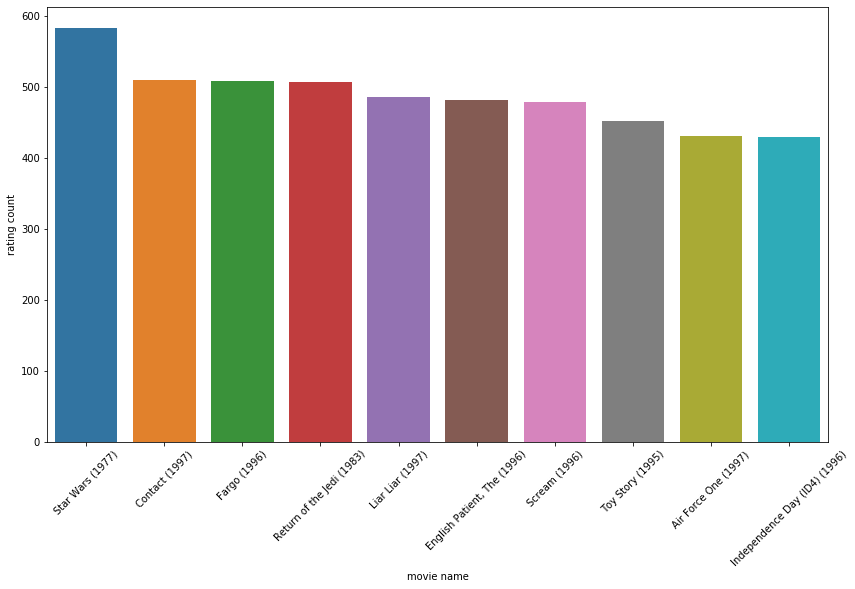

In [33]:
# first let's the most popular top 10 movies
plt.figure(figsize=(14,8))
sns.barplot(x=movie_features.sort_values(by='ratingCount',ascending=False).head(10)["movie title"],
            y=movie_features.sort_values(by='ratingCount',ascending=False).head(10)["ratingCount"])
plt.xlabel("movie name")
plt.xticks(rotation=45)
plt.ylabel("rating count")

 We could see that star wars is the most popular movie between this period, and Contact is the second. We could also see "Return to the Jedi", which is the another movie of star war. It is obviouly that fiction and action movie is the most poplular one and people who saw these movies were all so excited and wanted to rate.
 

* then let's the least popular top 10 movies

Text(0, 0.5, 'rating count')

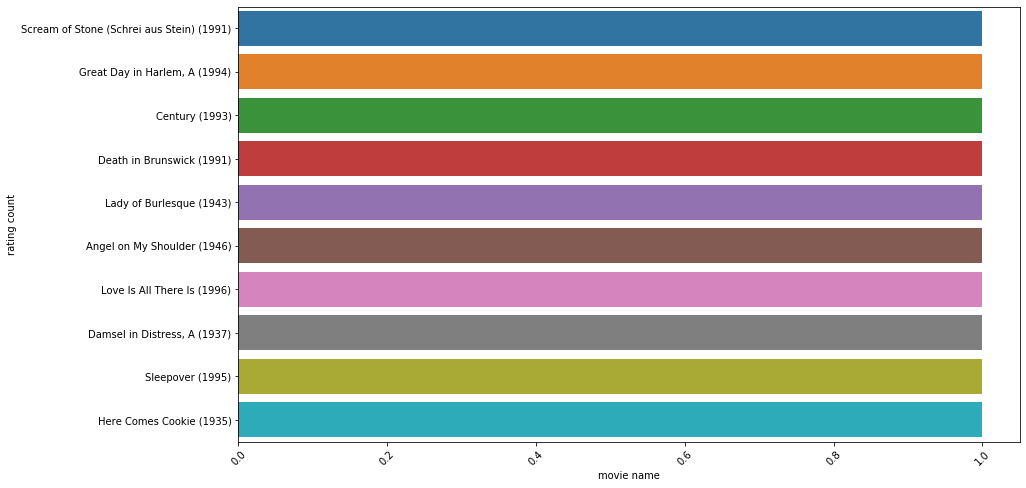

In [830]:
# then let's the least popular top 10 movies
plt.figure(figsize=(14,8))
sns.barplot(x=movie_features.sort_values(by='ratingCount').head(10)["ratingCount"],
            y=movie_features.sort_values(by='ratingCount').head(10)["movie title"],orient='h')
plt.xlabel("movie name")
plt.xticks(rotation=45)
plt.ylabel("rating count")

These top 10 movies are all got one rated by one user, it seems these movies are not such popular like the above graph.

### movie released year

Text(0, 0.5, 'proportion of movie release year')

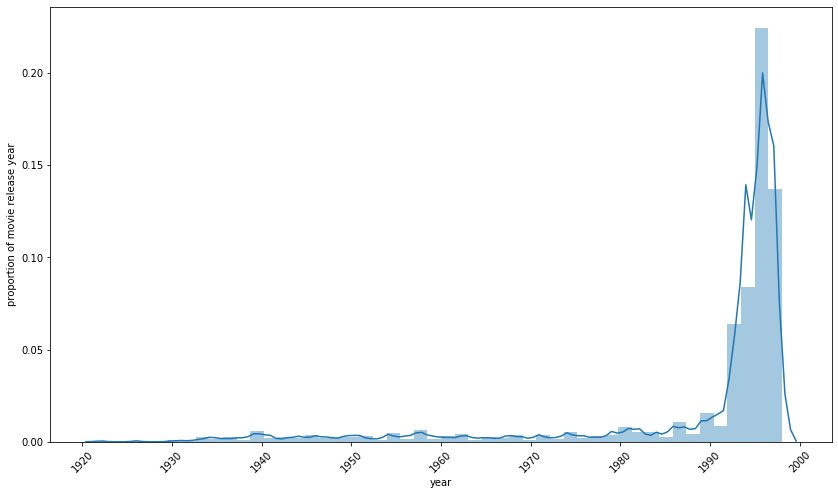

In [40]:
plt.figure(figsize=(14,8))
sns.distplot(movie_features['year'])
plt.xticks(rotation=45)
plt.ylabel("proportion of movie release year")

It seems that before 1991, the number of movie is not large, and after 1991, so many movie are released and people can enjoy a lot. It is because many movie need a special effection which need advanced techonology, and at the beginning from 1920 to 1980, movies are hard to shot
### movie genres

Text(0, 0.5, 'Count Number')

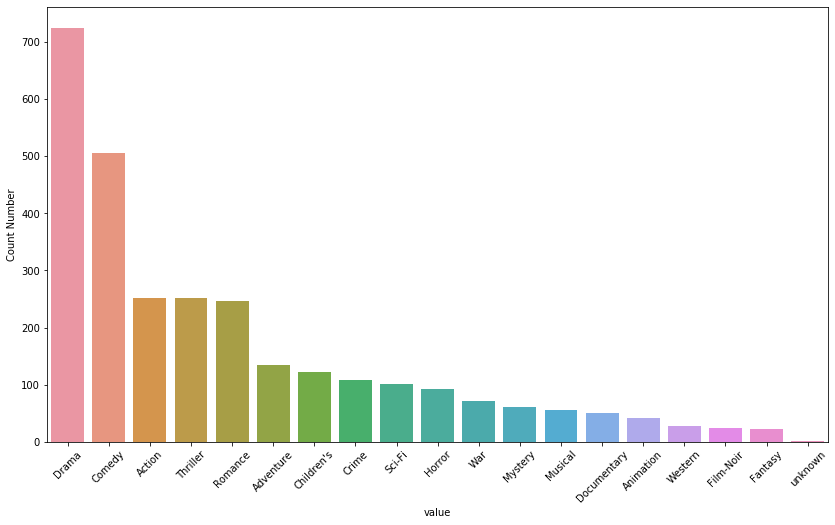

In [65]:
# then lets see the popular movie genres that direcor likes
plt.figure(figsize=(14,8))
# we melt movieGenre1 to movieGenre6 as two clumns, one is the genre strin ,one is the column name
movie_types_count=pd.melt(movie_features,id_vars=["movie id","movie title","year","movieMeanRating","movieStd","ratingCount"])

# then we eliminate the string 0 ,because it is useless
movie_types_count=movie_types_count[movie_types_count["value"]!='0']

# finally we calculate the number of movie genres of all the movies to find which gnere is the most popular one that directors like to shot
sns.countplot(movie_types_count["value"],order=movie_types_count["value"].value_counts().index)
plt.xticks(rotation=45)
plt.ylabel("Movie type")
plt.ylabel("Count Number")

* from the countplot above, we could see that "drama" is the movie type that most direcors like to shot, then is "comedy" which suprised us.Action is the third one. We could see that fiction（Sci-Fi） movie is far away, even not in top5. One of this reason is maybe technological limitaion. That's also why star war is such popular.
* in the old time, directors are really like to shoot drama comedy,may be that is the most easy movie to shoot and the people really want to see this movie type

**lets' now pay more attention on the user behaviours**

In [67]:
final_samples

,user_id,movie_id,rating,timestamp,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,...,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6,age,gender,occupation,zip_code,label
0,186,302,3,891717742,73,3.342466,1.325175,470,77,38,...,Film-Noir,Mystery,Thriller,0.0,0.0,39,F,executive,0,0.0
1,22,377,1,878887116,50,3.620000,1.412625,204,208,435,...,Comedy,0.0,0.0,0.0,0.0,25,M,writer,40206,0.0
2,244,51,2,880606923,176,3.772727,1.128613,154,652,584,...,Romance,War,Western,0.0,0.0,28,M,technician,80525,0.0
3,166,346,1,886397596,6,3.500000,1.516575,313,347,258,...,Drama,0.0,0.0,0.0,0.0,47,M,educator,55113,0.0
4,298,474,4,884182806,69,4.217391,0.764460,215,479,527,...,War,0.0,0.0,0.0,0.0,44,M,executive,1581,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97860,880,476,3,880175444,227,3.378855,0.929884,68,194,208,...,0.0,0.0,0.0,0.0,0.0,13,M,student,83702,0.0
97861,716,204,5,879795543,126,3.888889,1.139981,52,496,611,...,Sci-Fi,0.0,0.0,0.0,0.0,36,F,administrator,44265,1.0
97862,276,1090,1,874795795,341,3.563050,0.963899,143,419,603,...,0.0,0.0,0.0,0.0,0.0,21,M,student,95064,0.0
97863,13,225,2,882399156,491,3.164969,1.416836,427,423,87,...,Comedy,0.0,0.0,0.0,0.0,47,M,educator,29206,0.0


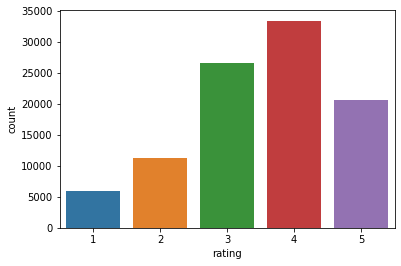

In [70]:
sns.countplot(final_samples["rating"])

The countplot of rating shows in this data set, most peole will rate 4, and least people will rate 1, it is a left skewed distribution but very similar to normal ditribution.
Then we find which user likes to rate movies,and check his or her characteristics

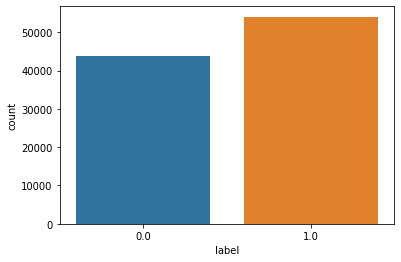

In [831]:
sns.countplot(final_samples["label"])

* The above gragh is the label with 0 and 1 that present whether user liked that movie or not, we could see that these data is not very imbalanced, the label with 0 is about 45000,and label with 1 is about 55000 out of 10k records, In this case, there is no need to do oversampling for trainning data. We could use these data as train and test data directly.


### Top 10 user who liked to watched and rated movie best

In [833]:
user_like_to_rate=final_samples.sort_values(by='userHistoryRatingCount',ascending=False).groupby("user_id").first().reset_index()
top_10_user_like_to_rate=user_like_to_rate.sort_values(by='userHistoryRatingCount',ascending=False).head(10)
top_10_user_like_to_rate

,user_id,movie_id,rating,timestamp,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,...,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6,age,gender,occupation,zip_code,label
404,405,1591,1,885549943,736,1.835598,1.345745,99,1063,418,...,0.0,0.0,0.0,0.0,0.0,22,F,healthcare,10019,0.0
654,655,131,2,893002283,684,2.909357,0.732412,1368,187,320,...,Romance,0.0,0.0,0.0,0.0,50,F,healthcare,60657,0.0
12,13,914,2,892870589,634,3.097792,1.417526,316,900,909,...,Drama,Mystery,Thriller,0.0,0.0,47,M,educator,29206,0.0
449,450,245,4,892141986,539,3.864564,0.863460,1221,478,142,...,Drama,Thriller,War,0.0,0.0,35,F,educator,11758,1.0
275,276,264,3,892436418,517,3.466151,1.017919,272,853,9,...,Thriller,0.0,0.0,0.0,0.0,21,M,student,95064,0.0
415,416,755,4,893214333,488,3.844262,1.098967,658,313,345,...,Adventure,Children's,Fantasy,Sci-Fi,0.0,20,F,student,92626,1.0
536,537,399,2,886032246,486,2.868313,0.975549,134,543,135,...,Adventure,Comedy,0.0,0.0,0.0,36,M,engineer,22902,0.0
302,303,330,3,879552065,483,3.366460,1.232459,387,67,41,...,0.0,0.0,0.0,0.0,0.0,19,M,student,14853,0.0
233,234,301,3,892826947,479,3.123173,0.921311,479,1121,473,...,0.0,0.0,0.0,0.0,0.0,60,M,retired,94702,0.0
392,393,539,3,891364757,447,3.337808,0.817399,316,787,143,...,Comedy,0.0,0.0,0.0,0.0,19,M,student,83686,0.0


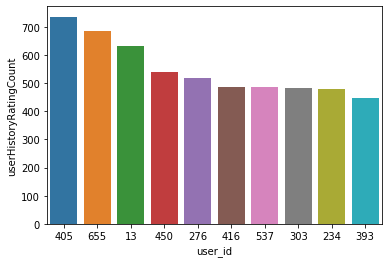

In [834]:
sns.barplot(x="user_id",y="userHistoryRatingCount",data=top_10_user_like_to_rate,order=top_10_user_like_to_rate["user_id"])

* user 405 definitely likes to rate movies, there are only 1682 movies and he/she already saw nearly half of them, which is about 736 movies.And we saw below that 405 is a female and she is only 22 years old at that time, her job is healthcare and may have much boring time, then she starts to watch movie. Which meet our expectation

In [849]:
df_user[df_user["user id"]==405]

,user id,age,gender,occupation,zip code
404,405,22,F,healthcare,10019


### Top 10 user who didn't like to watch and rate movie

In [850]:
top_10_user_dont_like_to_rate=user_like_to_rate.sort_values(by='userHistoryRatingCount',ascending=False).tail(10)
top_10_user_dont_like_to_rate

,user_id,movie_id,rating,timestamp,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,...,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6,age,gender,occupation,zip_code,label
728,729,689,4,893286638,14,2.428571,1.283881,354,322,362,...,Thriller,0.0,0.0,0.0,0.0,19,M,student,56567,1.0
735,736,248,4,878709365,14,2.071429,1.071612,246,0,0,...,Crime,0.0,0.0,0.0,0.0,48,F,writer,94618,1.0
368,369,50,5,889428642,13,3.384615,0.869718,316,346,752,...,Adventure,Romance,Sci-Fi,War,0.0,24,M,student,91335,1.0
18,19,210,3,885412840,13,3.461538,0.877058,8,887,319,...,Adventure,0.0,0.0,0.0,0.0,40,M,librarian,2138,0.0
807,808,327,5,883949986,13,3.461538,0.877058,333,286,270,...,Drama,Mystery,0.0,0.0,0.0,45,M,salesman,90016,1.0
731,732,938,1,882590201,12,4.666667,0.492366,304,332,882,...,Romance,0.0,0.0,0.0,0.0,28,F,other,98405,0.0
131,132,922,5,891278996,12,3.333333,0.492366,100,484,12,...,0.0,0.0,0.0,0.0,0.0,24,M,other,94612,1.0
35,36,885,5,882157581,12,3.000000,1.044466,307,333,288,...,0.0,0.0,0.0,0.0,0.0,19,F,student,93117,1.0
557,558,116,5,879436396,10,3.600000,0.699206,286,124,275,...,0.0,0.0,0.0,0.0,0.0,56,F,writer,63132,1.0
739,740,294,4,879523187,10,2.600000,0.699206,0,0,0,...,0.0,0.0,0.0,0.0,0.0,25,F,educator,22206,1.0


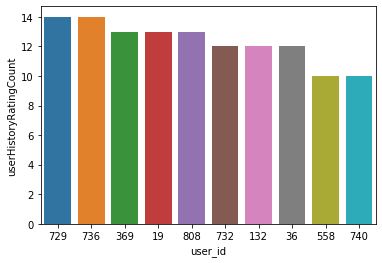

In [851]:
sns.barplot(x="user_id",y="userHistoryRatingCount",data=top_10_user_dont_like_to_rate,order=top_10_user_dont_like_to_rate["user_id"])

* User 740 and 558 is definitely didn't like to watch and rate movies, in the whold 1682 movies, they already watched and rated 10


### User mean rating values about most top 10 and least top 10

Text(0, 0.5, 'least 10 rating meaning')

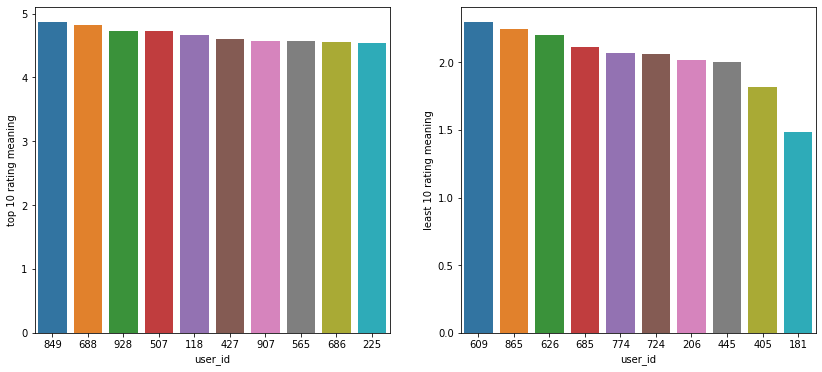

In [409]:
user_rating_mean=final_samples.groupby("user_id").mean().sort_values(by='rating',ascending=False)
top_10_user_rating_mean=user_rating_mean.reset_index().head(10)

tail_10_user_rating_mean=user_rating_mean.reset_index().tail(10)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.barplot(x="user_id",y="rating",data=top_10_user_rating_mean,order=top_10_user_rating_mean["user_id"])
plt.ylabel("top 10 rating meaning")
plt.subplot(1,2,2)
sns.barplot(x="user_id",y="rating",data=tail_10_user_rating_mean,order=tail_10_user_rating_mean["user_id"])
plt.ylabel("least 10 rating meaning")

* From above we could see that user 849 is a very nice person, all his mean rating is about 4.86, very close to 5.Actually, all the user in top 10 meaning rating seems all nice. 
* However, the least ten people are much more critical, the mean id of user 181 is only 1.5, shows he didn't like neary most of the movie he watched. 
* We are surprised that user 405 which is the person saw most movies in the critical gragh. It is extremelly surprised that she is the second least one that her mean rate is only nearly about 1.8 with 736 differenct movies! She seems really like to watch movies but then only watch movies that she did not like, which is very weird

# Model Establishment and Test

## Build training set and testing set 

In [3]:
## upload files to colab local network for hoping the GPU to run faster.
## but yet, it is still slower than my 800$ PC and I don't know why
!mkdir ./train_local
!cp /content/drive/MyDrive/BS6204_Project/final_samples.zip ./train_local/
!cd ./train_local && unzip final_samples.zip

Archive:  final_samples.zip
  inflating: final_samples.csv       


In [222]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import the final features
final_samples=pd.read_csv("train_local/final_samples.csv")

human_behaviour=pd.read_csv("train_local/human_behaviours_2.csv")
human_behaviour

,user id,movie id,rating,timestamp,time,history_rating,user_think_good_movie_id,top5_liked_movies,userHistoryRatingCount,userHistoryMeanRating,...,userLikedTop5_movie_id_3,userLikedTop5_movie_id_4,userLikedTop5_movie_id_5,userLiked_movie_genre_1,userLiked_movie_genre_2,userLiked_movie_genre_3,userLiked_movie_genre_4,userLiked_movie_genre_5,userRatingGoodMovieAveReleasedYear,userRatingGoodMovieStdReleasedYear
0,186,302,3,891717742,1998-04-04 19:22:22,"[5, 1, 5, 3, 4, 3, 4, 2, 4, 5, 3, 3, 2, 2, 1, ...","[300, 322, 291, 591, 100, 925, 281, 79, 203, 9...","[470, 77, 38, 159, 71]",73,3.342466,...,38,159,71,Animation,Children's,Drama,Musical,Mystery,1995,1.827429
1,22,377,1,878887116,1997-11-07 07:18:36,"[5, 1, 1, 1, 3, 5, 5, 5, 5, 4, 4, 5, 3, 3, 4, ...","[258, 173, 186, 238, 153, 154, 201, 455, 692, ...","[204, 208, 435, 523, 85]",50,3.620000,...,435,523,85,Action,Drama,Horror,Sci-Fi,Western,1984,14.252193
2,244,51,2,880606923,1997-11-27 05:02:03,"[5, 3, 4, 2, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, ...","[268, 294, 886, 324, 258, 772, 856, 721, 42, 3...","[154, 652, 584, 200, 217]",176,3.772727,...,584,200,217,Children's,Romance,Comedy,Drama,Horror,1991,7.187426
3,166,346,1,886397596,1998-02-02 05:33:16,"[3, 5, 3, 5, 1, 4]","[313, 347, 258]","[313, 347, 258]",6,3.500000,...,258,0,0,Action,Comedy,Romance,Sci-Fi,Drama,1997,0.577350
4,298,474,4,884182806,1998-01-07 14:20:06,"[4, 4, 3, 4, 5, 4, 5, 3, 5, 5, 3, 5, 4, 4, 4, ...","[286, 172, 588, 174, 69, 211, 603, 483, 50, 28...","[215, 479, 527, 8, 419]",69,4.217391,...,527,8,419,Musical,Mystery,Thriller,Children's,Comedy,1976,19.482272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97860,880,476,3,880175444,1997-11-22 05:10:44,"[5, 4, 3, 3, 4, 3, 4, 4, 4, 4, 3, 4, 5, 4, 5, ...","[302, 288, 258, 294, 328, 301, 689, 948, 181, ...","[68, 194, 208, 204, 42]",227,3.378855,...,208,204,42,Action,Crime,Horror,Romance,Sci-Fi,1992,6.654930
97861,716,204,5,879795543,1997-11-17 19:39:03,"[5, 3, 1, 5, 4, 5, 4, 4, 5, 5, 4, 4, 2, 3, 4, ...","[300, 50, 222, 1, 181, 293, 127, 515, 248, 283...","[52, 496, 611, 511, 494]",126,3.888889,...,611,511,494,Adventure,Comedy,Crime,Film-Noir,Mystery,1975,20.566765
97862,276,1090,1,874795795,1997-09-20 22:49:55,"[5, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 5, 5, ...","[258, 300, 328, 294, 288, 324, 919, 508, 298, ...","[143, 419, 603, 156, 653]",341,3.563050,...,603,156,653,Children's,Comedy,Film-Noir,Mystery,Crime,1987,13.074568
97863,13,225,2,882399156,1997-12-17 22:52:36,"[4, 3, 2, 2, 2, 3, 3, 4, 3, 3, 4, 3, 5, 5, 2, ...","[310, 268, 305, 302, 874, 270, 262, 303, 98, 5...","[427, 423, 87, 28, 404]",491,3.164969,...,87,28,404,Action,Animation,Fantasy,Sci-Fi,Thriller,1981,19.431996


* **User behaviours** is the list of movie ids that user recently saw which is needed in "DIN" model, but our "final_samples" do not have this features. We need to add then into our samples. Actually the features "userLikedTop5_movie_id" can considered as user behaviour, but top 5 movies are too critical and maybe old.For example, some users may recently only rate 4 for some movies, which means the userLikedTop5_movie_id may not be updated by this recent user behaviour.In this case we will use the most recent 5 movies and "userLikedTop5_movie_id" movied both (up to 10 movie ids) as the user behaviours. 

* Although the dataset "final_samples" did not have user recent movie id list, fortunately we already get them in the file "human_behaviours_2" and we already output it, then we just could input it again and add it to this "final_samples" file

* **The "user_think_good_movie_id" columns is what we need, we can only consider the recent 5 movies that this user think good(>3.5).This is highly based on personal preference, all of them could aslo be considered. Here we only choose the most recent 5 good movies.**
* besides, these 5 column features is only used in "DIN" model beacuse that model need a sequence inputs

### add "User_recent_rated_and_liked_movie_id" to our dataset

In [223]:
recent_movie_list_length=5
movie_lists=[]
for i in range(1,recent_movie_list_length+1):
    movie_lists.append([])

for movie_id_list in human_behaviour["user_think_good_movie_id"]:
    # because we input our file from the disk, unfortunately all the list are transfered to str type, and we can not
    # use the list function, then we need to transfer it back to list
    
    movie_id_list=movie_id_list[1:len(movie_id_list)-1] #eliminate the bracket "[" "]",
    movie_id_list=movie_id_list.split(",") # split the string into list based on ","
    
    # skip the null value
    if(len(movie_id_list)==1 and movie_id_list[0]==''):
        for i in range(recent_movie_list_length):
            movie_lists[i].append(0)
        continue
    
    # add the most recent movie into movie_list[0], second into movie_list[1],and so on
    length=len(movie_id_list)
    for i in range(recent_movie_list_length):
        if length>=i+1:
            recent_see_movie_id=int(movie_id_list[length-i-1].strip())
            movie_lists[i].append(recent_see_movie_id)
        else:
            movie_lists[i].append(0)

# add the movie_list[0,1,2,3,4] into the "User_recent_rated_and_liked_movie_id_i" columns
for i in range(1,recent_movie_list_length+1):
    final_samples["User_recent_rated_and_liked_movie_id_"+str(i)]=movie_lists[i-1]

### perpare the train and test dataset

In [224]:
#extract the numerical features
numerical_features=[
                    "userHistoryRatingCount",
                "userHistoryMeanRating",
                "userHistoryStdRating",
                "userRatingGoodMovieAveReleasedYear",
                "userRatingGoodMovieStdReleasedYear",
                "year",
                "movieMeanRating",
                "movieStd",
                "ratingCount",
                "age"
]

# standard normalization to numerical features
sc=StandardScaler()
final_samples[numerical_features]=sc.fit_transform(final_samples[numerical_features])

#drop the values we don't need
X=final_samples.drop(["label","rating",'timestamp'],axis=1)
y=final_samples["label"]

#set the batch size
batch_size=30

#split train and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)
#split train into train and valid set
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.1,stratify=y_train,random_state=1)

#set dataset as tensoflow.Dataset
train_dataset_0=tf.data.Dataset.from_tensor_slices((dict(X_train),y_train))

valid_dataset_0=tf.data.Dataset.from_tensor_slices((dict(X_valid),y_valid))

test_dataset_0=tf.data.Dataset.from_tensor_slices((dict(X_test),y_test))


# random shuffle the data
train_dataset=train_dataset_0.shuffle(100)
valid_dataset=valid_dataset_0.shuffle(100)
test_dataset=test_dataset_0.shuffle(100)

#set the batch size of each iteration of the dataset
train_dataset=train_dataset_0.batch(batch_size)
valid_dataset=valid_dataset_0.batch(batch_size)
test_dataset=test_dataset_0.batch(batch_size)


## Deep learning Model

 Here we implement many classical deep learning  model in Recommendation Systems like：
 * BaseEmbedding model,
 * Deep Crossing, 
 * Deep CF, 
 * Wide&Deep,
 * AFM, 
 * DIN. 
 * DIEN.
 * We will follow the structures about these models and change the neron numbers to let the model more suitable for our dataset.

## Base Model: Embedding+MLP
 * the base model in recommendation system is the embeddeing layers followed by some MLP,then we first implement the base model and find the best hyperparameter for base model, it can help us to fine tune the next few models

#### Load features

In [225]:
#perpare for embedding layer parameters
Gender=["F","M"]

movie_types=["unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir",
             "Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]

Occupation=["administrator","artist","doctor","educator","engineer","entertainment","executive","healthcare","homemaker","lawyer","librarian",
          "marketing","none","other","programmer","retired","salesman","scientist","student","technician","writer"]

Zip_code=final_samples["zip_code"].unique().tolist()

Moive_id=final_samples["movie_id"].unique().tolist()

ALL_FEATURES={ 'userLiked_movie_genre_1': movie_types, 
          'userLiked_movie_genre_2': movie_types, 
          'userLiked_movie_genre_3': movie_types, 
          'userLiked_movie_genre_4': movie_types, 
          'userLiked_movie_genre_5': movie_types, 
          'movieGenre1': movie_types,
          'movieGenre2': movie_types, 
          'movieGenre3': movie_types, 
          'movieGenre4': movie_types, 
          'movieGenre5': movie_types, 
          'movieGenre6': movie_types,
          "userLikedTop5_movie_id_1":Moive_id,
          "userLikedTop5_movie_id_2":Moive_id,
          "userLikedTop5_movie_id_3":Moive_id,
          "userLikedTop5_movie_id_4":Moive_id,
          "userLikedTop5_movie_id_5":Moive_id,
          "zip_code": Zip_code,
          "occupation":Occupation}

categorical_cols=[]
dim_stack=0

#embedding categorical values to low 10 dimension and update the total dimension (dim_stack)
for column,vocab in ALL_FEATURES.items():
    col=tf.feature_column.categorical_column_with_vocabulary_list(
         key=column,vocabulary_list=vocab
      )
    cat_embedding=tf.feature_column.embedding_column(col,10)
    dim_stack+=10
    categorical_cols.append(cat_embedding)

#embedding movie id,there are 1682 movies so we set the num_buckets a little bit larger.
movie_id_one_hot=tf.feature_column.categorical_column_with_identity(key="movie_id",num_buckets=1683)
movieId=tf.feature_column.embedding_column(movie_id_one_hot,10)
dim_stack+=10
#embedding user id,there are 943 user so we set the num_buckets a little bit larger.
user_id_one_hot=tf.feature_column.categorical_column_with_identity(key="user_id",num_buckets=944)
userId=tf.feature_column.embedding_column(user_id_one_hot,10)
dim_stack+=10
categorical_cols.append(movieId)
categorical_cols.append(userId)


#because gender dimension is lower than 10,we add them directly 
gender_one_hot=tf.feature_column.categorical_column_with_vocabulary_list(key="gender",vocabulary_list=Gender)
gender_indicator=tf.feature_column.indicator_column(gender_one_hot)
categorical_cols.append(gender_indicator)
dim_stack+=2

### function to save and reload model for further usage

In [226]:
import h5py
from tensorflow.keras.models import load_model
def save_model_and_history_to(model,history,name):
    ##save the model to google drive for further usage
    MODEL_PATH = name+'_model.h5'
    model.save_weights(MODEL_PATH)

    ## save the history of model while training

    pd.DataFrame(history.history).to_csv(name+"_history.csv")
def reload_model_and_history(name,model,test_dataset,parameter=None):
    # re-load the model.
    # the tf has a bug about load the model with DenseFeature layers
    # this is the only anwser I find on Internet that can work, which is initializing the same model and train it once
    # then the model can be successfully loaded.
    if parameter==None:
        load_model=model()
    elif name=='Nerual_CF':
        load_model=model(movie_columns_mf=[parameter[0]],user_columns_mf=[parameter[1]],dropout=parameter[2],regularizer=parameter[3])
    else:
        load_model=model(parameter)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
    load_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])
    history = load_model.fit(test_dataset, batch_size=1, epochs=1)
    load_model.load_weights(name+"_model.h5")
    history=pd.read_csv(name+"_history.csv")
    return load_model,history

In [227]:
#add numerical directly to the layers

numerical_cols=[tf.feature_column.numeric_column("userHistoryRatingCount"),
                tf.feature_column.numeric_column("userHistoryMeanRating"),
                tf.feature_column.numeric_column("userHistoryStdRating"),
                tf.feature_column.numeric_column("userRatingGoodMovieAveReleasedYear"),
                tf.feature_column.numeric_column("userRatingGoodMovieStdReleasedYear"),
                tf.feature_column.numeric_column("year"),
                tf.feature_column.numeric_column("movieMeanRating"),
                tf.feature_column.numeric_column("movieStd"),
                tf.feature_column.numeric_column("ratingCount"),
                tf.feature_column.numeric_column("age"),             
          ]
# keep updating the embedding layer dimension
dim_stack+=10

#### Define Model and complie

In [228]:

preprocessing_layer = tf.keras.layers.DenseFeatures(numerical_cols + categorical_cols)

def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model
model=MyEMBED_MLP_Model()

In [139]:
history_two_layers_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2341/2349 [============================>.] - ETA: 0s - loss: 0.5781 - accuracy: 0.6945 - auc: 0.7541WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype

Epoch 2/30
2349/2349 [==============================] - 13s 5ms/step - loss: 0.5380 - accuracy: 0.7276 - auc: 0.7971 - val_loss: 0.5562 - val_accuracy: 0.7137 - val_auc: 0.7811
Epoch 3/30
2349/2349 [==============================] - 13s 5ms/step - loss: 0.5055 - accuracy: 0.7479 - auc: 0.8255 - val_loss: 0.5733 - val_accuracy: 0.7065 - val_auc: 0.7744
Epoch 4/30
2349/2349 [==============================] - 13s 5ms/step - loss: 0.4690 - accuracy: 0.7708 - auc: 0.8535 - val_loss: 0.6046 - val_accuracy: 0.6968 - val_auc: 0.7653
Epoch 5/30
2349/2349 [==============================] - 13s 5ms/step - loss: 0.4291 - accuracy: 0.7949 - auc: 0.8798 - val_loss: 0.6517 - val_accuracy: 0.6912 - val_auc: 0.7544
Epoch 6/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.3862 - accuracy: 0.8193 - auc: 0.9045 - val_loss: 0.7133 - val_accuracy: 0.6838 - val_auc: 0.7476
Epoch 7/30
2349/2349 [==============================] - 13s 5ms/step - loss: 0.3448 - accuracy: 0.8436 - auc: 0.925

#### Output the model evaluation

In [142]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 3s 4ms/step - loss: 3.5773 - accuracy: 0.6486 - auc: 0.6796
The evaluation of this model shows the accuracy of this model is 0.649, auc of roc curve is 0.680.


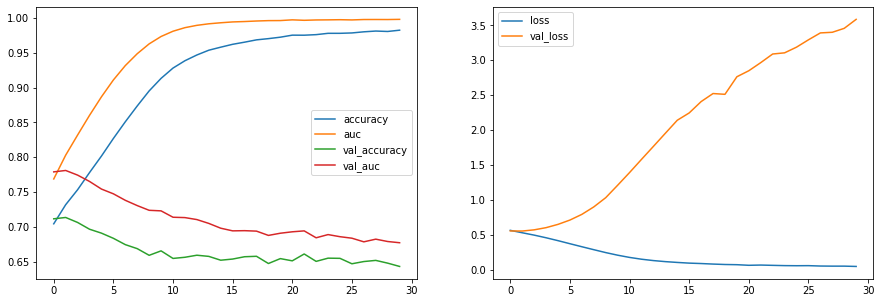

In [212]:
plt.figure(figsize=(15,5))
    #metrics
plt.subplot(1,2,1)
plt.plot(range(30),history_two_layers_EMB_MLP.history["accuracy"])
plt.plot(range(30),history_two_layers_EMB_MLP.history["auc"])

plt.plot(range(30),history_two_layers_EMB_MLP.history["val_accuracy"])
plt.plot(range(30),history_two_layers_EMB_MLP.history["val_auc"])
plt.legend(["accuracy","auc","val_accuracy","val_auc"])

#loss
plt.subplot(1,2,2)
plt.plot(range(30),history_two_layers_EMB_MLP.history["loss"])
plt.plot(range(30),history_two_layers_EMB_MLP.history["val_loss"])
plt.legend(["loss","val_loss"])

The first 4-layer model is overfited too much, the accuracy and auc is extremely high , valid metrics keep decreasing all the time and loss is also very high. The validation auc is 0.6774 and the final test auc is 0.680, but the train auc is 0.9978

### Symplify model

In [148]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model
model=MyEMBED_MLP_Model()

In [150]:
history_simp_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
2344/2349 [============================>.] - ETA: 0s - loss: 0.4988 - accuracy: 0.7499 - auc_1: 0.8300WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_4': <tf.Tensor 'Expa

In [153]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 2s 4ms/step - loss: 3.8810 - accuracy: 0.6566 - auc_1: 0.6838
The evaluation of this model shows the accuracy of this model is 0.657, auc of roc curve is 0.684.


In [331]:
def plot_loss_and_metric_values(history,epoch,count):
    plt.figure(figsize=(15,5))
    #metrics
    plt.subplot(1,2,1)
    plt.plot(range(epoch),history.history["accuracy"])
    plt.plot(range(epoch),history.history["auc_"+str(count)])

    plt.plot(range(epoch),history.history["val_accuracy"])
    plt.plot(range(epoch),history.history["val_auc_"+str(count)])
    plt.legend(["accuracy","auc","val_accuracy","val_auc"])

    #loss
    plt.subplot(1,2,2)
    plt.plot(range(epoch),history.history["loss"])
    plt.plot(range(epoch),history.history["val_loss"])
    plt.legend(["loss","val_loss"])

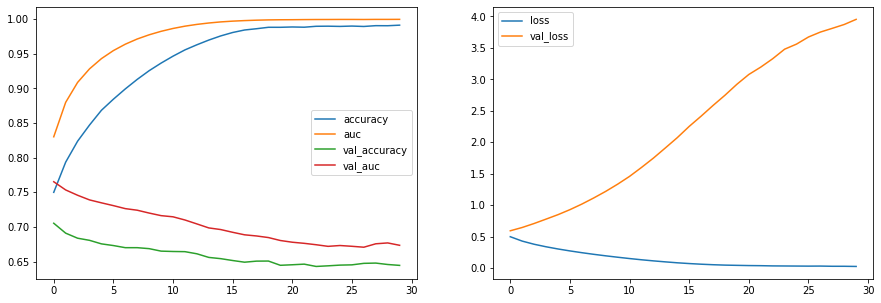

In [163]:

plot_loss_and_metric_values(history_simp_EMB_MLP,30,1)

The validation auc is 0.6735 and the final test auc is 0.684, but the train auc is 0.9995,The 3-layer model also is overfited too much, the accuracy and auc is extremely high , valid metrics keep decreasing all the time and loss is also very high. 

### Add Dropout Layers

In [164]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model
model=MyEMBED_MLP_Model()

In [165]:
history_add_drop_out_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2348/2349 [============================>.] - ETA: 0s - loss: 0.5573 - accuracy: 0.7075 - auc_2: 0.7734WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dty

Epoch 2/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.4670 - accuracy: 0.7698 - auc_2: 0.8539 - val_loss: 0.6252 - val_accuracy: 0.6918 - val_auc_2: 0.7561
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4168 - accuracy: 0.8009 - auc_2: 0.8867 - val_loss: 0.6857 - val_accuracy: 0.6867 - val_auc_2: 0.7478
Epoch 4/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.3850 - accuracy: 0.8166 - auc_2: 0.9043 - val_loss: 0.7301 - val_accuracy: 0.6886 - val_auc_2: 0.7466
Epoch 5/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.3641 - accuracy: 0.8295 - auc_2: 0.9151 - val_loss: 0.7673 - val_accuracy: 0.6819 - val_auc_2: 0.7419
Epoch 6/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.3461 - accuracy: 0.8419 - auc_2: 0.9238 - val_loss: 0.8034 - val_accuracy: 0.6777 - val_auc_2: 0.7362
Epoch 7/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.3368 - accuracy:

In [166]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 3s 4ms/step - loss: 1.2796 - accuracy: 0.6759 - auc_2: 0.7327
The evaluation of this model shows the accuracy of this model is 0.676, auc of roc curve is 0.733.


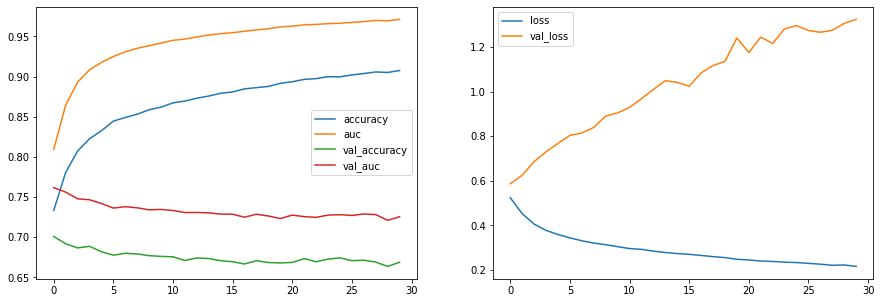

In [168]:
plot_loss_and_metric_values(history_add_drop_out_EMB_MLP,30,2)

The validation auc is 0.7255 and the final test auc is 0.733, but the train auc is 0.9719,The 4-layer model with dropout also is overfited , ,the accuracy and auc is extremely high , valid metrics keep decreasing all the time and loss is also very high, we could see in the validation loss, it actually always keep increasing.

### Add regularizers in Dense layers

In [198]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.3)),
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.3)),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model
model=MyEMBED_MLP_Model()

In [199]:
history_add_regularization_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2342/2349 [============================>.] - ETA: 0s - loss: 7.7570 - accuracy: 0.6834 - auc_16: 0.7679WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dt

Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5864 - accuracy: 0.7520 - auc_16: 0.8300 - val_loss: 0.6489 - val_accuracy: 0.6862 - val_auc_16: 0.7568
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5542 - accuracy: 0.7678 - auc_16: 0.8473 - val_loss: 0.6554 - val_accuracy: 0.6822 - val_auc_16: 0.7516
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5354 - accuracy: 0.7743 - auc_16: 0.8572 - val_loss: 0.6569 - val_accuracy: 0.6847 - val_auc_16: 0.7473
Epoch 5/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5211 - accuracy: 0.7820 - auc_16: 0.8645 - val_loss: 0.6614 - val_accuracy: 0.6794 - val_auc_16: 0.7423
Epoch 6/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5100 - accuracy: 0.7866 - auc_16: 0.8701 - val_loss: 0.6665 - val_accuracy: 0.6748 - val_auc_16: 0.7372
Epoch 7/30
2349/2349 [==============================] - 15s 7ms/step - loss: 0.4998 -

In [200]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 3s 4ms/step - loss: 1.0055 - accuracy: 0.6364 - auc_16: 0.6830
The evaluation of this model shows the accuracy of this model is 0.636, auc of roc curve is 0.683.


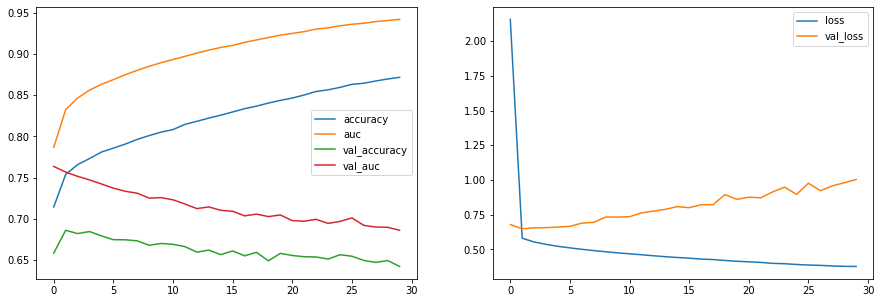

In [201]:
plot_loss_and_metric_values(history_add_regularization_EMB_MLP,30,16)

The validation auc is 0.6822 and the final test auc is 0.683, but the train auc is 0.9424 ,The 4-layer model with regularizer also is overfited , the accuracy and auc is extremely high , valid metrics keep decreasing all the time and loss is also very high, we could see in the validation loss, it also always keep increasing.

turns out that all the methods is not good enough, then we try to combine them together

### Combine useful methods (dropout and regularization)  together


In [21]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential([
    preprocessing_layer, 
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.4)),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.4)),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    return model
model=MyEMBED_MLP_Model()

In [208]:
model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])

history_add_regularization_and_dropout_EMB_MLP=model.fit(train_dataset,epochs=30,validation_data=valid_dataset)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2343/2349 [============================>.] - ETA: 0s - loss: 10.1382 - accuracy: 0.5981 - auc_20: 0.6547WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) d

Epoch 2/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.5910 - accuracy: 0.8184 - auc_20: 0.9012 - val_loss: 0.8777 - val_accuracy: 0.6595 - val_auc_20: 0.7081
Epoch 3/30
2349/2349 [==============================] - 17s 7ms/step - loss: 0.5436 - accuracy: 0.8451 - auc_20: 0.9207 - val_loss: 0.9387 - val_accuracy: 0.6462 - val_auc_20: 0.6963
Epoch 4/30
2349/2349 [==============================] - 17s 7ms/step - loss: 0.5235 - accuracy: 0.8524 - auc_20: 0.9269 - val_loss: 0.9654 - val_accuracy: 0.6508 - val_auc_20: 0.6932
Epoch 5/30
2349/2349 [==============================] - 17s 7ms/step - loss: 0.5092 - accuracy: 0.8606 - auc_20: 0.9319 - val_loss: 0.9796 - val_accuracy: 0.6328 - val_auc_20: 0.6749
Epoch 6/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4994 - accuracy: 0.8659 - auc_20: 0.9342 - val_loss: 1.0227 - val_accuracy: 0.6419 - val_auc_20: 0.6877
Epoch 7/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4951 -

In [209]:
#output the model evaluation
_,acc,auc=model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc,auc))

653/653 [==============================] - 3s 4ms/step - loss: 1.1954 - accuracy: 0.6385 - auc_20: 0.6791
The evaluation of this model shows the accuracy of this model is 0.638, auc of roc curve is 0.679.


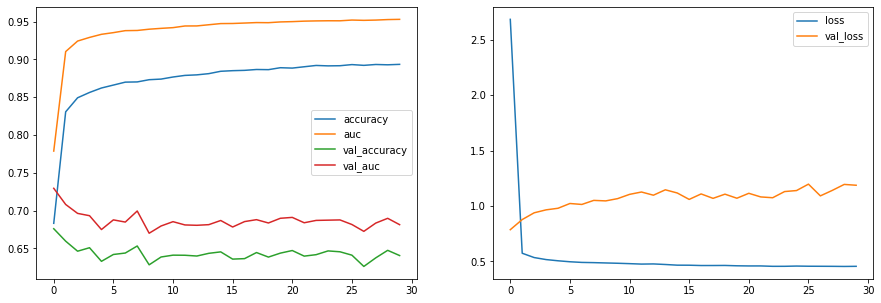

In [210]:
plot_loss_and_metric_values(history_add_regularization_and_dropout_EMB_MLP,30,20)

from the above ,we could see that when we combine the methods together, it actually could help, at least the validation loss stop to increase and vibrate in abound 1.3. Auc and accuracy also reach the plateau. but we could see that validation auc is still low ,only 0.6814,test auc is 0.679, but tha train auc is high, about 0.9527 . We also could see that at the begining, the validation loss already starts to increase. So next, we will change our neron numbers of hidden layer to find a good model

### adjust number of hiddenlayer
from above we now that these method above could help to tune the base model, but the value of hyperparameter seems not good enough,then we adjust the number of hidden layer to see the performance 

In [164]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [49]:
def MyEMBED_MLP_Model(layer_number=0,hidden_layer_neruals=128):
    model = tf.keras.Sequential()
    model.add(preprocessing_layer)
    
    ## use a for loop to decide how many hidden layers should we build
    for _ in range(layer_number):
        
        #hidden_layer_neruals means the output neuron number of the Dense Layer
        model.add(tf.keras.layers.Dense(hidden_layer_neruals,activation='relu')) 
        model.add(layers.Dropout(0.5))
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model


#prepare the number candidate
layer_numbers=[1,2,3]
hidden_layers=[16,32,64,128]

history_loss_collection=[]

# double for loop to get the best pyrameter groups about the candidate above.
# and collect the validation loss of each group to decide which parameter group is best
for layer_number in layer_numbers:
    for hidden_layer in hidden_layers:
        model=MyEMBED_MLP_Model(layer_number,hidden_layer)
        history=model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])
        history_loss_collection.append(history.history["val_loss"])

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2346/2349 [============================>.] - ETA: 0s - loss: 0.5412 - accuracy: 0.7145 - auc_18: 0.7872WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dt

Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4888 - accuracy: 0.7485 - auc_18: 0.8345 - val_loss: 0.6575 - val_accuracy: 0.6986 - val_auc_18: 0.7566
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4845 - accuracy: 0.7477 - auc_18: 0.8362 - val_loss: 0.6756 - val_accuracy: 0.6964 - val_auc_18: 0.7530
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4789 - accuracy: 0.7511 - auc_18: 0.8405 - val_loss: 0.6879 - val_accuracy: 0.6948 - val_auc_18: 0.7527
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2343/2349 [============================>.] - ETA: 0s - loss: 0.5244 - accuracy: 0.7229 - auc_19: 0.8020WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, '

2349/2349 [==============================] - 21s 7ms/step - loss: 0.5243 - accuracy: 0.7229 - auc_19: 0.8021 - val_loss: 0.6563 - val_accuracy: 0.6968 - val_auc_19: 0.7547
Epoch 2/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.4747 - accuracy: 0.7521 - auc_19: 0.8429 - val_loss: 0.6896 - val_accuracy: 0.6936 - val_auc_19: 0.7501
Epoch 3/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4688 - accuracy: 0.7595 - auc_19: 0.8484 - val_loss: 0.7110 - val_accuracy: 0.6932 - val_auc_19: 0.7501
Epoch 4/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4624 - accuracy: 0.7598 - auc_19: 0.8522 - val_loss: 0.7363 - val_accuracy: 0.6962 - val_auc_19: 0.7477
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2349/2349 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.7304 - auc_20: 0.8137WARNING:tensorflow:Layers i

2349/2349 [==============================] - 22s 7ms/step - loss: 0.5127 - accuracy: 0.7304 - auc_20: 0.8137 - val_loss: 0.6724 - val_accuracy: 0.6949 - val_auc_20: 0.7493
Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4644 - accuracy: 0.7581 - auc_20: 0.8485 - val_loss: 0.7249 - val_accuracy: 0.6870 - val_auc_20: 0.7454
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4532 - accuracy: 0.7630 - auc_20: 0.8571 - val_loss: 0.7551 - val_accuracy: 0.6885 - val_auc_20: 0.7455
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4475 - accuracy: 0.7665 - auc_20: 0.8611 - val_loss: 0.7841 - val_accuracy: 0.6870 - val_auc_20: 0.7447
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2345/2349 [============================>.] - ETA: 0s - loss: 0.4996 - accuracy: 0.7389 - auc_21: 0.8228WARNING:tensorflow:Layers i

2349/2349 [==============================] - 22s 7ms/step - loss: 0.4995 - accuracy: 0.7389 - auc_21: 0.8229 - val_loss: 0.6964 - val_accuracy: 0.6863 - val_auc_21: 0.7454
Epoch 2/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.4506 - accuracy: 0.7636 - auc_21: 0.8588 - val_loss: 0.7524 - val_accuracy: 0.6858 - val_auc_21: 0.7429
Epoch 3/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.4380 - accuracy: 0.7730 - auc_21: 0.8682 - val_loss: 0.7553 - val_accuracy: 0.6905 - val_auc_21: 0.7451
Epoch 4/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.4307 - accuracy: 0.7741 - auc_21: 0.8721 - val_loss: 0.8332 - val_accuracy: 0.6857 - val_auc_21: 0.7422
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2344/2349 [============================>.] - ETA: 0s - loss: 0.5745 - accuracy: 0.6866 - auc_22: 0.7504WARNING:tensorflow:Layers i

2349/2349 [==============================] - 22s 7ms/step - loss: 0.5744 - accuracy: 0.6867 - auc_22: 0.7506 - val_loss: 0.6758 - val_accuracy: 0.6936 - val_auc_22: 0.7476
Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4939 - accuracy: 0.7436 - auc_22: 0.8291 - val_loss: 0.7409 - val_accuracy: 0.6944 - val_auc_22: 0.7443
Epoch 3/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.4845 - accuracy: 0.7481 - auc_22: 0.8358 - val_loss: 0.7628 - val_accuracy: 0.6899 - val_auc_22: 0.7395
Epoch 4/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.4795 - accuracy: 0.7509 - auc_22: 0.8378 - val_loss: 0.8068 - val_accuracy: 0.6890 - val_auc_22: 0.7404
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2341/2349 [============================>.] - ETA: 0s - loss: 0.5554 - accuracy: 0.7045 - auc_23: 0.7748WARNING:tensorflow:Layers i

2349/2349 [==============================] - 21s 7ms/step - loss: 0.5552 - accuracy: 0.7046 - auc_23: 0.7750 - val_loss: 0.6829 - val_accuracy: 0.6969 - val_auc_23: 0.7485
Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4788 - accuracy: 0.7493 - auc_23: 0.8385 - val_loss: 0.7889 - val_accuracy: 0.6922 - val_auc_23: 0.7447
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4685 - accuracy: 0.7571 - auc_23: 0.8463 - val_loss: 0.7835 - val_accuracy: 0.6914 - val_auc_23: 0.7404
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4627 - accuracy: 0.7590 - auc_23: 0.8469 - val_loss: 0.8232 - val_accuracy: 0.6847 - val_auc_23: 0.7366
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2342/2349 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.7245 - auc_24: 0.8032WARNING:tensorflow:Layers i

2349/2349 [==============================] - 22s 7ms/step - loss: 0.5209 - accuracy: 0.7246 - auc_24: 0.8033 - val_loss: 0.7524 - val_accuracy: 0.6918 - val_auc_24: 0.7419
Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4615 - accuracy: 0.7552 - auc_24: 0.8498 - val_loss: 0.8260 - val_accuracy: 0.6934 - val_auc_24: 0.7401
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4522 - accuracy: 0.7596 - auc_24: 0.8561 - val_loss: 0.8155 - val_accuracy: 0.6891 - val_auc_24: 0.7390
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4436 - accuracy: 0.7647 - auc_24: 0.8602 - val_loss: 0.8302 - val_accuracy: 0.6857 - val_auc_24: 0.7399
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2348/2349 [============================>.] - ETA: 0s - loss: 0.5070 - accuracy: 0.7323 - auc_25: 0.8157WARNING:tensorflow:Layers i

2349/2349 [==============================] - 23s 7ms/step - loss: 0.5069 - accuracy: 0.7323 - auc_25: 0.8157 - val_loss: 0.7770 - val_accuracy: 0.6894 - val_auc_25: 0.7432
Epoch 2/30
2349/2349 [==============================] - 15s 7ms/step - loss: 0.4511 - accuracy: 0.7600 - auc_25: 0.8568 - val_loss: 0.9096 - val_accuracy: 0.6888 - val_auc_25: 0.7395
Epoch 3/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4400 - accuracy: 0.7663 - auc_25: 0.8639 - val_loss: 0.9105 - val_accuracy: 0.6871 - val_auc_25: 0.7369
Epoch 4/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4309 - accuracy: 0.7700 - auc_25: 0.8700 - val_loss: 0.9874 - val_accuracy: 0.6866 - val_auc_25: 0.7368
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2348/2349 [============================>.] - ETA: 0s - loss: 0.6309 - accuracy: 0.6340 - auc_26: 0.6803WARNING:tensorflow:Layers i

2349/2349 [==============================] - 21s 6ms/step - loss: 0.6308 - accuracy: 0.6341 - auc_26: 0.6804 - val_loss: 0.6179 - val_accuracy: 0.6686 - val_auc_26: 0.7497
Epoch 2/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.5544 - accuracy: 0.6929 - auc_26: 0.7640 - val_loss: 0.6280 - val_accuracy: 0.6636 - val_auc_26: 0.7468
Epoch 3/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.5447 - accuracy: 0.6961 - auc_26: 0.7715 - val_loss: 0.6612 - val_accuracy: 0.6734 - val_auc_26: 0.7500
Epoch 4/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.5374 - accuracy: 0.7096 - auc_26: 0.7839 - val_loss: 0.6787 - val_accuracy: 0.6844 - val_auc_26: 0.7519
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2342/2349 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.6731 - auc_27: 0.7359WARNING:tensorflow:Layers i

2349/2349 [==============================] - 22s 7ms/step - loss: 0.5882 - accuracy: 0.6733 - auc_27: 0.7361 - val_loss: 0.6600 - val_accuracy: 0.6960 - val_auc_27: 0.7470
Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4958 - accuracy: 0.7393 - auc_27: 0.8234 - val_loss: 0.7366 - val_accuracy: 0.6914 - val_auc_27: 0.7438
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4823 - accuracy: 0.7450 - auc_27: 0.8324 - val_loss: 0.7348 - val_accuracy: 0.6946 - val_auc_27: 0.7444
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4753 - accuracy: 0.7484 - auc_27: 0.8370 - val_loss: 0.7979 - val_accuracy: 0.6936 - val_auc_27: 0.7400
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2349/2349 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7038 - auc_28: 0.7814WARNING:tensorflow:Layers i

2349/2349 [==============================] - 23s 7ms/step - loss: 0.5467 - accuracy: 0.7038 - auc_28: 0.7814 - val_loss: 0.7300 - val_accuracy: 0.6907 - val_auc_28: 0.7447
Epoch 2/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4692 - accuracy: 0.7517 - auc_28: 0.8446 - val_loss: 0.8017 - val_accuracy: 0.6881 - val_auc_28: 0.7379
Epoch 3/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4560 - accuracy: 0.7592 - auc_28: 0.8535 - val_loss: 0.9304 - val_accuracy: 0.6904 - val_auc_28: 0.7398
Epoch 4/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.4515 - accuracy: 0.7618 - auc_28: 0.8551 - val_loss: 0.9059 - val_accuracy: 0.6948 - val_auc_28: 0.7414
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2345/2349 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.7188 - auc_29: 0.7970WARNING:tensorflow:Layers i

2349/2349 [==============================] - 25s 8ms/step - loss: 0.5286 - accuracy: 0.7189 - auc_29: 0.7971 - val_loss: 0.7750 - val_accuracy: 0.6958 - val_auc_29: 0.7470
Epoch 2/30
2349/2349 [==============================] - 18s 8ms/step - loss: 0.4581 - accuracy: 0.7583 - auc_29: 0.8537 - val_loss: 0.8300 - val_accuracy: 0.6948 - val_auc_29: 0.7387
Epoch 3/30
2349/2349 [==============================] - 18s 8ms/step - loss: 0.4466 - accuracy: 0.7636 - auc_29: 0.8591 - val_loss: 0.8563 - val_accuracy: 0.6883 - val_auc_29: 0.7393
Epoch 4/30
2349/2349 [==============================] - 18s 8ms/step - loss: 0.4417 - accuracy: 0.7674 - auc_29: 0.8610 - val_loss: 0.9016 - val_accuracy: 0.6856 - val_auc_29: 0.7374
Epoch 00004: early stopping


Text(0, 0.5, 'val_loss')

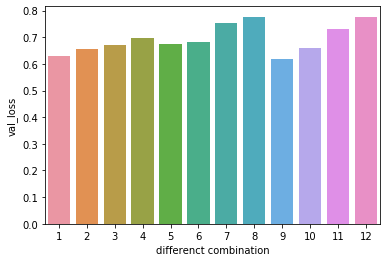

In [62]:
#visualization the validation loss
min_value=[]
for mi in history_loss_collection:
    min_value.append(np.min(mi))
sns.barplot(list(range(1,13)),min_value)
plt.xlabel("differenct combination")
plt.ylabel("val_loss")

From above we could see that when the neuron number increase, the validation loss starts to increase, So 16 is the best, for each group. Then we could find out result shows that 3 layers with 16 neurons are the best 

**Then we change the layer to 3, neron number of each hidden layer to 16, and then fine tune the best dropout probability**

In [63]:
#Then we change the layer to 3, neron number of each hidden layer to 16, and then fine tune the best dropout probability
def MyEMBED_MLP_Model(dropout):
    model = tf.keras.Sequential()
    model.add(preprocessing_layer)
    
    for _ in range(3):
        model.add(tf.keras.layers.Dense(16,activation='relu'))
        model.add(layers.Dropout(dropout))
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
    return model

dropouts=[0.2,0.4,0.5,0.6,0.8,0.9]


history_loss_collection_drop_out=[]

for dropout in dropouts:
    model=MyEMBED_MLP_Model(dropout)
    history=model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])
    history_loss_collection_drop_out.append(history.history["val_loss"])

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2346/2349 [============================>.] - ETA: 0s - loss: 0.5243 - accuracy: 0.7160 - auc_30: 0.7962WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dt

Epoch 2/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.4578 - accuracy: 0.7547 - auc_30: 0.8494 - val_loss: 0.8889 - val_accuracy: 0.6860 - val_auc_30: 0.7341
Epoch 3/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.4428 - accuracy: 0.7581 - auc_30: 0.8573 - val_loss: 0.9555 - val_accuracy: 0.6866 - val_auc_30: 0.7308
Epoch 4/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.4392 - accuracy: 0.7603 - auc_30: 0.8567 - val_loss: 1.0268 - val_accuracy: 0.6862 - val_auc_30: 0.7355
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2349/2349 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.6849 - auc_31: 0.7268WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, '

2349/2349 [==============================] - 24s 7ms/step - loss: 0.6002 - accuracy: 0.6850 - auc_31: 0.7268 - val_loss: 0.5955 - val_accuracy: 0.6937 - val_auc_31: 0.7482
Epoch 2/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.5280 - accuracy: 0.7350 - auc_31: 0.8061 - val_loss: 0.6074 - val_accuracy: 0.6876 - val_auc_31: 0.7483
Epoch 3/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.5148 - accuracy: 0.7375 - auc_31: 0.8185 - val_loss: 0.6256 - val_accuracy: 0.6839 - val_auc_31: 0.7436
Epoch 4/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.5024 - accuracy: 0.7433 - auc_31: 0.8270 - val_loss: 0.6133 - val_accuracy: 0.6904 - val_auc_31: 0.7476
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2348/2349 [============================>.] - ETA: 0s - loss: 0.6294 - accuracy: 0.6290 - auc_32: 0.6734WARNING:tensorflow:Layers i

2349/2349 [==============================] - 23s 7ms/step - loss: 0.6294 - accuracy: 0.6290 - auc_32: 0.6735 - val_loss: 0.6332 - val_accuracy: 0.6886 - val_auc_32: 0.7448
Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5285 - accuracy: 0.7110 - auc_32: 0.7937 - val_loss: 0.7113 - val_accuracy: 0.6926 - val_auc_32: 0.7450
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5145 - accuracy: 0.7268 - auc_32: 0.8046 - val_loss: 0.7535 - val_accuracy: 0.6880 - val_auc_32: 0.7382
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5036 - accuracy: 0.7302 - auc_32: 0.8086 - val_loss: 0.7470 - val_accuracy: 0.6902 - val_auc_32: 0.7347
Epoch 00004: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2342/2349 [============================>.] - ETA: 0s - loss: 0.6518 - accuracy: 0.6327 - auc_33: 0.6448WARNING:tensorflow:Layers i

2349/2349 [==============================] - 23s 7ms/step - loss: 0.6517 - accuracy: 0.6329 - auc_33: 0.6450 - val_loss: 0.5961 - val_accuracy: 0.6948 - val_auc_33: 0.7287
Epoch 2/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.5817 - accuracy: 0.7123 - auc_33: 0.7353 - val_loss: 0.5960 - val_accuracy: 0.6914 - val_auc_33: 0.7458
Epoch 3/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.5648 - accuracy: 0.7219 - auc_33: 0.7616 - val_loss: 0.5972 - val_accuracy: 0.6937 - val_auc_33: 0.7541
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.5533 - accuracy: 0.7295 - auc_33: 0.7789 - val_loss: 0.6060 - val_accuracy: 0.6911 - val_auc_33: 0.7532
Epoch 5/30
2349/2349 [==============================] - 13s 6ms/step - loss: 0.5473 - accuracy: 0.7300 - auc_33: 0.7907 - val_loss: 0.6042 - val_accuracy: 0.6916 - val_auc_33: 0.7508
Epoch 00005: early stopping
Epoch 1/30
Consider rewriting this model with the Functional API.
Co

2349/2349 [==============================] - 23s 7ms/step - loss: 0.7409 - accuracy: 0.5463 - auc_34: 0.5069 - val_loss: 0.6769 - val_accuracy: 0.5525 - val_auc_34: 0.6890
Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6830 - accuracy: 0.5536 - auc_34: 0.5121 - val_loss: 0.6771 - val_accuracy: 0.5525 - val_auc_34: 0.6643
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6793 - accuracy: 0.5536 - auc_34: 0.5255 - val_loss: 0.6699 - val_accuracy: 0.5525 - val_auc_34: 0.6884
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6712 - accuracy: 0.5539 - auc_34: 0.5534 - val_loss: 0.6635 - val_accuracy: 0.5525 - val_auc_34: 0.6544
Epoch 5/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6626 - accuracy: 0.5540 - auc_34: 0.5699 - val_loss: 0.6449 - val_accuracy: 0.5525 - val_auc_34: 0.6839
Epoch 6/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6610 - accuracy: 

2349/2349 [==============================] - 22s 7ms/step - loss: 0.7732 - accuracy: 0.5524 - auc_35: 0.4977 - val_loss: 0.6876 - val_accuracy: 0.5525 - val_auc_35: 0.5012
Epoch 2/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6874 - accuracy: 0.5543 - auc_35: 0.4987 - val_loss: 0.6876 - val_accuracy: 0.5526 - val_auc_35: 0.5011
Epoch 3/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6880 - accuracy: 0.5541 - auc_35: 0.4989 - val_loss: 0.6876 - val_accuracy: 0.5525 - val_auc_35: 0.5001
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6878 - accuracy: 0.5541 - auc_35: 0.4988 - val_loss: 0.6877 - val_accuracy: 0.5525 - val_auc_35: 0.5001
Epoch 5/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6874 - accuracy: 0.5541 - auc_35: 0.4998 - val_loss: 0.6876 - val_accuracy: 0.5525 - val_auc_35: 0.5002
Epoch 00005: early stopping


Text(0, 0.5, 'val_loss')

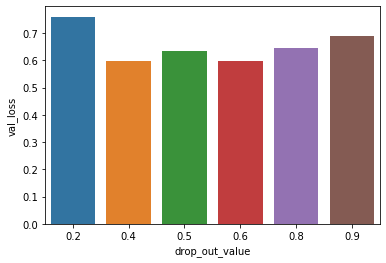

In [70]:
min_value_dropout=[]
for mi in history_loss_collection_drop_out:
    min_value_dropout.append(np.min(mi))
sns.barplot(dropouts,min_value_dropout)
plt.xlabel("drop_out_value")
plt.ylabel("val_loss")

The barplot shows 0.4 has the lowset validation loss and may the best drop probablity

then our base model finally is 3-hidden-layers with 16 neurons in each hidden-layers, and the dropout probablity is 0.4,regularizer is no need since we add "early stopping" callbacks and performance of models is already good at the begining,  then we finally use these hyerparameters to bulid our final model and use test data to show the performance

In [361]:
def MyEMBED_MLP_Model():
    model = tf.keras.Sequential()
    model.add(preprocessing_layer)
    
    for _ in range(3):
        model.add(tf.keras.layers.Dense(16,activation='relu'))
        model.add(layers.Dropout(0.4))
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

model=MyEMBED_MLP_Model()

In [75]:
model.compile( loss='binary_crossentropy',  optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
history_final_base_model=model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2344/2349 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.6673 - auc_38: 0.7119WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=int64>, 'movie_id': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'userHistoryRatingCount': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'userHistoryMeanRating': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, 'userHistoryStdRating': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'userLikedTop5_movie_id_1': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_2': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'userLikedTop5_movie_id_3': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dt

Epoch 2/30
2349/2349 [==============================] - 15s 7ms/step - loss: 0.5126 - accuracy: 0.7393 - auc_38: 0.8034 - val_loss: 0.6530 - val_accuracy: 0.6934 - val_auc_38: 0.7442
Epoch 3/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.5038 - accuracy: 0.7433 - auc_38: 0.8091 - val_loss: 0.6442 - val_accuracy: 0.6917 - val_auc_38: 0.7374
Epoch 4/30
2349/2349 [==============================] - 14s 6ms/step - loss: 0.4984 - accuracy: 0.7449 - auc_38: 0.8108 - val_loss: 0.6824 - val_accuracy: 0.6905 - val_auc_38: 0.7417
Epoch 00004: early stopping


In [248]:
#output the model evaluation
_,acc_base,auc_base=model_EMBED_MLP.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (acc_base,auc_base))

Consider rewriting this model with the Functional API.
653/653 [==============================] - 5s 4ms/step - loss: 0.6745 - accuracy: 0.6863 - auc_15: 0.7439
The evaluation of this model shows the accuracy of this model is 0.686, auc of roc curve is 0.744.


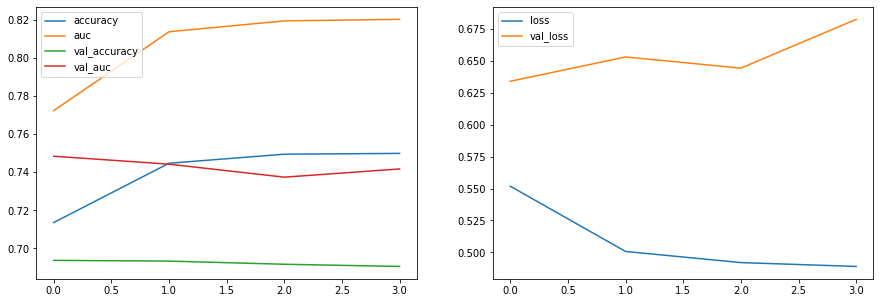

In [251]:
plot_loss_and_metric_values(history_final_base_model,4,38)

From the above tune methods, we get a base model with ROC AUC 0.744 and accuracy 0.6905, which seems not high

### save model

In [88]:
save_model_and_history_to(model,history_final_base_model,"EMBED_MLP")

## Deep Crossing

Deep crossing changes the MLP layer into Residual Layer, whose output is the combination of the inputs and the outputs of two dense layers.The combination will get more information about the inputs

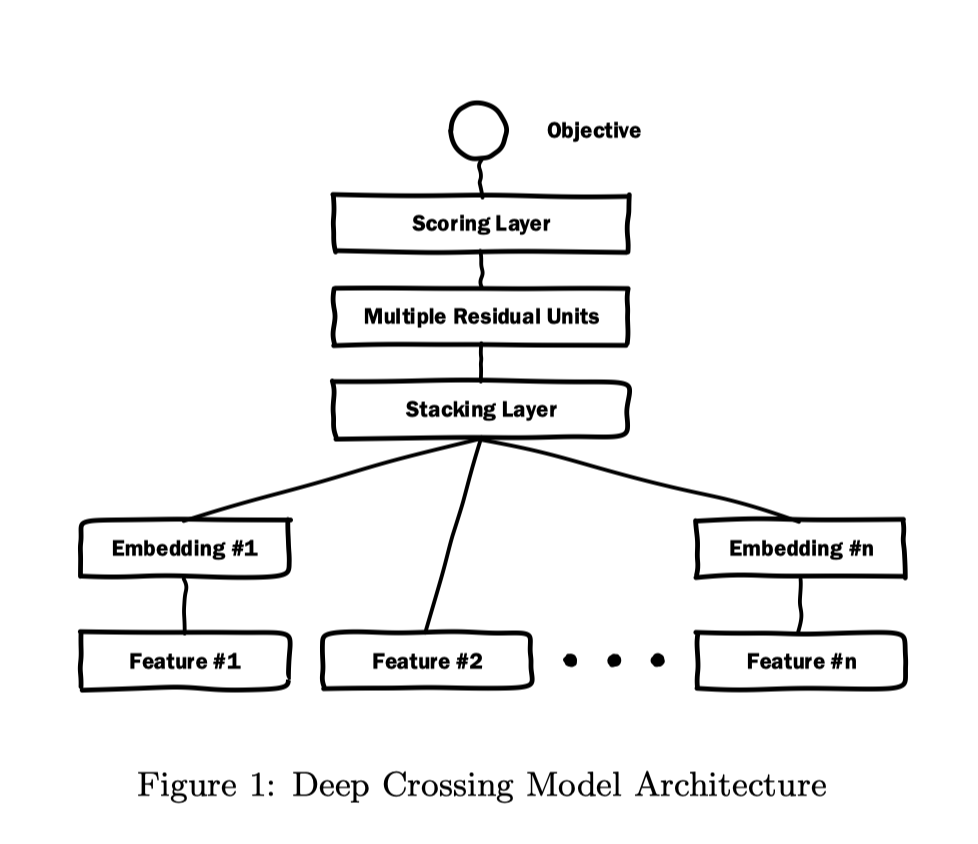

In [362]:
from tensorflow.keras import regularizers
class Residual_Units(layers.Layer):
    def __init__(self,hidden_unit,dim_stack_layer):
        super(Residual_Units,self).__init__()
        self.layer1=layers.Dense(units=hidden_unit,activation='relu',kernel_regularizer=regularizers.l2(1))
        self.layer2=layers.Dense(units=dim_stack_layer,kernel_regularizer=regularizers.l2(1))
        self.relu=layers.ReLU()
        
    def call(self,inputs):
        x=self.layer1(inputs)
        x=self.layer2(x)
        output=self.relu(x+inputs)
        return output 

In [363]:
def Deep_Crossing(dim_stack): 
    inputs={
        ## numerical input layers
        'userHistoryMeanRating': tf.keras.layers.Input(name='userHistoryMeanRating', shape=(), dtype='float32'),
        'userHistoryStdRating': tf.keras.layers.Input(name='userHistoryStdRating', shape=(), dtype='float32'),
        'userRatingGoodMovieAveReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieAveReleasedYear', shape=(), dtype='int32'),
        'userRatingGoodMovieStdReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieStdReleasedYear', shape=(), dtype='float32'),
        'year': tf.keras.layers.Input(name='year', shape=(), dtype='int32'),
        'movieMeanRating': tf.keras.layers.Input(name='movieMeanRating', shape=(), dtype='float32'),
        'movieStd': tf.keras.layers.Input(name='movieStd', shape=(), dtype='float32'),

        'ratingCount': tf.keras.layers.Input(name='ratingCount', shape=(), dtype='int32'),
        'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
        'userHistoryRatingCount': tf.keras.layers.Input(name='userHistoryRatingCount', shape=(), dtype='int32'),

        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='string'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    #embedding layer
    embedding_layer=layers.DenseFeatures(numerical_cols + categorical_cols)(inputs)
    #residual layer
    residual_output=Residual_Units(64,dim_stack)(embedding_layer)
    #add an drop function
    drop_out_layer=layers.Dropout(0.5)(residual_output)
    #output layer
    output_layer=layers.Dense(1,activation='sigmoid')(drop_out_layer)
    
    model=keras.Model(inputs,output_layer)
    return model

dp_model=Deep_Crossing(dim_stack)

In [919]:
dp_model.compile( loss='binary_crossentropy', 
      optimizer='adam',metrics=['accuracy', 
      tf.keras.metrics.AUC(curve='ROC')])
history_dp_crossing=dp_model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30


Input dict contained keys ['User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.


2349/2349 [==============================] - 25s 8ms/step - loss: 17.3228 - accuracy: 0.5891 - auc_46: 0.6159 - val_loss: 0.6056 - val_accuracy: 0.6872 - val_auc_46: 0.7485
Epoch 2/30
2349/2349 [==============================] - 15s 6ms/step - loss: 0.6141 - accuracy: 0.6629 - auc_46: 0.7151 - val_loss: 0.5847 - val_accuracy: 0.6982 - val_auc_46: 0.7593
Epoch 3/30
2349/2349 [==============================] - 15s 7ms/step - loss: 0.5907 - accuracy: 0.6878 - auc_46: 0.7451 - val_loss: 0.5770 - val_accuracy: 0.7061 - val_auc_46: 0.7642
Epoch 4/30
2349/2349 [==============================] - 15s 7ms/step - loss: 0.5784 - accuracy: 0.6981 - auc_46: 0.7587 - val_loss: 0.5734 - val_accuracy: 0.7056 - val_auc_46: 0.7663
Epoch 5/30
2349/2349 [==============================] - 15s 7ms/step - loss: 0.5715 - accuracy: 0.7034 - auc_46: 0.7662 - val_loss: 0.5716 - val_accuracy: 0.7083 - val_auc_46: 0.7677
Epoch 6/30
2349/2349 [==============================] - 15s 7ms/step - loss: 0.5655 - accuracy:

In [920]:
dp_model.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
gender (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
movieGenre1 (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
movieGenre2 (InputLayer)        [(None,)]            0                                            
___________________________________________________________________________________________

In [921]:
#output the model evaluation
dc_loss,dc_acc,dc_auc=dp_model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (dc_acc,dc_auc))

653/653 [==============================] - 3s 4ms/step - loss: 0.5710 - accuracy: 0.7014 - auc_46: 0.7669
The evaluation of this model shows the accuracy of this model is 0.701, auc of roc curve is 0.767.


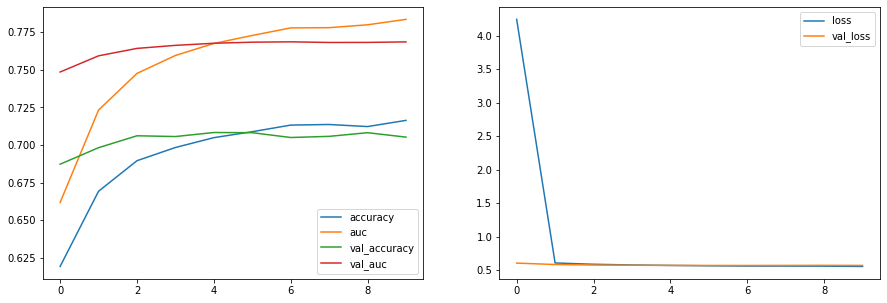

In [922]:
plot_loss_and_metric_values(history_dp_crossing,10,46)

### Save Deep-Crossing model

In [923]:
save_model_and_history_to(dp_model,history_dp_crossing,"Deep_Crossing")

In [924]:
keras.utils.plot_model(dp_model) 
# we want to plot the model gragh, 
# but this function seems have a lot of bugs and can not work well even we ask on the Internet

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


##  Neural CF
 Neural CF only need "movie id", "user id" as inputs, and label as label. it changes the classical CF into deep learning model,There are two towers, the first tower is MLP layer with the embedding layers of Movie id and user id, the another tower is the Element- wise product of Embediing layers of Movie id and user id, and then concatenate outputs of two towers as one to predict the label.
* use the first 2 columns in "final_samples" to build the import dataset of Neural CF

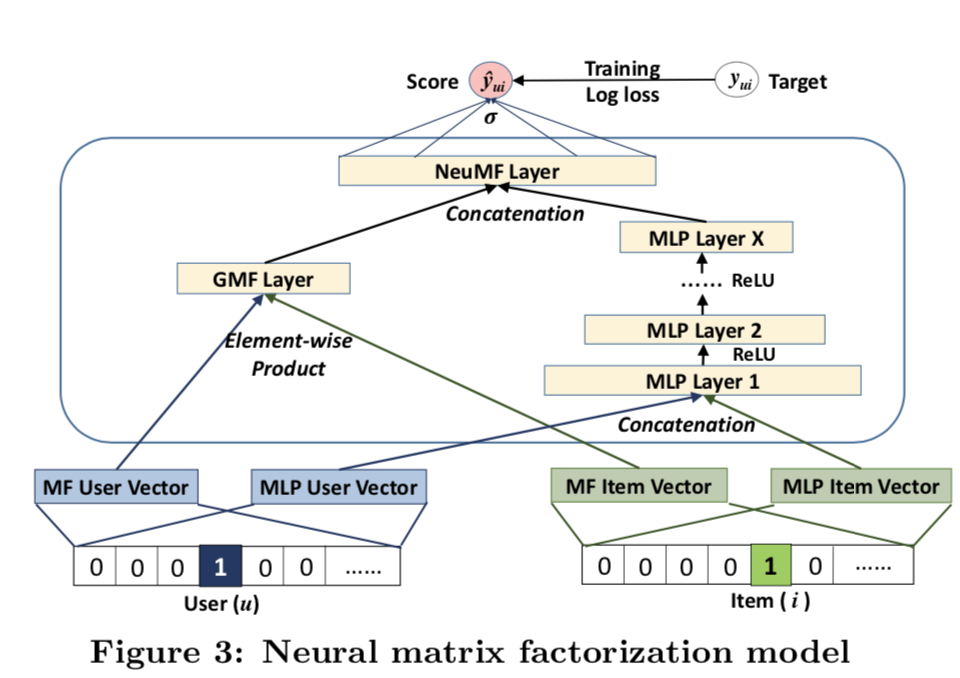

In [364]:
# MLP Embeding
movieId_mlp=movieId
userId_mlp=userId


#MF Embedding (Element wise embedeing layer number is different with the MLP embedding layer)

hidden_vector_dim=32
movieId_mf=tf.feature_column.embedding_column(movie_id_one_hot,hidden_vector_dim)
userId_mf=tf.feature_column.embedding_column(user_id_one_hot,hidden_vector_dim)


In [365]:
def NerualCF(movie_columns_mlp=[movieId_mlp], user_columns_mlp=[userId_mlp],movie_columns_mf=[movieId_mf], user_columns_mf=[userId_mf],hidden_unit=[10,10],dropout=0.7,regularizer=regularizers.l2(1)):
    inputs={
        "movie_id":layers.Input(name="movie_id",shape=(), dtype='int32'),
        "user_id":layers.Input(name="user_id",shape=(), dtype='int32'),
    }
    
    #MLP embeding layer
    movie_embeding_mlp=layers.DenseFeatures(movie_columns_mlp)(inputs) # dim (1,10)
    user_embeding_mlp=layers.DenseFeatures(user_columns_mlp)(inputs) # dim (1,10)
    
    mlp_layers=layers.concatenate([movie_embeding_mlp,user_embeding_mlp]) # dim (1,10+10)
    
    #MLP layers
    for unit in hidden_unit:
        mlp_layers=layers.Dense(unit,activation="relu",kernel_regularizer=regularizer)(mlp_layers) #dim (1,hidden_unit)
    mlp_layers=layers.Dropout(dropout)(mlp_layers)
    
    #MF embeding layer
    movie_embeding_mf=layers.DenseFeatures(movie_columns_mf)(inputs) #dim(1,hidden_vector_dim)
    user_embeding_mf=layers.DenseFeatures(user_columns_mf)(inputs) #dim(1,hidden_vector_dim)
    
    #GMF layers
    mf_layers=tf.multiply(movie_embeding_mf,user_embeding_mf) #dim(1,hidden_vector_dim)(element wise product)
    
    # concate MF and MLP layers together 
    concate_layer=layers.concatenate([mlp_layers,mf_layers]) #dim(1,hidden_vector_dim + hidden_unit)
    
    #output the result
    output_layer=layers.Dropout(dropout)(concate_layer)
    output_layer=layers.Dense(1,activation='sigmoid')(output_layer)
    
    
    nerual_cf_model=keras.Model(inputs,output_layer)
    return nerual_cf_model

In [939]:
ncf_model=NerualCF([movieId_mlp],[userId_mlp],[movieId_mf],[userId_mf],[10,10],0.7,regularizers.l2(1))

ncf_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",tf.keras.metrics.AUC(curve='ROC')])

In [940]:
ncf_history=ncf_model.fit(train_dataset,epochs=50,validation_data=valid_dataset)

Epoch 1/50
2349/2349 [==============================] - 13s 5ms/step - loss: 5.3539 - accuracy: 0.5466 - auc_52: 0.5012 - val_loss: 0.6877 - val_accuracy: 0.5525 - val_auc_52: 0.5043
Epoch 2/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6852 - accuracy: 0.5549 - auc_52: 0.5435 - val_loss: 0.6872 - val_accuracy: 0.5525 - val_auc_52: 0.5173
Epoch 3/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6774 - accuracy: 0.5665 - auc_52: 0.6004 - val_loss: 0.6821 - val_accuracy: 0.5576 - val_auc_52: 0.5631
Epoch 4/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6539 - accuracy: 0.6148 - auc_52: 0.6652 - val_loss: 0.6638 - val_accuracy: 0.5951 - val_auc_52: 0.6298
Epoch 5/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6164 - accuracy: 0.6606 - auc_52: 0.7190 - val_loss: 0.6392 - val_accuracy: 0.6269 - val_auc_52: 0.6771
Epoch 6/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.5858 -

In [941]:
#output the model evaluation
ncf_loss,ncf_acc,ncf_auc=ncf_model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (ncf_acc,ncf_auc))

653/653 [==============================] - 2s 3ms/step - loss: 0.5883 - accuracy: 0.7015 - auc_52: 0.7657
The evaluation of this model shows the accuracy of this model is 0.702, auc of roc curve is 0.766.


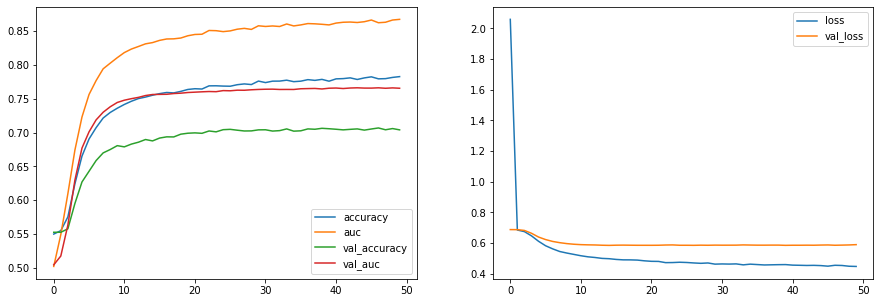

In [943]:
plot_loss_and_metric_values(ncf_history,50,52)

In [944]:
save_model_and_history_to(ncf_model,ncf_history,"Nerual_CF")

#### Change the hidden vector dimension

In [366]:
# change the dimension of hidden vecotor to 64
hidden_vector_dim=64
movieId_mf_64=tf.feature_column.embedding_column(movie_id_one_hot,hidden_vector_dim)
userId_mf_64=tf.feature_column.embedding_column(user_id_one_hot,hidden_vector_dim)

In [367]:
ncf_model_64=NerualCF([movieId_mlp],[userId_mlp],[movieId_mf_64],[userId_mf_64],[10,10],0.8,regularizers.l2(1.2))

ncf_model_64.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",tf.keras.metrics.AUC(curve='ROC')])

In [949]:
ncf_history_64=ncf_model_64.fit(train_dataset,epochs=50,validation_data=valid_dataset)

Epoch 1/50
2349/2349 [==============================] - 14s 5ms/step - loss: 6.3443 - accuracy: 0.5474 - auc_54: 0.5023 - val_loss: 0.6875 - val_accuracy: 0.5525 - val_auc_54: 0.5080
Epoch 2/50
2349/2349 [==============================] - 12s 5ms/step - loss: 0.6854 - accuracy: 0.5542 - auc_54: 0.5479 - val_loss: 0.6864 - val_accuracy: 0.5525 - val_auc_54: 0.5387
Epoch 3/50
2349/2349 [==============================] - 15s 6ms/step - loss: 0.6759 - accuracy: 0.5680 - auc_54: 0.6149 - val_loss: 0.6760 - val_accuracy: 0.5617 - val_auc_54: 0.6152
Epoch 4/50
2349/2349 [==============================] - 14s 6ms/step - loss: 0.6490 - accuracy: 0.6230 - auc_54: 0.6766 - val_loss: 0.6515 - val_accuracy: 0.6119 - val_auc_54: 0.6736
Epoch 5/50
2349/2349 [==============================] - 12s 5ms/step - loss: 0.6109 - accuracy: 0.6680 - auc_54: 0.7292 - val_loss: 0.6285 - val_accuracy: 0.6462 - val_auc_54: 0.7025
Epoch 6/50
2349/2349 [==============================] - 12s 5ms/step - loss: 0.5772 -

In [951]:
#output the model evaluation
ncf64_loss,ncf64_acc,ncf64_auc=ncf_model_64.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (ncf64_acc,ncf64_auc))

653/653 [==============================] - 2s 4ms/step - loss: 0.5792 - accuracy: 0.7065 - auc_54: 0.7696
The evaluation of this model shows the accuracy of this model is 0.707, auc of roc curve is 0.770.


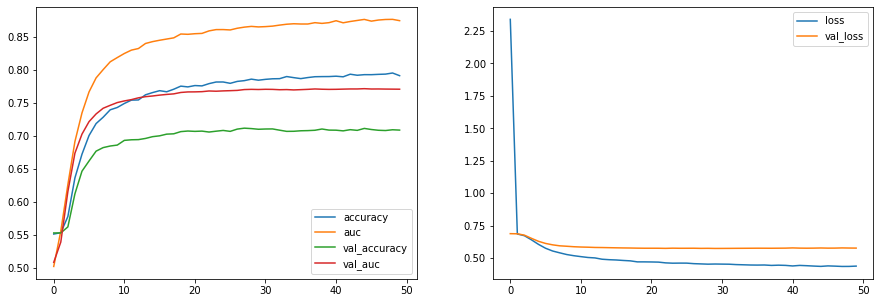

In [953]:
plot_loss_and_metric_values(ncf_history_64,50,54)

In [954]:
# change the dimension of hidden vecotor to 16
hidden_vector_dim=16
movieId_mf=tf.feature_column.embedding_column(movie_id_one_hot,hidden_vector_dim)
userId_mf=tf.feature_column.embedding_column(user_id_one_hot,hidden_vector_dim)

In [955]:
ncf_model_16=NerualCF([movieId_mlp],[userId_mlp],[movieId_mf],[userId_mf],[10,10],0.7,regularizers.l2(1))

ncf_model_16.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",tf.keras.metrics.AUC(curve='ROC')])

In [956]:
ncf_history_16=ncf_model_16.fit(train_dataset,epochs=50,validation_data=valid_dataset)

Epoch 1/50


Input dict contained keys ['userHistoryRatingCount', 'userHistoryMeanRating', 'userHistoryStdRating', 'userLikedTop5_movie_id_1', 'userLikedTop5_movie_id_2', 'userLikedTop5_movie_id_3', 'userLikedTop5_movie_id_4', 'userLikedTop5_movie_id_5', 'userLiked_movie_genre_1', 'userLiked_movie_genre_2', 'userLiked_movie_genre_3', 'userLiked_movie_genre_4', 'userLiked_movie_genre_5', 'userRatingGoodMovieAveReleasedYear', 'userRatingGoodMovieStdReleasedYear', 'year', 'movieMeanRating', 'movieStd', 'ratingCount', 'movieGenre1', 'movieGenre2', 'movieGenre3', 'movieGenre4', 'movieGenre5', 'movieGenre6', 'age', 'gender', 'occupation', 'zip_code', 'User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.


2349/2349 [==============================] - 14s 5ms/step - loss: 5.6200 - accuracy: 0.5381 - auc_55: 0.4951 - val_loss: 0.6876 - val_accuracy: 0.5525 - val_auc_55: 0.5063
Epoch 2/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6871 - accuracy: 0.5543 - auc_55: 0.5095 - val_loss: 0.6875 - val_accuracy: 0.5525 - val_auc_55: 0.5059
Epoch 3/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6847 - accuracy: 0.5562 - auc_55: 0.5443 - val_loss: 0.6867 - val_accuracy: 0.5535 - val_auc_55: 0.5244
Epoch 4/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6788 - accuracy: 0.5705 - auc_55: 0.5764 - val_loss: 0.6839 - val_accuracy: 0.5554 - val_auc_55: 0.5493
Epoch 5/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6688 - accuracy: 0.5886 - auc_55: 0.6103 - val_loss: 0.6759 - val_accuracy: 0.5686 - val_auc_55: 0.5901
Epoch 6/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.6553 - accuracy: 

Epoch 46/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.5219 - accuracy: 0.7324 - auc_55: 0.8103 - val_loss: 0.5697 - val_accuracy: 0.7075 - val_auc_55: 0.7717
Epoch 47/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.5235 - accuracy: 0.7330 - auc_55: 0.8091 - val_loss: 0.5697 - val_accuracy: 0.7059 - val_auc_55: 0.7717
Epoch 48/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.5234 - accuracy: 0.7356 - auc_55: 0.8095 - val_loss: 0.5695 - val_accuracy: 0.7061 - val_auc_55: 0.7722
Epoch 49/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.5200 - accuracy: 0.7366 - auc_55: 0.8129 - val_loss: 0.5692 - val_accuracy: 0.7078 - val_auc_55: 0.7722
Epoch 50/50
2349/2349 [==============================] - 11s 5ms/step - loss: 0.5232 - accuracy: 0.7315 - auc_55: 0.8095 - val_loss: 0.5694 - val_accuracy: 0.7075 - val_auc_55: 0.7718


In [957]:
#output the model evaluation
ncf16_loss,ncf16_acc,ncf16_auc=ncf_model_16.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (ncf16_acc,ncf16_auc))

653/653 [==============================] - 2s 3ms/step - loss: 0.5734 - accuracy: 0.6999 - auc_55: 0.7675
The evaluation of this model shows the accuracy of this model is 0.700, auc of roc curve is 0.768.


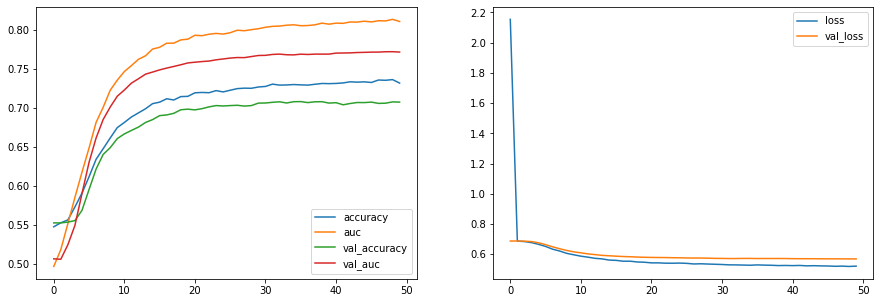

In [958]:
plot_loss_and_metric_values(ncf_history_16,50,55)

From above we could see that the performance of model became best in 64 of hidden vector,  then we choose Nerual_CF with 64 hidden vector number to save

In [960]:
save_model_and_history_to(ncf_model_64,ncf_history,"Nerual_CF")

## Wide&Deep

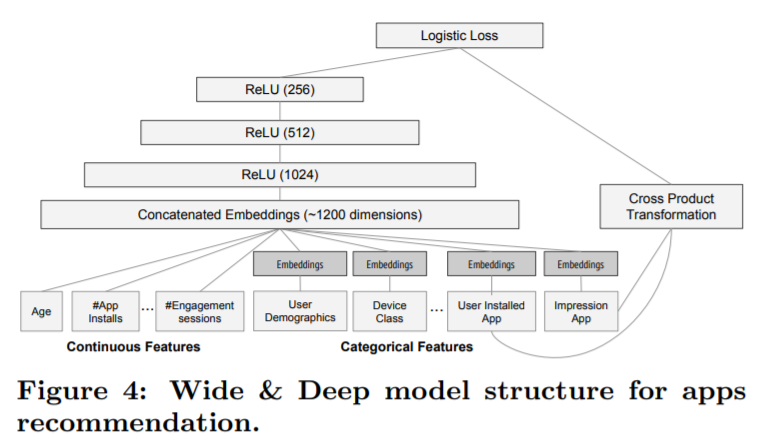

* this model is combine by deep model and wide model
    * deep model is Embedding + MLP 
    * wide is the crossing between **movie id user already saw** and the **movie id user tend to see** 

In [368]:
def Wide_And_Deep(dropout=0.2,regularizer=None):
    
    # define input for keras model
    inputs = {
        ## numerical input layers
        'userHistoryMeanRating': tf.keras.layers.Input(name='userHistoryMeanRating', shape=(), dtype='float32'),
        'userHistoryStdRating': tf.keras.layers.Input(name='userHistoryStdRating', shape=(), dtype='float32'),
        'userRatingGoodMovieAveReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieAveReleasedYear', shape=(), dtype='int32'),
        'userRatingGoodMovieStdReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieStdReleasedYear', shape=(), dtype='float32'),
        'year': tf.keras.layers.Input(name='year', shape=(), dtype='int32'),
        'movieMeanRating': tf.keras.layers.Input(name='movieMeanRating', shape=(), dtype='float32'),
        'movieStd': tf.keras.layers.Input(name='movieStd', shape=(), dtype='float32'),

        'ratingCount': tf.keras.layers.Input(name='ratingCount', shape=(), dtype='int32'),
        'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
        'userHistoryRatingCount': tf.keras.layers.Input(name='userHistoryRatingCount', shape=(), dtype='int32'),

        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='string'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    
    ## deep model
    ### we directly use the base model 
    deep_input_layer=layers.DenseFeatures(numerical_cols + categorical_cols)(inputs)
    deep_layer1=layers.Dense(64,activation="relu",kernel_regularizer=regularizer)(deep_input_layer)
    
    deep_dropout1=layers.Dropout(dropout)(deep_layer1)
    deep_layer2=layers.Dense(64,activation="relu",kernel_regularizer=regularizer)(deep_dropout1)
    deep_dropout2=layers.Dropout(dropout)(deep_layer2)
    
    ## wide model
    ## this is the movie user will see and rate
    movie_id_will_see=movie_id_one_hot
    ## this is the movie user already saw and thought it is good.
    movie_id_saw=tf.feature_column.categorical_column_with_identity(key="userLikedTop5_movie_id_1",num_buckets=1683)
    ## calculate the cross products 
    cross_feature=tf.feature_column.crossed_column([movie_id_will_see,movie_id_saw],10000) 
    cross_feature=tf.feature_column.indicator_column(cross_feature)
    
    wide_layer=layers.DenseFeatures(cross_feature)(inputs)
    
    
    #concatenate both layers as one and output
    concate_layer=layers.concatenate([deep_dropout2,wide_layer])
    
    output_layer=layers.Dense(1,activation="sigmoid")(concate_layer)
    
    model=keras.Model(inputs,output_layer)
    return model


In [369]:
wide_and_deep_model=Wide_And_Deep(0.2,regularizers.l2(0.08))
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

wide_and_deep_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])

In [970]:
wd_hitory=wide_and_deep_model.fit(train_dataset,epochs=20,validation_data=valid_dataset,callbacks=[es])

Epoch 1/20


Input dict contained keys ['User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.


2349/2349 [==============================] - 33s 11ms/step - loss: 6.8338 - accuracy: 0.5580 - auc_58: 0.5925 - val_loss: 0.7706 - val_accuracy: 0.5525 - val_auc_58: 0.7207
Epoch 2/20
2349/2349 [==============================] - 23s 10ms/step - loss: 0.7159 - accuracy: 0.5614 - auc_58: 0.7101 - val_loss: 0.6700 - val_accuracy: 0.6631 - val_auc_58: 0.7475
Epoch 3/20
2349/2349 [==============================] - 23s 10ms/step - loss: 0.6573 - accuracy: 0.6838 - auc_58: 0.7527 - val_loss: 0.6419 - val_accuracy: 0.6957 - val_auc_58: 0.7567
Epoch 4/20
2349/2349 [==============================] - 25s 10ms/step - loss: 0.6326 - accuracy: 0.7011 - auc_58: 0.7635 - val_loss: 0.6307 - val_accuracy: 0.6968 - val_auc_58: 0.7602
Epoch 5/20
2349/2349 [==============================] - 23s 10ms/step - loss: 0.6229 - accuracy: 0.7022 - auc_58: 0.7657 - val_loss: 0.6235 - val_accuracy: 0.7006 - val_auc_58: 0.7633
Epoch 6/20
2349/2349 [==============================] - 24s 10ms/step - loss: 0.6155 - accu

In [971]:
#output the model evaluation
wad_loss,wad_acc,wad_auc=wide_and_deep_model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (wad_acc,wad_auc))

653/653 [==============================] - 4s 6ms/step - loss: 0.5934 - accuracy: 0.7080 - auc_58: 0.7751
The evaluation of this model shows the accuracy of this model is 0.708, auc of roc curve is 0.775.


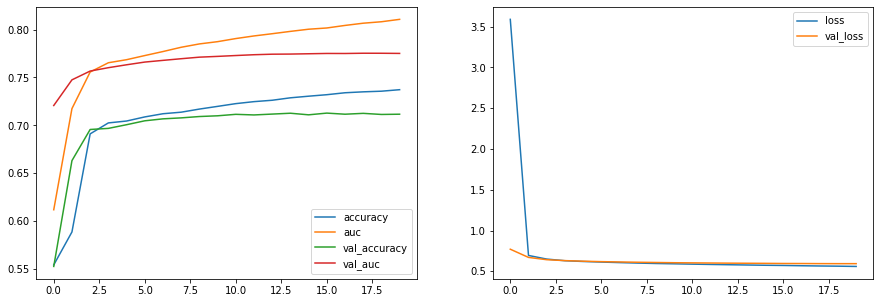

In [972]:
plot_loss_and_metric_values(wd_hitory,20,58)

### save wide&deep model

In [973]:
save_model_and_history_to(wide_and_deep_model,wd_hitory,"Wide_and_deep")

## AFM

AFM is the Factorization Machine with attention layer. It is combined by 
* Embedding layer,
* pair-wise interaction layer,
* Attention-based pooling,
* output layer. 

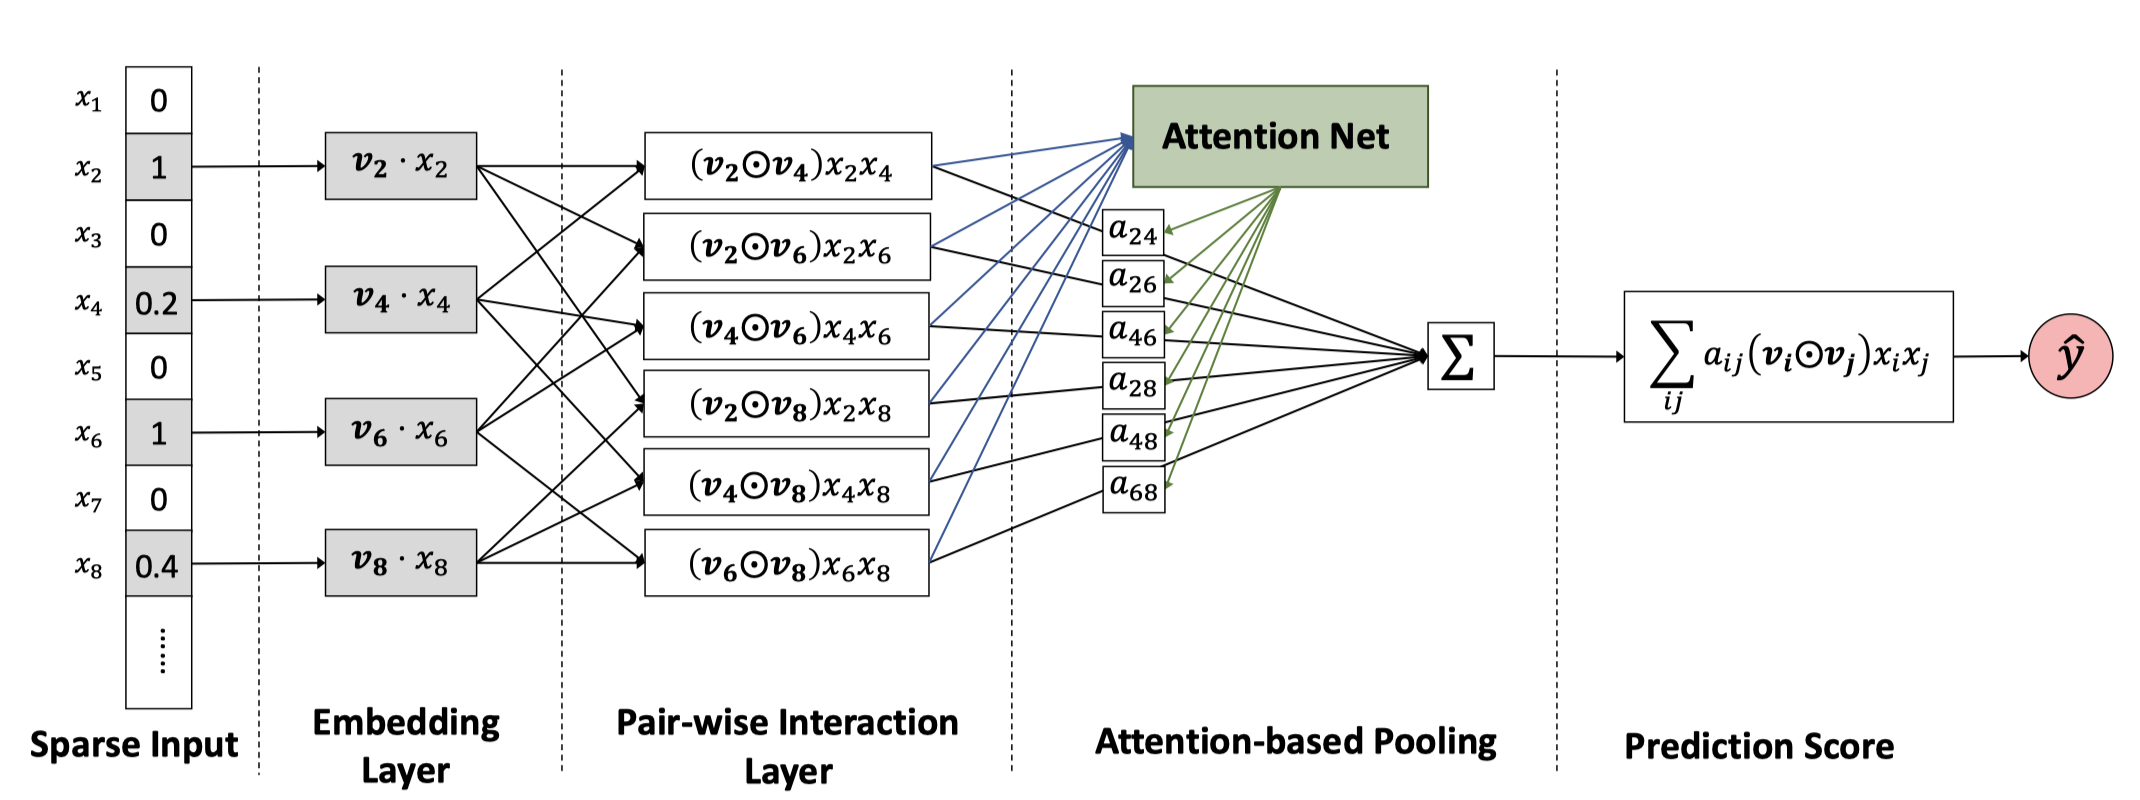

In [370]:
import itertools

def AFM():
    #AFM only use sparce features to do the pair-wise interation and attention, In this case numerical features and gender(only two dim)
    # is not needed in this model, then we could eliminate then 
    
    # define input for AFM about sparce features
    inputs = {
        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    
    embedding_all=[] # allocate all the embbeing layers.    

    # movie_id_embeding
    movid_one_hot=tf.feature_column.categorical_column_with_identity(key="movie_id",num_buckets=1683)
    movie_embedding_layer=tf.feature_column.embedding_column(movid_one_hot,10) #(None,10)
    # user_id_embedding
    userid_one_hot=tf.feature_column.categorical_column_with_identity(key="user_id",num_buckets=944)
    userid_embedding_layer=tf.feature_column.embedding_column(userid_one_hot,10) #embedding layer dim,(None,10)

    embedding_all.append(movie_embedding_layer)
    embedding_all.append(userid_embedding_layer)

    for key, vocab in ALL_FEATURES.items():
        col=tf.feature_column.categorical_column_with_vocabulary_list(key=key,vocabulary_list=vocab)
        embedding_sparce_layer=tf.feature_column.embedding_column(col,10)
        embedding_all.append(embedding_sparce_layer)

    embedding_layers=layers.DenseFeatures(embedding_all)(inputs) ## dim (None.10*20)
    
    #reshape the embedding_lauers
    embedding_layers=tf.reshape(embedding_layers,(-1,10,20)) # dim(None, 10,20)
    embedding_layers=layers.Permute((2,1))(embedding_layers) # change the dimension to dim(None,20,10)
    
    #pair-wise layer, there are 20 embedding layers, we will multiply each of two in 20 embedding layers.
    row=[]
    col=[]
    for x,y in itertools.combinations(range(len(embedding_all)),2):
        # this is to gather the index of these two pair,
        # for example: [1,2,3], there are [1,2],[1,3],[2,3], then row is[1,1,2] and col is [2,3,3]

        row.append(x)    # beacuse the embeding layer list is 20 ,then row length should be 20*19/2=190
        col.append(y)    #col length is the same ,length should be 190
        
    pair_wise_1=tf.gather(embedding_layers,row,axis=1) #extract layers of the corresponding row index
    pair_wise_2=tf.gather(embedding_layers,col,axis=1) #extract layers of the corresponding col index

    pair_wise_layer=layers.Multiply()([pair_wise_1,pair_wise_2]) #(element_wise_product) dim (None,len(embed)*(len(embed)-1)/2,10)
    
    # attention layer 
    def Attention(pair_wise_layer):
        attention_output=layers.Dense(10,activation='relu',use_bias=True)(pair_wise_layer) #dim(None,190,10)
        attention_output=layers.Dense(1)(attention_output) #dim(None,190,1)
        #softmax in the 190 dimension
        attention_output=layers.Softmax(axis=1)(attention_output) #dim(None,190,1)
        
        #element-wise product with pair-wise-layer and attention-output layer
        attention_output=layers.Multiply()([pair_wise_layer,attention_output]) #dim(None,190,10)
        
        attention_output=tf.reduce_sum(attention_output,axis=1) #add the 190 element together and reduce the dimention (None,10)
        return attention_output
    attention_output_layer=Attention(pair_wise_layer) # dim(None,10)
        
    outputs=layers.Dense(1,activation="sigmoid")(attention_output_layer)
    
    medel=keras.Model(inputs=inputs,outputs=outputs)
        
    return medel

In [371]:
afm_model=AFM()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
afm_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])

In [227]:
afm_history=afm_model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30


C:\Users\airfly\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['userHistoryRatingCount', 'userHistoryMeanRating', 'userHistoryStdRating', 'userRatingGoodMovieAveReleasedYear', 'userRatingGoodMovieStdReleasedYear', 'year', 'movieMeanRating', 'movieStd', 'ratingCount', 'age', 'gender', 'User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


2349/2349 [==============================] - 25s 8ms/step - loss: 0.6917 - accuracy: 0.5428 - auc_12: 0.5022 - val_loss: 0.6885 - val_accuracy: 0.5525 - val_auc_12: 0.5404
Epoch 2/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.6873 - accuracy: 0.5541 - auc_12: 0.5597 - val_loss: 0.6855 - val_accuracy: 0.5525 - val_auc_12: 0.5979
Epoch 3/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.6836 - accuracy: 0.5541 - auc_12: 0.6160 - val_loss: 0.6819 - val_accuracy: 0.5525 - val_auc_12: 0.6077
Epoch 4/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.6788 - accuracy: 0.5541 - auc_12: 0.6330 - val_loss: 0.6782 - val_accuracy: 0.5525 - val_auc_12: 0.6208
Epoch 5/30
2349/2349 [==============================] - 16s 7ms/step - loss: 0.6739 - accuracy: 0.5544 - auc_12: 0.6487 - val_loss: 0.6738 - val_accuracy: 0.5549 - val_auc_12: 0.6343
Epoch 6/30
2349/2349 [==============================] - 17s 7ms/step - loss: 0.6678 - accuracy: 

In [228]:
#output the model evaluation

afm_loss,afm_acc,afm_auc=afm_model.evaluate(test_dataset)
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (afm_acc,afm_auc))

653/653 [==============================] - 3s 5ms/step - loss: 0.6077 - accuracy: 0.6787 - auc_12: 0.7313
The evaluation of this model shows the accuracy of this model is 0.679, auc of roc curve is 0.731.


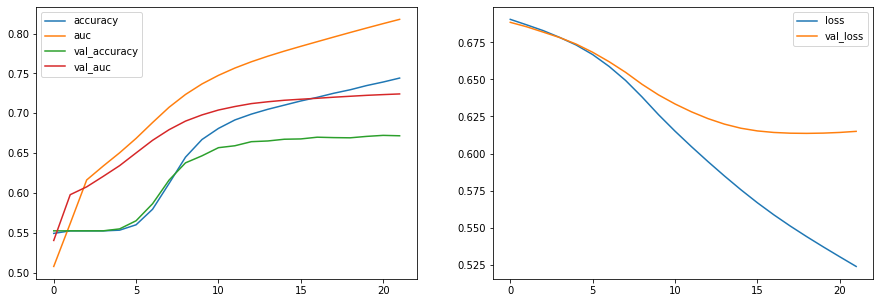

In [229]:
plot_loss_and_metric_values(afm_history,22,12)

#### save model

In [230]:
save_model_and_history_to(afm_model,afm_history,"AFM")

## DIN
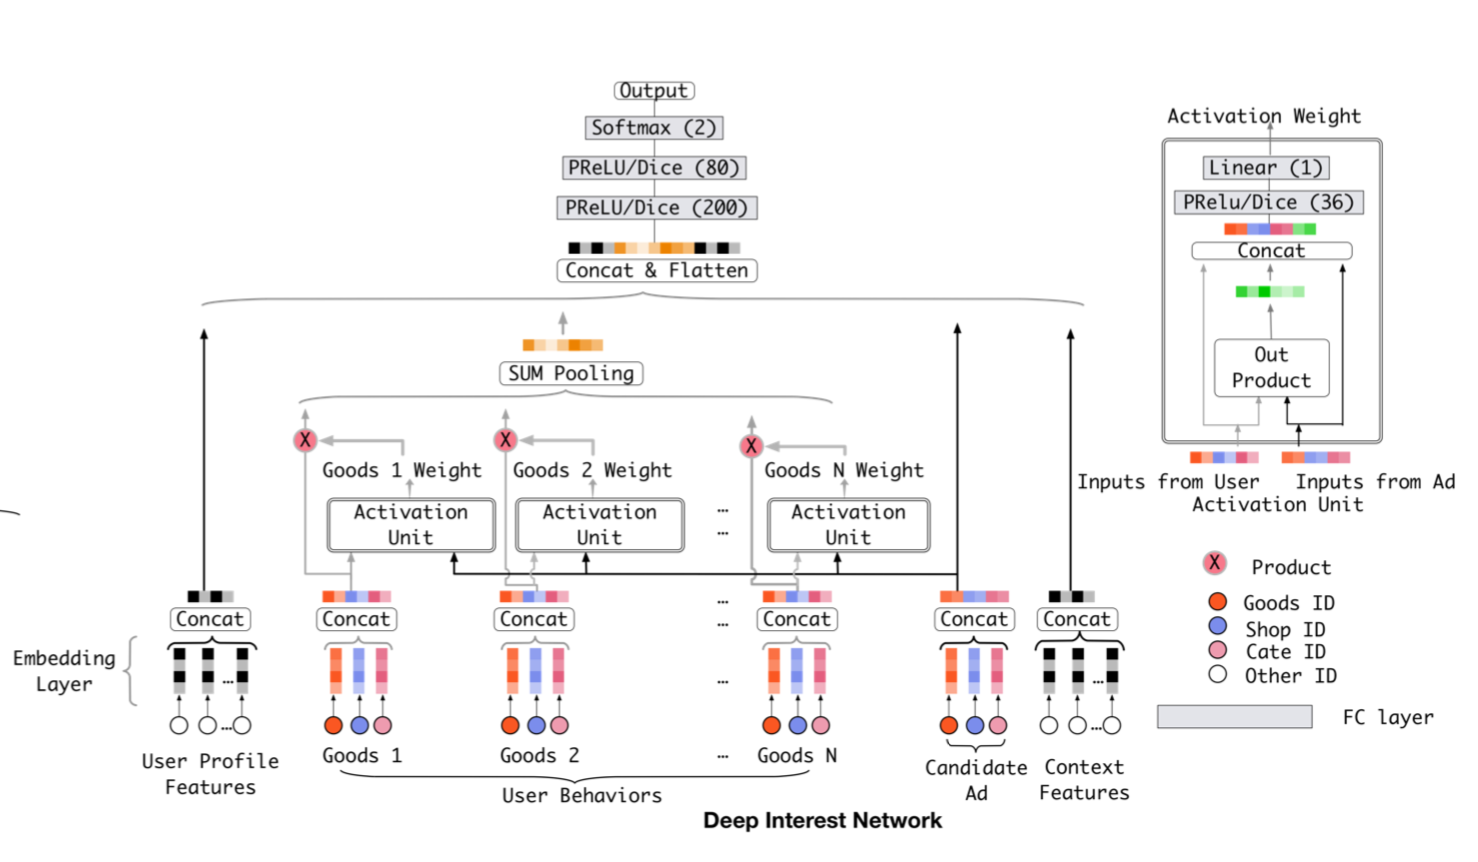

DIN is the short of Deep Interest Network, this model use attention between user behaviour and candidate product to find whether user will be interested in the candidate one. Model contains:
* Input Embedding layers( user features,user behaviours(here is the 5 recent movie user rated and liked, top 5 user liked movie ids), candidate product (movie id),and context features(movie features)
* An attention layer between candidate movie and user behaviours
* sum pooling about the output of attention layer to let the length of all user same
* concatanate layer of user features, attention output, candidate product and contest features
* MLP with PRelu as activation function

In [372]:
def Deep_Interest_Network():
    
    def Attention(user_behaviour_embedding,candidate_embedding):
        # here implement the attention layers,with human behaviours(which is the movie id list) and the candidate movie id
        candidate_repeat_layer=layers.RepeatVector(10)(candidate_embedding) #dim(None,10,10) match with user behaviour for operation
        
        sub_layer=layers.Subtract()([user_behaviour_embedding,candidate_repeat_layer])
        mlutiply_layer=layers.Multiply()([user_behaviour_embedding,candidate_repeat_layer])
        
        #combine them together [k,q,k-q,q*k], the function that the paper use.
        concat_layer=layers.concatenate([user_behaviour_embedding,candidate_repeat_layer,sub_layer,mlutiply_layer])# dim(None,10,10+10+10+10)
        
        #use MLP to output 
        output_layer=layers.Dense(16)(concat_layer)#dim (None,10,16)
        output_layer=layers.PReLU()(output_layer)
        output_layer=layers.Dense(1,activation='sigmoid')(output_layer)#dim (None,10,1)
        
            
        output_layer = tf.keras.layers.Flatten()(output_layer) #dim(None,10) attention number for the 10 lengther user behaviour layer
        output_layer = tf.keras.layers.RepeatVector(10)(output_layer)#dim(None,10(layer number),10(attention number)) 
        output_layer = tf.keras.layers.Permute((2, 1))(output_layer)#change attention dim and layer dim, dim(None,10(attention number),10) 
        output_layer = tf.keras.layers.Multiply()([user_behaviour_embedding, output_layer]) #dim(None,10,10), 
                                                                                            # attention number multiply
                                                                                            # with each user behaviour in the dim 1, 
    
        return output_layer
    
    
    # define input for keras model
    inputs = {
        ## numerical input layers
        'userHistoryMeanRating': tf.keras.layers.Input(name='userHistoryMeanRating', shape=(), dtype='float32'),
        'userHistoryStdRating': tf.keras.layers.Input(name='userHistoryStdRating', shape=(), dtype='float32'),
        'userRatingGoodMovieAveReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieAveReleasedYear', shape=(), dtype='int32'),
        'userRatingGoodMovieStdReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieStdReleasedYear', shape=(), dtype='float32'),
        'year': tf.keras.layers.Input(name='year', shape=(), dtype='int32'),
        'movieMeanRating': tf.keras.layers.Input(name='movieMeanRating', shape=(), dtype='float32'),
        'movieStd': tf.keras.layers.Input(name='movieStd', shape=(), dtype='float32'),

        'ratingCount': tf.keras.layers.Input(name='ratingCount', shape=(), dtype='int32'),
        'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
        'userHistoryRatingCount': tf.keras.layers.Input(name='userHistoryRatingCount', shape=(), dtype='int32'),

        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='string'),
        
        'User_recent_rated_and_liked_movie_id_1': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_1', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_2': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_2', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_3': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_3', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_4': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_4', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_5': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_5', shape=(), dtype='int32'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    
    # initialized 3 base input list,other base ipnut user-behaviour will be carried out next
    user_features=[]
    product_features=[] # the movie features
    candidate_embed=[]  # the movie user will rate
    
    # add the movie_id embedding into candidate_embed list
    movie_id_one_hot=tf.feature_column.categorical_column_with_identity(key="movie_id",num_buckets=1683)
    movieId=tf.feature_column.embedding_column(movie_id_one_hot,10)
    candidate_embed.append(movieId)
    
    # add the user_id embedding into user_feature list
    user_id_one_hot=tf.feature_column.categorical_column_with_identity(key="user_id",num_buckets=944)
    userId=tf.feature_column.embedding_column(user_id_one_hot,10)
    user_features.append(userId)
    
    
    
    Zip_code=final_samples["zip_code"].unique().tolist()
    User_profiles_categorical={ 
         'userLiked_movie_genre_1': movie_types, 
          'userLiked_movie_genre_2': movie_types, 
          'userLiked_movie_genre_3': movie_types, 
          'userLiked_movie_genre_4': movie_types, 
          'userLiked_movie_genre_5': movie_types, 
          "zip_code": Zip_code,
          "occupation":Occupation}
    
    
    context_features_categorical={
         'movieGenre1': movie_types,
          'movieGenre2': movie_types, 
          'movieGenre3': movie_types, 
          'movieGenre4': movie_types, 
          'movieGenre5': movie_types, 
          'movieGenre6': movie_types, 
    }
    
    
    
    #add user categorical features into user_features
    for features,vocab in User_profiles_categorical.items():
        col=tf.feature_column.categorical_column_with_vocabulary_list(key=features,vocabulary_list=vocab )
        cat_embedding=tf.feature_column.embedding_column(col,10)
        user_features.append(cat_embedding)
        
    #add movie categorical features into product_features
    for features,vocab in context_features_categorical.items():
        col=tf.feature_column.categorical_column_with_vocabulary_list(key=features,vocabulary_list=vocab )
        cat_embedding=tf.feature_column.embedding_column(col,10)
        product_features.append(cat_embedding)
    
    #get all the user features including categorical and numerical features
    
    user_numerical_features=[
        'userRatingGoodMovieAveReleasedYear',
        'userRatingGoodMovieStdReleasedYear',
        'userHistoryMeanRating',
        'userHistoryStdRating',
        "ratingCount",
        'age',
        'userHistoryRatingCount',
    ]
    for user_numerical_feature in user_numerical_features:
        user_features.append(tf.feature_column.numeric_column(user_numerical_feature))
    
    user_features.append(gender_indicator)# add gender features (dim=2<10, so don't need to embedding, we add it into features directly)
    
    
    #get all product features including categorical and numerical features 
    product_numerical_features=[
        'year',
        'movieMeanRating',
        'movieStd',
    ]
    for product_numerical_feature in product_numerical_features:
        user_features.append(tf.feature_column.numeric_column(product_numerical_feature))
    
    #user behaviours, the movie ids that user recently rated and liked, and the movie ids user best liked
    user_behaviours=[
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_1",default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_2", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_3", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_4", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_5", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_1", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_2", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_3", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_4", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_5", default_value=0),  
    ]
    #base layer:
    user_behaviours_embed=layers.DenseFeatures(user_behaviours)(inputs) # dim(None,10) here 10 is the length of user behaviours
    
    #embedding layer
    context_embeding_layer=layers.DenseFeatures(product_features)(inputs) # dim(None,6*10) there 6 embedding layere with 10dim
    user_embeding_layer=layers.DenseFeatures(user_features)(inputs) #dim(None,92) there 9 embedding layere with 10dim  and 1 layer(gender) with 2 dim
    candidate_embeding_layer=layers.DenseFeatures(candidate_embed)(inputs) #dim(None,10)
    user_behaviour_embeding_layer=layers.Embedding(input_dim=1683,output_dim=10,mask_zero=True)(user_behaviours_embed)#mask zero #dim(None,10,embeding)
    
    #use attention
    attention_output_layer=Attention(user_behaviour_embeding_layer,candidate_embeding_layer) #dim(None.10,10)
    
    #sum pooling/ element sum in the 1 dimension and reduce dimension, this aimed to let the length of different user behaviour to be total equal.
    user_behaviors_pooled_layers = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_output_layer)# dim(None，10)
    
    #concatence layer
    all_concat=layers.concatenate([user_embeding_layer,user_behaviors_pooled_layers,context_embeding_layer,candidate_embeding_layer])
    
    #MLP layers
    output_layer=layers.Dense(64)(all_concat)#dim (None,64)
    output_layer=layers.PReLU()(output_layer)
    output_layer=layers.Dense(1,activation='sigmoid')(output_layer)#dim (None,1)
    
    model=keras.Model(inputs=inputs,outputs=output_layer)
    
    return model

In [373]:
din_model=Deep_Interest_Network()

In [374]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

din_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])

In [125]:
din_history=din_model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30
2349/2349 [==============================] - 21s 6ms/step - loss: 0.6258 - accuracy: 0.6511 - auc_4: 0.6970 - val_loss: 0.5788 - val_accuracy: 0.6997 - val_auc_4: 0.7575
Epoch 2/30
2349/2349 [==============================] - 13s 5ms/step - loss: 0.5662 - accuracy: 0.7076 - auc_4: 0.7694 - val_loss: 0.5688 - val_accuracy: 0.7091 - val_auc_4: 0.7682
Epoch 3/30
2349/2349 [==============================] - 12s 5ms/step - loss: 0.5559 - accuracy: 0.7152 - auc_4: 0.7796 - val_loss: 0.5643 - val_accuracy: 0.7120 - val_auc_4: 0.7729
Epoch 4/30
2349/2349 [==============================] - 12s 5ms/step - loss: 0.5489 - accuracy: 0.7213 - auc_4: 0.7865 - val_loss: 0.5624 - val_accuracy: 0.7134 - val_auc_4: 0.7750
Epoch 5/30
2349/2349 [==============================] - 13s 5ms/step - loss: 0.5440 - accuracy: 0.7239 - auc_4: 0.7913 - val_loss: 0.5611 - val_accuracy: 0.7128 - val_auc_4: 0.7763
Epoch 6/30
2349/2349 [==============================] - 13s 5ms/step - loss: 0.5398 - accuracy:

In [126]:
#output the model evaluation
din_loss,din_acc,din_auc=din_model.evaluate(test_dataset)vbn
print("The evaluation of this model shows the accuracy of this model is %.3f, auc of roc curve is %.3f." % (din_acc,din_auc))

653/653 [==============================] - 3s 4ms/step - loss: 0.5623 - accuracy: 0.7094 - auc_4: 0.7790
The evaluation of this model shows the accuracy of this model is 0.709, auc of roc curve is 0.779.


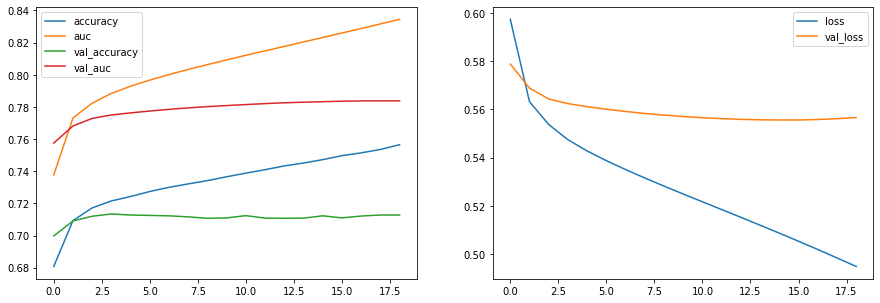

In [129]:
plot_loss_and_metric_values(din_history,19,4)

### save model

In [130]:
save_model_and_history_to(din_model,din_history,"Deep_Interst_Network")

### DIEN
* DIEN need sequence user behaviours rather than user behaviours,which means "user LikedTop5_movie_id" and "User_recent_rated_and_liked_movie_id" can not set as one like the DIN did. But each of them is sequential ,then I just use two interesting and evolving layer to do this model.each of them will output a final state and I concatenate them in the final concatenate layer, so basically my model just used interesting layer twice.
* beacuse the time limitation, auxillary loss was not carried out because I don't have time to do the history negative list.

In [338]:
Hidden_size=10*2
Embedding_size=10
Recent_Movie_List=5

def Attention(interest_layer,candidate_embedding):#here user_behaviour_embedding should be interest layer.
    # here implement the attention layers,with human behaviours(which is the movie id list) and the candidate movie id
    candidate_repeat_layer=layers.RepeatVector(Recent_Movie_List)(candidate_embedding) #dim(None,5,10) match with user behaviour for operation

    facts_size = interest_layer.get_shape().as_list()[-1]  #hidden size of the RNN layer,Hidden_size
    querry_size = candidate_embedding.get_shape().as_list()[-1] #candidate embedding size
    candidate_repeat_layer = layers.Dense(facts_size)(candidate_repeat_layer)
    candidate_repeat_layer=layers.PReLU()(candidate_repeat_layer)
    sub_layer=layers.Subtract()([interest_layer,candidate_repeat_layer])
    mlutiply_layer=layers.Multiply()([interest_layer,candidate_repeat_layer])

    #combine them together [k,q,k-q,q*k], the function that the paper use.
    concat_layer=layers.concatenate([interest_layer,candidate_repeat_layer,sub_layer,mlutiply_layer])# dim(None,5,20+20+20+20)

    #use MLP to output 
    output_layer=layers.Dense(16)(concat_layer)#dim (None,5,16)
    output_layer=layers.PReLU()(output_layer)
    output_layer=layers.Dense(1,activation='sigmoid')(output_layer)#dim (None,5,1)


    output_layer = tf.keras.layers.Flatten()(output_layer) #dim(None,5) attention number for the 5 lengther user behaviour layer
    output_layer = tf.keras.layers.RepeatVector(Hidden_size)(output_layer)#dim(None,20(embedding number),5(attention number)) 
    output_layer = tf.keras.layers.Permute((2, 1))(output_layer)#change attention dim and layer dim, dim(None,5(attention number),20) 
    output_layer = tf.keras.layers.Multiply()([interest_layer, output_layer]) #dim(None,5,20), 
                                                                                                # attention number multiply
                                                                                                # with each user behaviour in the dim 1, 

    return output_layer

In [350]:
class DoubleDense(layers.Layer):
    def __init__(self,units):
        super(DoubleDense,self).__init__()
        self.hasBias=layers.Dense(units,activation=None, use_bias=True)
        self.noBias=layers.Dense(units,activation=None, use_bias=False)
    def call(self,inp,state,r=None):
        if r is None:
            return keras.activations.sigmoid(self.hasBias(inp)+self.noBias(state))
        else:
            return keras.activations.tanh(self.hasBias(inp)+self.noBias(state)*r)   
    
class AUGRU(layers.Layer):
    def __init__(self,units):
        super(AUGRU,self).__init__()
        self.u_gate=DoubleDense(units)
        self.r_gate=DoubleDense(units)
        self.h_latent=DoubleDense(units)
        self.flatten=layers.Flatten()
        
    def call(self,interest_layer,state,interest_attention_layer):
        #state are 2 dimension
        # interest_layer and interest_attention are 3 dim
        interest_layer_list=tf.split(interest_layer,num_or_size_splits=Recent_Movie_List,axis=1)
        att_layer_list=tf.split(interest_attention_layer,num_or_size_splits=Recent_Movie_List,axis=1)
        for i in range(Recent_Movie_List):
            interset_input=self.flatten(interest_layer_list[i]) #reduce to 2 dim
            att_input=self.flatten(att_layer_list[i]) #reduce to 2 dim
            u=self.u_gate(interset_input,state)
            r=self.r_gate(interset_input,state)
            h=self.h_latent(interset_input,state,r)
            u=u*att_input
            state=(1-u)*state+u*h
            
        return state

In [351]:
def DIEN(): 
    
    # define input for keras model
    inputs = {
        ## numerical input layers
        'userHistoryMeanRating': tf.keras.layers.Input(name='userHistoryMeanRating', shape=(), dtype='float32'),
        'userHistoryStdRating': tf.keras.layers.Input(name='userHistoryStdRating', shape=(), dtype='float32'),
        'userRatingGoodMovieAveReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieAveReleasedYear', shape=(), dtype='int32'),
        'userRatingGoodMovieStdReleasedYear': tf.keras.layers.Input(name='userRatingGoodMovieStdReleasedYear', shape=(), dtype='float32'),
        'year': tf.keras.layers.Input(name='year', shape=(), dtype='int32'),
        'movieMeanRating': tf.keras.layers.Input(name='movieMeanRating', shape=(), dtype='float32'),
        'movieStd': tf.keras.layers.Input(name='movieStd', shape=(), dtype='float32'),

        'ratingCount': tf.keras.layers.Input(name='ratingCount', shape=(), dtype='int32'),
        'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
        'userHistoryRatingCount': tf.keras.layers.Input(name='userHistoryRatingCount', shape=(), dtype='int32'),

        ## categorical input layers
        'movie_id': tf.keras.layers.Input(name='movie_id', shape=(), dtype='int32'),
        'user_id': tf.keras.layers.Input(name='user_id', shape=(), dtype='int32'),
        'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='string'),
        
        'User_recent_rated_and_liked_movie_id_1': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_1', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_2': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_2', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_3': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_3', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_4': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_4', shape=(), dtype='int32'),
        'User_recent_rated_and_liked_movie_id_5': tf.keras.layers.Input(name='User_recent_rated_and_liked_movie_id_5', shape=(), dtype='int32'),
        
        
        'userLiked_movie_genre_1': tf.keras.layers.Input(name='userLiked_movie_genre_1', shape=(), dtype='string'),
        'userLiked_movie_genre_2': tf.keras.layers.Input(name='userLiked_movie_genre_2', shape=(), dtype='string'),
        'userLiked_movie_genre_3': tf.keras.layers.Input(name='userLiked_movie_genre_3', shape=(), dtype='string'),
        'userLiked_movie_genre_4': tf.keras.layers.Input(name='userLiked_movie_genre_4', shape=(), dtype='string'),
        'userLiked_movie_genre_5': tf.keras.layers.Input(name='userLiked_movie_genre_5', shape=(), dtype='string'),
        'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
        'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
        'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
        'movieGenre4': tf.keras.layers.Input(name='movieGenre4', shape=(), dtype='string'),
        'movieGenre5': tf.keras.layers.Input(name='movieGenre5', shape=(), dtype='string'),
        'movieGenre6': tf.keras.layers.Input(name='movieGenre6', shape=(), dtype='string'),
        'userLikedTop5_movie_id_1': tf.keras.layers.Input(name='userLikedTop5_movie_id_1', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_2': tf.keras.layers.Input(name='userLikedTop5_movie_id_2', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_3': tf.keras.layers.Input(name='userLikedTop5_movie_id_3', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_4': tf.keras.layers.Input(name='userLikedTop5_movie_id_4', shape=(), dtype='int32'),
        'userLikedTop5_movie_id_5': tf.keras.layers.Input(name='userLikedTop5_movie_id_5', shape=(), dtype='int32'),
        'zip_code': tf.keras.layers.Input(name='zip_code', shape=(), dtype='string'),
        'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
    }
    
    # initialized 3 base input list,other base ipnut user-behaviour will be carried out next
    user_features=[]
    product_features=[] # the movie features
    candidate_embed=[]  # the movie user will rate
    
    # add the movie_id embedding into candidate_embed list
    movie_id_one_hot=tf.feature_column.categorical_column_with_identity(key="movie_id",num_buckets=1683)
    movieId=tf.feature_column.embedding_column(movie_id_one_hot,10)
    candidate_embed.append(movieId)
    
    # add the user_id embedding into user_feature list
    user_id_one_hot=tf.feature_column.categorical_column_with_identity(key="user_id",num_buckets=944)
    userId=tf.feature_column.embedding_column(user_id_one_hot,10)
    user_features.append(userId)
    
    
    
    Zip_code=final_samples["zip_code"].unique().tolist()
    User_profiles_categorical={ 
         'userLiked_movie_genre_1': movie_types, 
          'userLiked_movie_genre_2': movie_types, 
          'userLiked_movie_genre_3': movie_types, 
          'userLiked_movie_genre_4': movie_types, 
          'userLiked_movie_genre_5': movie_types, 
          "zip_code": Zip_code,
          "occupation":Occupation,
    }
    
    
    context_features_categorical={
         'movieGenre1': movie_types,
          'movieGenre2': movie_types, 
          'movieGenre3': movie_types, 
          'movieGenre4': movie_types, 
          'movieGenre5': movie_types, 
          'movieGenre6': movie_types,
    }
    
    
    
    #add user categorical features into user_features
    for features,vocab in User_profiles_categorical.items():
        col=tf.feature_column.categorical_column_with_vocabulary_list(key=features,vocabulary_list=vocab )
        cat_embedding=tf.feature_column.embedding_column(col,10)
        user_features.append(cat_embedding)
        
    #add movie categorical features into product_features
    for features,vocab in context_features_categorical.items():
        col=tf.feature_column.categorical_column_with_vocabulary_list(key=features,vocabulary_list=vocab )
        cat_embedding=tf.feature_column.embedding_column(col,10)
        product_features.append(cat_embedding)
    
    #get all the user features including categorical and numerical features
    
    user_numerical_features=[
        'userRatingGoodMovieAveReleasedYear',
        'userRatingGoodMovieStdReleasedYear',
        'userHistoryMeanRating',
        'userHistoryStdRating',
        "ratingCount",
        'age',
        'userHistoryRatingCount',
    ]
    for user_numerical_feature in user_numerical_features:
        user_features.append(tf.feature_column.numeric_column(user_numerical_feature))
    
    user_features.append(gender_indicator)# add gender features (dim=2<10, so don't need to embedding, we add it into features directly)
    
    
    #get all product features including categorical and numerical features 
    product_numerical_features=[
        'year',
        'movieMeanRating',
        'movieStd',
    ]
    for product_numerical_feature in product_numerical_features:
        user_features.append(tf.feature_column.numeric_column(product_numerical_feature))
    
    #user behaviours, the movie ids that user recently rated and liked, and the movie ids user best liked
    user_behaviours=[
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_1",default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_2", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_3", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_4", default_value=0),
        tf.feature_column.numeric_column("User_recent_rated_and_liked_movie_id_5", default_value=0), 
    ]
    
    user_behaviours_2=[
        tf.feature_column.numeric_column("userLikedTop5_movie_id_1",default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_2", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_3", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_4", default_value=0),
        tf.feature_column.numeric_column("userLikedTop5_movie_id_5", default_value=0), 
    ]
    #base layer:
    user_behaviours_embed=layers.DenseFeatures(user_behaviours)(inputs) # dim(None,10) here 10 is the length of user behaviours
    user_behaviours_embed_2=layers.DenseFeatures(user_behaviours_2)(inputs)
    #embedding layer
    context_embeding_layer=layers.DenseFeatures(product_features)(inputs) # dim(None,6*10) there 6 embedding layere with 10dim
    user_embeding_layer=layers.DenseFeatures(user_features)(inputs) #dim(None,92) there 9 embedding layere with 10dim  and 1 layer(gender) with 2 dim
    candidate_embeding_layer=layers.DenseFeatures(candidate_embed)(inputs) #dim(None,10)
    user_behaviour_embeding_layer=layers.Embedding(input_dim=1683,output_dim=10,mask_zero=True)(user_behaviours_embed)#mask zero #dim(None,5,embeding)
    user_behaviour_embeding_layer2=layers.Embedding(input_dim=1683,output_dim=10,mask_zero=True)(user_behaviours_embed_2)#mask zero #dim(None,5,embeding)

    
    
    #Interst layer1
    interest_layer,_=layers.GRU(Hidden_size,return_sequences=True,return_state=True)(user_behaviour_embeding_layer) #dim(None,5,20)
    interest_attention_layer=Attention(interest_layer,candidate_embeding_layer) #dim(None,5,20)
    
    #Interst layer2
    interest_layer_2,_=layers.GRU(Hidden_size,return_sequences=True,return_state=True)(user_behaviour_embeding_layer2) #dim(None,5,20)
    interest_attention_layer_2=Attention(interest_layer_2,candidate_embeding_layer) #dim(None,5,20)
    
    initial_state=tf.zeros_like(interest_attention_layer[:,0,:])
    # interst evolve layer_1
    evolve_layer=AUGRU(Hidden_size)(interest_layer,initial_state,interest_attention_layer)
    # interst evolve layer_1
    evolve_layer_2=AUGRU(Hidden_size)(interest_layer_2,initial_state,interest_attention_layer_2)
    #concatenate layer
    concat=layers.concatenate([evolve_layer,evolve_layer_2,candidate_embeding_layer,context_embeding_layer,user_embeding_layer],axis=1)
    
    #MLP
    output_layer=layers.Dense(128)(concat)
    output_layer=layers.PReLU()(output_layer)
    output_layer=layers.Dense(64)(output_layer)
    output_layer=layers.PReLU()(output_layer)
    output_layer=layers.Dense(1,activation="sigmoid")(output_layer)
    
    model=keras.Model(inputs=inputs,outputs=output_layer)
    
    return model

In [352]:
DIEN_model=DIEN()
DIEN_model
# optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

DIEN_model.compile(loss="binary_crossentropy",
                           optimizer=optimizer,
                           metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC")])

In [353]:
dien_history=DIEN_model.fit(train_dataset,epochs=30,validation_data=valid_dataset,callbacks=[es])

Epoch 1/30
2349/2349 [==============================] - 57s 17ms/step - loss: 0.5872 - accuracy: 0.6848 - auc_25: 0.7432 - val_loss: 0.5695 - val_accuracy: 0.7074 - val_auc_25: 0.7665
Epoch 2/30
2349/2349 [==============================] - 32s 14ms/step - loss: 0.5549 - accuracy: 0.7146 - auc_25: 0.7797 - val_loss: 0.5621 - val_accuracy: 0.7112 - val_auc_25: 0.7732
Epoch 3/30
2349/2349 [==============================] - 35s 15ms/step - loss: 0.5435 - accuracy: 0.7228 - auc_25: 0.7903 - val_loss: 0.5607 - val_accuracy: 0.7155 - val_auc_25: 0.7748
Epoch 4/30
2349/2349 [==============================] - 36s 16ms/step - loss: 0.5367 - accuracy: 0.7280 - auc_25: 0.7969 - val_loss: 0.5600 - val_accuracy: 0.7147 - val_auc_25: 0.7757
Epoch 5/30
2349/2349 [==============================] - 36s 15ms/step - loss: 0.5308 - accuracy: 0.7323 - auc_25: 0.8025 - val_loss: 0.5596 - val_accuracy: 0.7153 - val_auc_25: 0.7765
Epoch 6/30
2349/2349 [==============================] - 36s 15ms/step - loss: 0.

In [354]:
DIEN_model.evaluate(test_dataset)

653/653 [==============================] - 4s 6ms/step - loss: 0.5600 - accuracy: 0.7119 - auc_25: 0.7798


[0.5599667429924011, 0.7118990421295166, 0.7798115015029907]

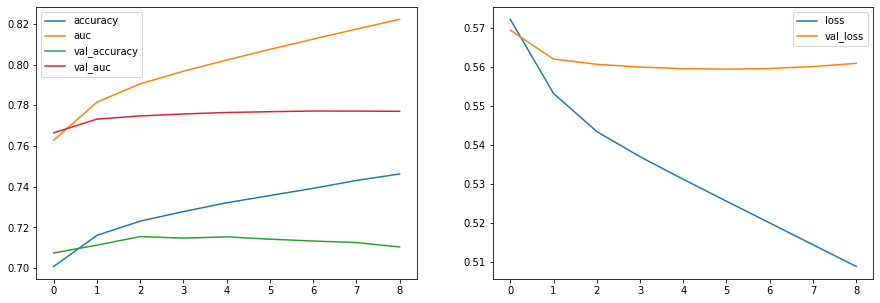

In [355]:
plot_loss_and_metric_values(dien_history,9,25)

In [356]:
save_model_and_history_to(DIEN_model,dien_history,"DIEN")

## Model Analysis 

Above we implement 6 different classical models in Recommendation system with Deeplearning,The perdormance of each model shows bellow:

In [375]:
#Reload_model
model_EMBED_MLP,history_EMBED_MLP=reload_model_and_history("EMBED_MLP",MyEMBED_MLP_Model,test_dataset)
#get the acc and auc
EMBED_MLP_loss,EMBED_MLP_acc,EMBED_MLP_auc=model_EMBED_MLP.evaluate(test_dataset)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
653/653 [==============================] - 13s 9ms/step - loss: 0.7037 - accuracy: 0.5151 - auc_33: 0.5052
Consider rewriting this model with the Functional API.


653/653 [==============================] - 5s 4ms/step - loss: 0.6745 - accuracy: 0.6863 - auc_33: 0.7439


In [376]:
#Reload_model_deep_crossing
model_deep_crossing,history_deep_crossing=reload_model_and_history("Deep_Crossing",Deep_Crossing,test_dataset,dim_stack)
#get the acc and auc
dnc_loss,dnc_acc,dnc_auc=model_deep_crossing.evaluate(test_dataset)

C:\Users\airfly\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


653/653 [==============================] - 5s 5ms/step - loss: 0.5710 - accuracy: 0.7014 - auc_34: 0.7669


In [377]:
#Reload_model_nerual_CF
model_Nerual_CF,history_Nerual_CF=reload_model_and_history("Nerual_CF",NerualCF,test_dataset,[movieId_mf_64,userId_mf_64,0.8,regularizers.l2(1.2)])
#get the acc and aucre
Nerual_CF_loss,Nerual_CF_acc,Nerual_CF_auc=model_Nerual_CF.evaluate(test_dataset)

C:\Users\airfly\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['userHistoryRatingCount', 'userHistoryMeanRating', 'userHistoryStdRating', 'userLikedTop5_movie_id_1', 'userLikedTop5_movie_id_2', 'userLikedTop5_movie_id_3', 'userLikedTop5_movie_id_4', 'userLikedTop5_movie_id_5', 'userLiked_movie_genre_1', 'userLiked_movie_genre_2', 'userLiked_movie_genre_3', 'userLiked_movie_genre_4', 'userLiked_movie_genre_5', 'userRatingGoodMovieAveReleasedYear', 'userRatingGoodMovieStdReleasedYear', 'year', 'movieMeanRating', 'movieStd', 'ratingCount', 'movieGenre1', 'movieGenre2', 'movieGenre3', 'movieGenre4', 'movieGenre5', 'movieGenre6', 'age', 'gender', 'occupation', 'zip_code', 'User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any m

653/653 [==============================] - 3s 3ms/step - loss: 0.5792 - accuracy: 0.7065 - auc_35: 0.7696


In [378]:
#Reload_model_wide_and_deep
model_wad,history_wad=reload_model_and_history("Wide_and_deep",Wide_And_Deep,test_dataset,None)
#get the acc and aucre
wad_loss,wad_acc,wad_auc=model_wad.evaluate(test_dataset)

653/653 [==============================] - 8s 9ms/step - loss: 0.5619 - accuracy: 0.7080 - auc_36: 0.7751


In [390]:
#Reload_model_AFM
model_afm,history_afm=reload_model_and_history("AFM",AFM,test_dataset,None)
#get the acc and aucre
afm_loss,afm_acc,afm_auc=model_afm.evaluate(test_dataset)

C:\Users\airfly\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['userHistoryRatingCount', 'userHistoryMeanRating', 'userHistoryStdRating', 'userRatingGoodMovieAveReleasedYear', 'userRatingGoodMovieStdReleasedYear', 'year', 'movieMeanRating', 'movieStd', 'ratingCount', 'age', 'gender', 'User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


653/653 [==============================] - 7s 7ms/step - loss: 0.6077 - accuracy: 0.6787 - auc_40: 0.7313


In [379]:
#Reload_model_DIN
model_din,history_din=reload_model_and_history("Deep_Interst_Network",Deep_Interest_Network,test_dataset,None)
#get the acc and aucre
din_loss,din_acc,din_auc=model_din.evaluate(test_dataset)

653/653 [==============================] - 5s 5ms/step - loss: 0.5623 - accuracy: 0.7094 - auc_37: 0.7790


In [357]:
#Reload_model_DIEN
model_dien,history_dien=reload_model_and_history("DIEN",DIEN,test_dataset,None)
#get the acc and auc
dien_loss,dien_acc,dien_auc=model_dien.evaluate(test_dataset)

653/653 [==============================] - 8s 6ms/step - loss: 0.5600 - accuracy: 0.7119 - auc_26: 0.7798


In [358]:
perform=pd.DataFrame(np.zeros((2,7)),index=['accuracy','AUC'],columns=["Base_Embedding_MLP","Deep&Crossing","Neural_CF","Wide&Deep","AFM","DIN","DIEN"])

In [383]:
perform["Base_Embedding_MLP"]=[EMBED_MLP_acc,EMBED_MLP_auc]
perform["Deep&Crossing"]=[dnc_acc,dnc_auc]
perform["Neural_CF"]=[Nerual_CF_acc,Nerual_CF_auc]
perform["Wide&Deep"]=[wad_acc,wad_auc]
perform["AFM"]=[afm_acc,afm_auc]
perform["DIN"]=[din_acc,din_auc]
perform["DIEN"]=[dien_acc,dien_auc]
perform.reset_index(inplace=True)
perform

,index,Base_Embedding_MLP,Deep&Crossing,Neural_CF,Wide&Deep,AFM,DIN,DIEN
0,accuracy,0.686303,0.701425,0.706535,0.707965,0.678690,0.709447,0.711899
1,AUC,0.743945,0.766894,0.769644,0.775110,0.731273,0.778979,0.779812


In [384]:
perform_melt=pd.melt(perform,id_vars=["index"])
perform_melt.columns=["metrics","Model","Value"]

(0, 0.9)

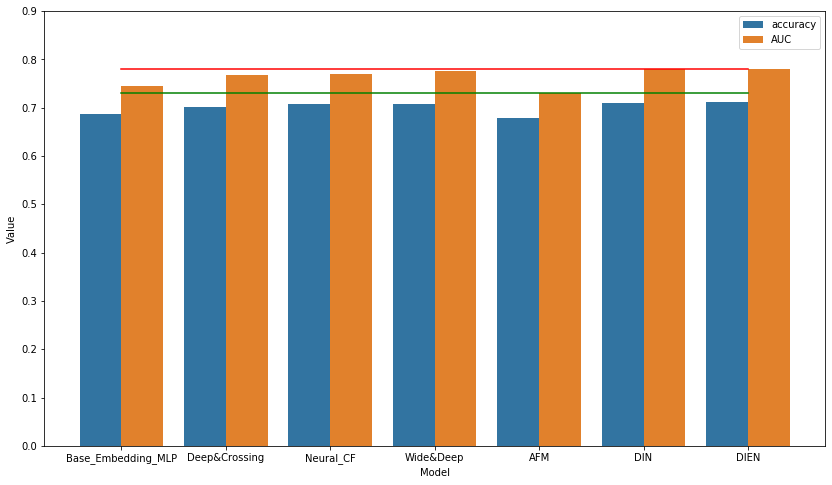

In [386]:
plt.figure(figsize=(14,8))
sns.barplot(x="Model",y="Value",hue="metrics",data=perform_melt)
sns.lineplot(x=["Base_Embedding_MLP","Deep&Crossing","Neural_CF","Wide&Deep","AFM","DIN","DIEN"],y=perform["DIEN"][1],color="r")
sns.lineplot(x=["Base_Embedding_MLP","Deep&Crossing","Neural_CF","Wide&Deep","AFM","DIN","DIEN"],y=perform["AFM"][1],color="green")
plt.ylim(0,0.9)

The performance of each model are shown above, we could see that the best model is DIN, its' AUC is 0.779, which is 6.5% larger than the AUC in worst model, which is AFM of 0.731. The Rank of the performance of these models are **DIN>Wide&Deep>Nerual_CF>Deep&Crossing>Base_Embedding_MLP>AFM**. Although the AFM use attention method, since it is actually an Factorization machine method, it did not get much more information about the features, so it is the worst

### ROC curve

In [401]:
from sklearn.metrics import roc_curve
probas_base=model_EMBED_MLP.predict(test_dataset)
probas_dc=model_deep_crossing.predict(test_dataset)
probas_ncf=model_Nerual_CF.predict(test_dataset)
probas_wad=model_wad.predict(test_dataset)
probas_afm=model_afm.predict(test_dataset)
probas_din=model_din.predict(test_dataset)
probas_dien=model_dien.predict(test_dataset)

In [397]:
base_fpr, base_tpr, _ = roc_curve(y_test, probas_base)
dc_fpr, dc_tpr, _ = roc_curve(y_test, probas_dc)
ncf_fpr, ncf_tpr, _ = roc_curve(y_test, probas_ncf)
wad_fpr, wad_tpr, _ = roc_curve(y_test, probas_wad)
afm_fpr, afm_tpr, _ = roc_curve(y_test, probas_afm)
din_fpr, din_tpr, _ = roc_curve(y_test, probas_din)
dien_fpr, dien_tpr, _ = roc_curve(y_test, probas_dien)

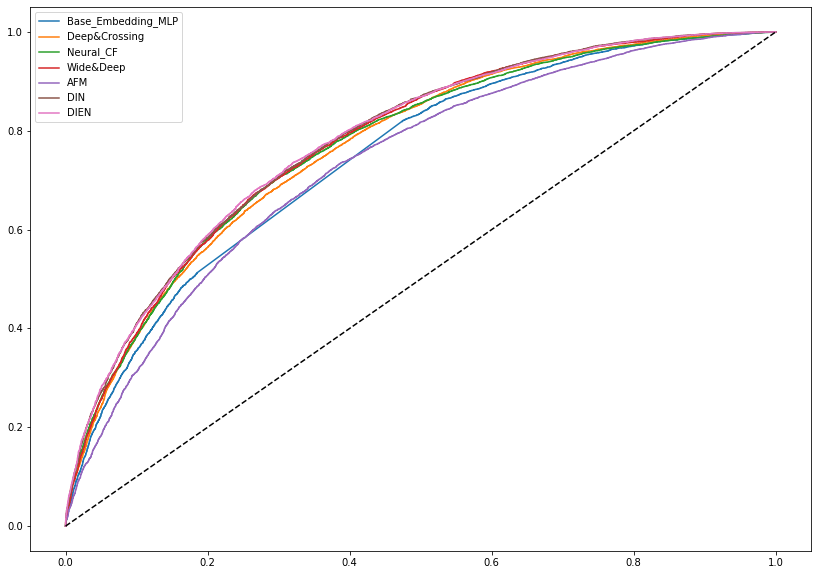

In [400]:
# plot the roc curve for the model
plt.figure(figsize=(14,10))
plt.plot(base_fpr, base_tpr)
plt.plot(dc_fpr, dc_tpr)
plt.plot(ncf_fpr, ncf_tpr)
plt.plot(wad_fpr, wad_tpr)
plt.plot(afm_fpr, afm_tpr)
plt.plot(din_fpr, din_tpr)
plt.plot(dien_fpr, dien_tpr)
plt.plot([0,1],[0,1],linestyle='--',color='black')
plt.legend(["Base_Embedding_MLP","Deep&Crossing","Neural_CF","Wide&Deep","AFM","DIN","DIEN"])

The above shows the ROC curve, we could also see that AFM is whe worst model and base_embedding_MLP is the second worse model.

# Real life recommendation movies that were not seen by user

Here we will self-made a dataset for some user id with a list of the movie that he or she did not see before and use our recommendation model to recommend about 5 movies. The recommendation movie will be ranked as the prediction probablity by the models, more close to 1 the movie will more recommended.
____________________________________
For example, user 405 already saw 736 movies out of 1682 movies, however, she still didn't see the rest 946 movies, So we will build a dataset with user id=405 and movie id is the rest 946 movie ids, then we feed thos dataset into models to see the top 5 movies that model think user 405 will like. It is the simulation of the reality, which means this is no any label for us to validate the prediction. But made us really excited to do the real job.
* we will choose people in the top 10 rating means table.
* we wiil choose people in the least 10 rating means table also.

In [1015]:
movie_features_data=pd.read_csv("train_local/movie_features.csv")
movie_features_data

,movie id,movie title,year,movieMeanRating,movieStd,ratingCount,movieGenre1,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6
0,1,Toy Story (1995),1995,3.878319,0.927897,452,Animation,Children's,Comedy,0,0,0
1,2,GoldenEye (1995),1995,3.206107,0.966497,131,Action,Adventure,Thriller,0,0,0
2,3,Four Rooms (1995),1995,3.033333,1.212760,90,Thriller,0,0,0,0,0
3,4,Get Shorty (1995),1995,3.550239,0.965069,209,Action,Comedy,Drama,0,0,0
4,5,Copycat (1995),1995,3.302326,0.946446,86,Crime,Drama,Thriller,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998,1.000000,0.000000,1,Drama,0,0,0,0,0
1678,1679,B. Monkey (1998),1998,3.000000,0.000000,1,Romance,Thriller,0,0,0,0
1679,1680,Sliding Doors (1998),1998,2.000000,0.000000,1,Drama,Romance,0,0,0,0
1680,1681,You So Crazy (1994),1994,3.000000,0.000000,1,Comedy,0,0,0,0,0


In [1016]:
def get_not_see_movie_ids(user__id):
    user_characteristics=final_samples[final_samples["user_id"]==user__id]
    movie_saw_list=user_characteristics["movie_id"].unique().tolist()
    
    movie_all_list=movie_features_data["movie id"].unique().tolist()
    return list(set(movie_all_list)-set(movie_saw_list))

In [1017]:
def get_data_of_userids(userids):
    x=pd.DataFrame()
    for userid in userids:
        dic={}
        dic[userid]=get_not_see_movie_ids(userid)
        y=pd.DataFrame(dic)
        x=x.append(y)
    #gather the index to the list
    data_not_see=pd.melt(x)

    # eliminate the null value
    data_not_see=data_not_see[~data_not_see["value"].isnull()]
    data_not_see.columns=["user_id","movie_id"]
    data_not_see["movie_id"]=data_not_see["movie_id"].astype("int64")
    return data_not_see

### combine the user id with the movie ids that they didn't see before

In [1018]:
# get our dataset that user didnot see before.
data_not_see_top10=get_data_of_userids(top_10_user_rating_mean["user_id"])
data_not_see_least10=get_data_of_userids(tail_10_user_rating_mean["user_id"])
data_not_see=data_not_see_top10.append(data_not_see_least10).reset_index(drop=True)
data_not_see

,user_id,movie_id
0,118,1
1,118,2
2,118,3
3,118,4
4,118,6
...,...,...
31336,865,1678
31337,865,1679
31338,865,1680
31339,865,1681


### user behaviour and feature extraction

In [1019]:
# then we use the newest user_behaviour and the movie features of that movie id to combine our new dataset
user_newest_status=final_samples.sort_values(by="timestamp").groupby("user_id").tail(1)

user_behaviour_feature=["user_id","userHistoryRatingCount","userHistoryMeanRating","userHistoryStdRating",
               "userLikedTop5_movie_id_1","userLikedTop5_movie_id_2","userLikedTop5_movie_id_3","userLikedTop5_movie_id_4","userLikedTop5_movie_id_5",
               "userRatingGoodMovieAveReleasedYear","userRatingGoodMovieStdReleasedYear",
                "userLiked_movie_genre_1",
                "userLiked_movie_genre_2",
                "userLiked_movie_genre_3",
                "userLiked_movie_genre_4",
                "userLiked_movie_genre_5",
                "User_recent_rated_and_liked_movie_id_1",
                "User_recent_rated_and_liked_movie_id_2",
                "User_recent_rated_and_liked_movie_id_3",
                "User_recent_rated_and_liked_movie_id_4",
                "User_recent_rated_and_liked_movie_id_5","age",
                 "gender", "occupation",  "zip_code"]

# extract the user behaviour and the user features from the dataFrame
user_behaviour_not_see_movie=user_newest_status[user_behaviour_feature][user_newest_status[user_behaviour_feature]["user_id"].isin(data_not_see["user_id"].unique().tolist())]
user_behaviour_not_see_movie.reset_index(drop=True,inplace=True)
user_behaviour_not_see_movie

,user_id,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,userLikedTop5_movie_id_4,userLikedTop5_movie_id_5,userRatingGoodMovieAveReleasedYear,...,userLiked_movie_genre_5,User_recent_rated_and_liked_movie_id_1,User_recent_rated_and_liked_movie_id_2,User_recent_rated_and_liked_movie_id_3,User_recent_rated_and_liked_movie_id_4,User_recent_rated_and_liked_movie_id_5,age,gender,occupation,zip_code
0,118,-0.319065,2.189532,-0.886154,919,164,234,320,288,0.082470,...,Sci-Fi,288,320,234,164,919,-1.034316,M,administrator,90210
1,181,3.328993,-4.327439,-0.511603,25,237,288,270,289,0.142606,...,Sci-Fi,974,280,7,237,476,-0.600911,M,executive,21218
2,685,-0.833018,-3.176170,-0.789241,0,0,0,0,0,-9.860056,...,0,0,0,0,0,0,-0.080825,F,librarian,55409
3,225,-0.782630,1.838289,-0.362506,705,482,136,172,480,0.007299,...,Sci-Fi,480,172,136,482,705,1.566116,F,administrator,58202
4,686,-0.329143,2.090692,-0.833857,480,208,135,528,467,0.057413,...,Comedy,467,528,135,208,480,-0.080825,M,educator,26506
5,849,-0.802785,2.583351,-2.534711,588,207,197,676,15,0.087481,...,Romance,15,676,197,207,588,-1.554403,F,student,25652
6,427,-0.802785,1.558891,-0.512940,341,268,303,938,682,0.147617,...,Drama,682,938,303,268,341,1.566116,M,doctor,85258
7,865,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,0.142606,...,Sci-Fi,1240,169,189,1009,744,-0.687592,M,artist,11231
8,928,-0.722165,2.452965,-1.721822,127,276,9,1007,246,0.092492,...,Drama,246,1007,9,276,127,-1.034316,M,student,55408
9,724,-0.188057,-2.889036,1.411122,313,272,310,269,268,0.147617,...,0,895,328,294,304,326,-0.167506,M,executive,40243


In [1020]:
#check the weird row with user_id=685
final_samples[final_samples["user_id"]==685]

,user_id,movie_id,rating,timestamp,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,...,age,gender,occupation,zip_code,label,User_recent_rated_and_liked_movie_id_1,User_recent_rated_and_liked_movie_id_2,User_recent_rated_and_liked_movie_id_3,User_recent_rated_and_liked_movie_id_4,User_recent_rated_and_liked_movie_id_5
41877,685,269,3,879451401,-0.933793,-4.422297,-1.818805,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
42745,685,302,3,879451401,-0.933793,-4.422297,-1.818805,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
42822,685,991,1,879451282,-0.943871,-4.308468,-1.788360,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
43287,685,319,2,879451401,-0.933793,-4.422297,-1.818805,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
43334,685,340,2,879451401,-0.933793,-4.422297,-1.818805,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
46639,685,334,1,879451168,-0.984181,-4.308468,-1.613949,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
52297,685,325,3,879451401,-0.933793,-4.422297,-1.818805,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
52352,685,327,2,879451234,-0.964026,-4.649954,-1.862170,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
54056,685,873,2,879451401,-0.933793,-4.422297,-1.818805,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0
59215,685,337,2,879451401,-0.933793,-4.422297,-1.818805,0,0,0,...,-0.080825,F,librarian,55409,0.0,0,0,0,0,0


Here we suprised see that user 685 did not have any liked movie ids,we could see that the lists of "userLikedTop5_movie_id" and "User_recent_rated_and_liked_movie_id" are all 0 , after chekck her status,we could see all her rating is uder 3, which is very critical. We will see what kind movie our model will suggest her to watch

### movie feature extraction

In [1021]:
movie_data_not_see=final_samples.groupby("movie_id").head(1)
movie_features_not_see=["movie_id","year","movieMeanRating","movieStd","ratingCount","movieGenre1",
                       "movieGenre2","movieGenre3","movieGenre4","movieGenre5",'movieGenre6']
movie_list_not_see=movie_data_not_see[movie_features_not_see][movie_data_not_see[movie_features_not_see]["movie_id"].isin(data_not_see["movie_id"].unique().tolist())]
movie_list_not_see.reset_index(drop=True,inplace=True)

#show the movie that not all the 20 samples see
movie_list_not_see.sort_values(by="movie_id")

,movie_id,year,movieMeanRating,movieStd,ratingCount,movieGenre1,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6
23,1,0.506587,0.679532,-0.486574,2.406333,Animation,Children's,Comedy,0.0,0.0,0.0
143,2,0.506587,-0.616593,-0.219975,-0.285665,Action,Adventure,Thriller,0.0,0.0,0.0
229,3,0.506587,-0.949727,1.480878,-0.629502,Thriller,0.0,0.0,0.0,0.0,0.0
46,4,0.506587,0.046945,-0.229838,0.368466,Action,Comedy,Drama,0.0,0.0,0.0
72,5,0.506587,-0.431069,-0.358463,-0.663047,Crime,Drama,Thriller,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1644,1678,0.717339,-4.870298,-6.895238,-1.375882,Drama,0.0,0.0,0.0,0.0,0.0
1632,1679,0.717339,-1.013998,-6.895238,-1.375882,Romance,Thriller,0.0,0.0,0.0,0.0
1651,1680,0.717339,-2.942148,-6.895238,-1.375882,Drama,Romance,0.0,0.0,0.0,0.0
1667,1681,0.436336,-1.013998,-6.895238,-1.375882,Comedy,0.0,0.0,0.0,0.0,0.0


### Combine them together to become our real life recommedation dataset

In [1022]:
data_not_see=pd.merge(data_not_see,user_behaviour_not_see_movie,how='left',on='user_id')

data_not_see=pd.merge(data_not_see,movie_list_not_see,how='left',on='movie_id')

data_not_see

,user_id,movie_id,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,userLikedTop5_movie_id_4,userLikedTop5_movie_id_5,...,year,movieMeanRating,movieStd,ratingCount,movieGenre1,movieGenre2,movieGenre3,movieGenre4,movieGenre5,movieGenre6
0,118,1,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.506587,0.679532,-0.486574,2.406333,Animation,Children's,Comedy,0.0,0.0,0.0
1,118,2,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.506587,-0.616593,-0.219975,-0.285665,Action,Adventure,Thriller,0.0,0.0,0.0
2,118,3,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.506587,-0.949727,1.480878,-0.629502,Thriller,0.0,0.0,0.0,0.0,0.0
3,118,4,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.506587,0.046945,-0.229838,0.368466,Action,Comedy,Drama,0.0,0.0,0.0
4,118,6,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.506587,0.098396,2.093627,-1.166225,Drama,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31336,865,1678,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,...,0.717339,-4.870298,-6.895238,-1.375882,Drama,0.0,0.0,0.0,0.0,0.0
31337,865,1679,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,...,0.717339,-1.013998,-6.895238,-1.375882,Romance,Thriller,0.0,0.0,0.0,0.0
31338,865,1680,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,...,0.717339,-2.942148,-6.895238,-1.375882,Drama,Romance,0.0,0.0,0.0,0.0
31339,865,1681,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,...,0.436336,-1.013998,-6.895238,-1.375882,Comedy,0.0,0.0,0.0,0.0,0.0


In [1023]:
test_dataset_not_see=tf.data.Dataset.from_tensor_slices((dict(data_not_see)))
#test_dataset_not_see=test_dataset_not_see.shuffle(100) shuffle is no need here, otherwise the data will be not in order
test_dataset_not_see=test_dataset_not_see.batch(batch_size)

* Prediction for movie ids

In [1024]:
data_not_see["base_predict"]=model_EMBED_MLP.predict(test_dataset_not_see)
data_not_see["dc_predict"]=model_deep_crossing.predict(test_dataset_not_see)
data_not_see["ncf_predict"]=model_Nerual_CF.predict(test_dataset_not_see)
data_not_see["wad_predict"]=model_wad.predict(test_dataset_not_see)
data_not_see["afm_predict"]=afm_model.predict(test_dataset_not_see)
data_not_see["din_predict"]=model_din.predict(test_dataset_not_see)

Consider rewriting this model with the Functional API.


Input dict contained keys ['User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5'] which did not match any model input. They will be ignored by the model.
Input dict contained keys ['userHistoryRatingCount', 'userHistoryMeanRating', 'userHistoryStdRating', 'userLikedTop5_movie_id_1', 'userLikedTop5_movie_id_2', 'userLikedTop5_movie_id_3', 'userLikedTop5_movie_id_4', 'userLikedTop5_movie_id_5', 'userRatingGoodMovieAveReleasedYear', 'userRatingGoodMovieStdReleasedYear', 'userLiked_movie_genre_1', 'userLiked_movie_genre_2', 'userLiked_movie_genre_3', 'userLiked_movie_genre_4', 'userLiked_movie_genre_5', 'User_recent_rated_and_liked_movie_id_1', 'User_recent_rated_and_liked_movie_id_2', 'User_recent_rated_and_liked_movie_id_3', 'User_recent_rated_and_liked_movie_id_4', 'User_recent_rated_and_liked_movie_id_5', 'age', 'gender', 'occupation

### our final dataset about movies were not seen by user

In [1025]:
data_not_see

,user_id,movie_id,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,userLikedTop5_movie_id_4,userLikedTop5_movie_id_5,...,movieGenre3,movieGenre4,movieGenre5,movieGenre6,base_predict,dc_predict,ncf_predict,wad_predict,afm_predict,din_predict
0,118,1,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,Comedy,0.0,0.0,0.0,0.993989,0.922079,0.971385,0.894780,0.863251,0.916680
1,118,2,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,Thriller,0.0,0.0,0.0,0.969018,0.822397,0.686761,0.758288,0.575043,0.791526
2,118,3,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.981450,0.773435,0.717918,0.662073,0.555028,0.831900
3,118,4,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,Drama,0.0,0.0,0.0,0.906089,0.854380,0.936335,0.796346,0.614329,0.772184
4,118,6,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999356,0.911261,0.877511,0.845371,0.779907,0.907464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31336,865,1678,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,...,0.0,0.0,0.0,0.0,0.594440,0.463444,0.530672,0.046099,0.711213,0.000154
31337,865,1679,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,...,0.0,0.0,0.0,0.0,0.440429,0.302628,0.482864,0.254987,0.518705,0.037384
31338,865,1680,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,...,0.0,0.0,0.0,0.0,0.594440,0.483377,0.492556,0.096443,0.660721,0.002173
31339,865,1681,-0.379530,-2.771779,2.276632,7,919,1009,169,1240,...,0.0,0.0,0.0,0.0,0.594440,0.450400,0.179895,0.235960,0.565623,0.051096


## real recommendation about top 5 movies of every model

Then we will use the dateset above to really recommend user that model think user will like.
* we will use the probability to rank the top5 movies
* the mean probability of these top 5 movies will be calculated and to check wether the model successfully found good moive
* if the mean probability >0.5 , then the model found good movies by itself, if not, then the model failed to recommend movies to users.

### din model

In [1026]:
din_recommendation=data_not_see.sort_values(by="din_predict",ascending=False).groupby("user_id").head(5)
din_recommendation=din_recommendation.sort_values(by="user_id")
din_recommendation.reset_index(drop=True,inplace=True)
din_recommendation

,user_id,movie_id,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,userLikedTop5_movie_id_4,userLikedTop5_movie_id_5,...,movieGenre3,movieGenre4,movieGenre5,movieGenre6,base_predict,dc_predict,ncf_predict,wad_predict,afm_predict,din_predict
0,118,1599,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999783,0.950481,0.846979,0.914367,0.690506,0.993620
1,118,1467,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999901,0.940667,0.830427,0.919376,0.628211,0.995185
2,118,1293,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,Fantasy,Sci-Fi,0.0,0.0,0.999970,0.926669,0.701848,0.917056,0.544798,0.994630
3,118,1653,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999694,0.935027,0.819689,0.917882,0.691092,0.994430
4,118,1201,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999857,0.944334,0.854439,0.924762,0.641632,0.994272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,928,1467,-0.722165,2.452965,-1.721822,127,276,9,1007,246,...,0.0,0.0,0.0,0.0,0.697751,0.799793,0.691786,0.922356,0.799382,0.996333
96,928,1293,-0.722165,2.452965,-1.721822,127,276,9,1007,246,...,Fantasy,Sci-Fi,0.0,0.0,0.881342,0.761004,0.776565,0.922325,0.271880,0.996232
97,928,1653,-0.722165,2.452965,-1.721822,127,276,9,1007,246,...,0.0,0.0,0.0,0.0,0.594440,0.783839,0.659885,0.914888,0.807755,0.995878
98,928,1599,-0.722165,2.452965,-1.721822,127,276,9,1007,246,...,0.0,0.0,0.0,0.0,0.640304,0.828665,0.611679,0.909778,0.759953,0.995662


In [1027]:
def get_top_5_mean_recommendation_value(model_predict):
    return data_not_see.sort_values(by=model_predict,ascending=False).groupby("user_id").head(5).groupby("user_id").mean()[model_predict]

* **mean probability of these 5 movies predicted by models**

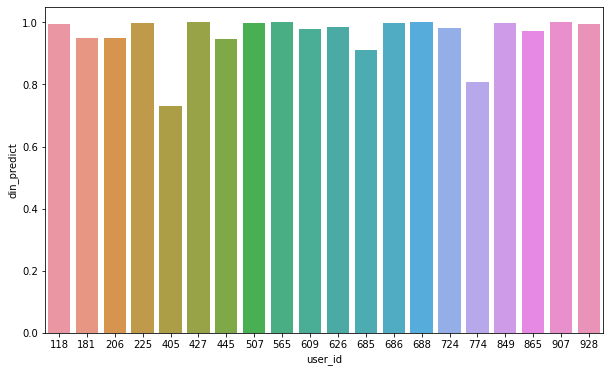

In [1028]:
plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("din_predict").index,get_top_5_mean_recommendation_value("din_predict"))

We could see that DIN recommend 5 movies all with a good recommendation values(probablity the model predict), and as for 405 who already saw most of the movies(736).We could see the top 5 movie mean value is a little bit smaller than others,which show how critical her was for movie, but the model give the mean values stil higher than 0.7. And for 685 which we know that she actually did not see any good movies(rating>3.5), DIN also good to remcommend 5 movies with strong recommendation value(larger than 0.9).

In [1029]:
# pd.DataFrame(din_recommendation["movie_id"].values.reshape(20,-1),index=din_recommendation["user_id"].unique().tolist())

Show the recommendation movie titles by DIN model

In [1030]:
def get_movie_title_data(din_recommendation):
    #get the movie title in correspongder user id
    movie_titles=[]
    for i in range(din_recommendation["movie_id"].shape[0]):
        movieid=din_recommendation["movie_id"].iloc[i]
        movie_titles.append(list(movie_features_data[movie_features_data["movie id"]==movieid]["movie title"])[0])

    index_din=din_recommendation["user_id"].unique().tolist()   
    movie_matrix=[]
    movie_row=[]
    for i in range(len(movie_titles)+1):
        if i % 5==0 and i!=0:
            movie_matrix.append(movie_row)
            movie_row=[]
            if i==len(movie_titles):
                break
        movie_row.append(movie_titles[i])
    din_recommend_movie=pd.DataFrame(movie_matrix,index=din_recommendation["user_id"].unique().tolist(),columns=["movie1","movie2","movie3","movie4","movie5"])
    return din_recommend_movie
get_movie_title_data(din_recommendation)

,movie1,movie2,movie3,movie4,movie5
118,Someone Else's America (1995),"Saint of Fort Washington, The (1993)",Star Kid (1997),Entertaining Angels: The Dorothy Day Story (1996),Marlene Dietrich: Shadow and Light (1996)
181,Someone Else's America (1995),Entertaining Angels: The Dorothy Day Story (1996),Prefontaine (1997),Santa with Muscles (1996),"Saint of Fort Washington, The (1993)"
206,Entertaining Angels: The Dorothy Day Story (1996),Santa with Muscles (1996),"Great Day in Harlem, A (1994)",Marlene Dietrich: Shadow and Light (1996),Star Kid (1997)
225,"Saint of Fort Washington, The (1993)",Someone Else's America (1995),Entertaining Angels: The Dorothy Day Story (1996),Marlene Dietrich: Shadow and Light (1996),Star Kid (1997)
405,Entertaining Angels: The Dorothy Day Story (1996),Santa with Muscles (1996),"Great Day in Harlem, A (1994)",Prefontaine (1997),Someone Else's America (1995)
427,"Saint of Fort Washington, The (1993)",Marlene Dietrich: Shadow and Light (1996),Star Kid (1997),Entertaining Angels: The Dorothy Day Story (1996),Aiqing wansui (1994)
445,"Saint of Fort Washington, The (1993)",Marlene Dietrich: Shadow and Light (1996),Someone Else's America (1995),Entertaining Angels: The Dorothy Day Story (1996),Star Kid (1997)
507,Aiqing wansui (1994),"Saint of Fort Washington, The (1993)",Entertaining Angels: The Dorothy Day Story (1996),Marlene Dietrich: Shadow and Light (1996),Star Kid (1997)
565,Star Kid (1997),"Saint of Fort Washington, The (1993)",Marlene Dietrich: Shadow and Light (1996),Someone Else's America (1995),Entertaining Angels: The Dorothy Day Story (1996)
609,"Great Day in Harlem, A (1994)",Santa with Muscles (1996),Entertaining Angels: The Dorothy Day Story (1996),Marlene Dietrich: Shadow and Light (1996),"Saint of Fort Washington, The (1993)"


### AFM model

In [804]:
# recommendation top 5 movies of every model
## AFM model
afm_recommendation=data_not_see.sort_values(by="afm_predict",ascending=False).groupby("user_id").head(5)
afm_recommendation=afm_recommendation.sort_values(by="user_id")
afm_recommendation.reset_index(drop=True,inplace=True)
afm_recommendation

,user_id,movie_id,userHistoryRatingCount,userHistoryMeanRating,userHistoryStdRating,userLikedTop5_movie_id_1,userLikedTop5_movie_id_2,userLikedTop5_movie_id_3,userLikedTop5_movie_id_4,userLikedTop5_movie_id_5,...,movieGenre3,movieGenre4,movieGenre5,movieGenre6,base_predict,dc_predict,ncf_predict,wad_predict,afm_predict,din_predict
0,118,64,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999980,0.989430,0.998452,0.893358,0.966417,0.981343
1,118,272,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999968,0.984048,0.997961,0.896823,0.947912,0.968387
2,118,1637,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.823787,0.854631,0.931887,0.611305,0.928588,0.303687
3,118,275,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999286,0.971548,0.978919,0.921118,0.929130,0.934543
4,118,484,-0.319065,2.189532,-0.886154,919,164,234,320,288,...,0.0,0.0,0.0,0.0,0.999716,0.974223,0.991964,0.906964,0.931991,0.955835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,928,285,-0.722165,2.452965,-1.721822,127,276,9,1007,246,...,0.0,0.0,0.0,0.0,0.594440,0.938773,0.967045,0.893043,0.957137,0.942556
96,928,528,-0.722165,2.452965,-1.721822,127,276,9,1007,246,...,0.0,0.0,0.0,0.0,0.594440,0.921282,0.866320,0.881814,0.949481,0.964354
97,928,64,-0.722165,2.452965,-1.721822,127,276,9,1007,246,...,0.0,0.0,0.0,0.0,0.897521,0.957116,0.967664,0.899001,0.943387,0.989161
98,928,23,-0.722165,2.452965,-1.721822,127,276,9,1007,246,...,0.0,0.0,0.0,0.0,0.611932,0.905863,0.973706,0.880486,0.935232,0.910925


* **mean probability of these 5 movies predicted by models**

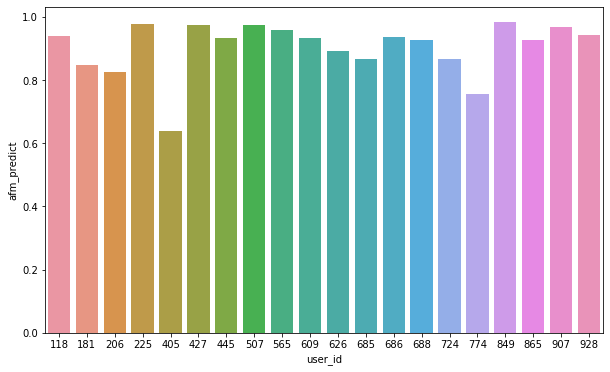

In [805]:
plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("afm_predict").index,get_top_5_mean_recommendation_value("afm_predict"))

Here we could see that the mean value of top 5 movies recommended by AFM is much lower than DIN, and the movie value of user 405 is only around 0.6,other performance are also not very high, then let's see the recommendation of AFM

In [807]:
#get the movie title in correspongder user id
get_movie_title_data(afm_recommendation)

,movie1,movie2,movie3,movie4,movie5
118,"Shawshank Redemption, The (1994)",Good Will Hunting (1997),Girls Town (1996),Sense and Sensibility (1995),"Maltese Falcon, The (1941)"
181,Star Wars (1977),Rear Window (1954),"Silence of the Lambs, The (1991)","Shawshank Redemption, The (1994)","Usual Suspects, The (1995)"
206,Star Wars (1977),One Flew Over the Cuckoo's Nest (1975),Lawrence of Arabia (1962),"Silence of the Lambs, The (1991)","Usual Suspects, The (1995)"
225,One Flew Over the Cuckoo's Nest (1975),Secrets & Lies (1996),Flesh and Bone (1993),Kaspar Hauser (1993),Amadeus (1984)
405,As Good As It Gets (1997),"Close Shave, A (1995)",Cat on a Hot Tin Roof (1958),"African Queen, The (1951)",Titanic (1997)
427,"Day the Earth Stood Still, The (1951)",Primary Colors (1998),Jean de Florette (1986),"Shawshank Redemption, The (1994)",Casablanca (1942)
445,Sunset Blvd. (1950),"Silence of the Lambs, The (1991)","Boot, Das (1981)",GoodFellas (1990),Blade Runner (1982)
507,Midnight in the Garden of Good and Evil (1997),L.A. Confidential (1997),Set It Off (1996),"Truth or Consequences, N.M. (1997)","Sting, The (1973)"
565,Bent (1997),Apocalypse Now (1979),"Shawshank Redemption, The (1994)","Bridge on the River Kwai, The (1957)",Secrets & Lies (1996)
609,My Life as a Dog (Mitt liv som hund) (1985),Lone Star (1996),"Shawshank Redemption, The (1994)",Rear Window (1954),Casablanca (1942)


### Wide & Deep Model

In [1031]:
## WAD model
wad_recommendation=data_not_see.sort_values(by="wad_predict",ascending=False).groupby("user_id").head(5)
wad_recommendation=wad_recommendation.sort_values(by="user_id")
wad_recommendation.reset_index(drop=True,inplace=True)

* **mean probability of these 5 movies predicted by models**

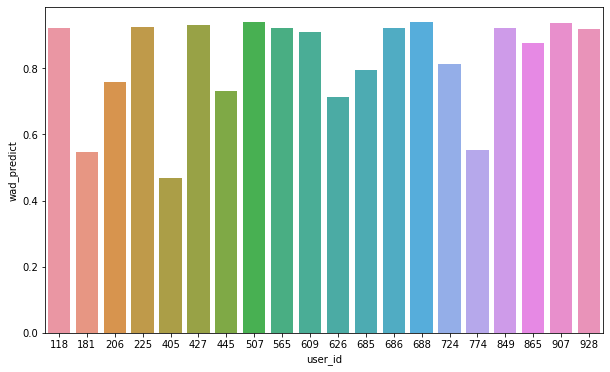

In [1032]:
plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("wad_predict").index,get_top_5_mean_recommendation_value("wad_predict"))

The second most good model is Wide & deep, but in our slef-made data set, it fails to find a good movie for user 405, and the the value of movies in 181 and 774 is also not very good.And other probability is not very high too,which indicates that wide & deep may not stable and will change a lot in different dataset.

In [1033]:
#get the movie title in correspongder user id
get_movie_title_data(wad_recommendation)

,movie1,movie2,movie3,movie4,movie5
118,"Saint of Fort Washington, The (1993)",Marlene Dietrich: Shadow and Light (1996),Aiqing wansui (1994),"Great Day in Harlem, A (1994)","Manchurian Candidate, The (1962)"
181,"Saint of Fort Washington, The (1993)",Entertaining Angels: The Dorothy Day Story (1996),Prefontaine (1997),Marlene Dietrich: Shadow and Light (1996),They Made Me a Criminal (1939)
206,Prefontaine (1997),"Great Day in Harlem, A (1994)",They Made Me a Criminal (1939),"Saint of Fort Washington, The (1993)",Entertaining Angels: The Dorothy Day Story (1996)
225,Someone Else's America (1995),Schindler's List (1993),Aiqing wansui (1994),They Made Me a Criminal (1939),Marlene Dietrich: Shadow and Light (1996)
405,"Great Day in Harlem, A (1994)",Someone Else's America (1995),Aiqing wansui (1994),They Made Me a Criminal (1939),Prefontaine (1997)
427,Marlene Dietrich: Shadow and Light (1996),Star Kid (1997),"Great Day in Harlem, A (1994)","Saint of Fort Washington, The (1993)",Santa with Muscles (1996)
445,Prefontaine (1997),Entertaining Angels: The Dorothy Day Story (1996),Marlene Dietrich: Shadow and Light (1996),They Made Me a Criminal (1939),"Great Day in Harlem, A (1994)"
507,"Great Day in Harlem, A (1994)",Entertaining Angels: The Dorothy Day Story (1996),Prefontaine (1997),Marlene Dietrich: Shadow and Light (1996),Aiqing wansui (1994)
565,12 Angry Men (1957),Marlene Dietrich: Shadow and Light (1996),They Made Me a Criminal (1939),"Butcher Boy, The (1998)","Saint of Fort Washington, The (1993)"
609,Aiqing wansui (1994),"Saint of Fort Washington, The (1993)","Great Day in Harlem, A (1994)",Rear Window (1954),They Made Me a Criminal (1939)


### Nurual CF model

* **mean probability of these 5 movies predicted by models**

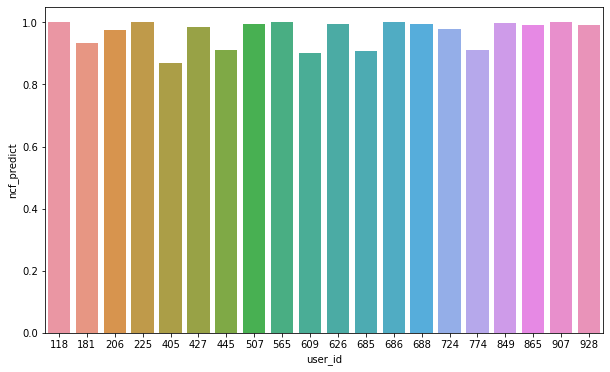

In [1034]:
# Nerual CF
## Nurual CF model
ncf_recommendation=data_not_see.sort_values(by="ncf_predict",ascending=False).groupby("user_id").head(5)
ncf_recommendation=ncf_recommendation.sort_values(by="user_id")
ncf_recommendation.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("ncf_predict").index,get_top_5_mean_recommendation_value("ncf_predict"))

In [1035]:
#get the movie title in correspongder user id
get_movie_title_data(wad_recommendation)

,movie1,movie2,movie3,movie4,movie5
118,"Saint of Fort Washington, The (1993)",Marlene Dietrich: Shadow and Light (1996),Aiqing wansui (1994),"Great Day in Harlem, A (1994)","Manchurian Candidate, The (1962)"
181,"Saint of Fort Washington, The (1993)",Entertaining Angels: The Dorothy Day Story (1996),Prefontaine (1997),Marlene Dietrich: Shadow and Light (1996),They Made Me a Criminal (1939)
206,Prefontaine (1997),"Great Day in Harlem, A (1994)",They Made Me a Criminal (1939),"Saint of Fort Washington, The (1993)",Entertaining Angels: The Dorothy Day Story (1996)
225,Someone Else's America (1995),Schindler's List (1993),Aiqing wansui (1994),They Made Me a Criminal (1939),Marlene Dietrich: Shadow and Light (1996)
405,"Great Day in Harlem, A (1994)",Someone Else's America (1995),Aiqing wansui (1994),They Made Me a Criminal (1939),Prefontaine (1997)
427,Marlene Dietrich: Shadow and Light (1996),Star Kid (1997),"Great Day in Harlem, A (1994)","Saint of Fort Washington, The (1993)",Santa with Muscles (1996)
445,Prefontaine (1997),Entertaining Angels: The Dorothy Day Story (1996),Marlene Dietrich: Shadow and Light (1996),They Made Me a Criminal (1939),"Great Day in Harlem, A (1994)"
507,"Great Day in Harlem, A (1994)",Entertaining Angels: The Dorothy Day Story (1996),Prefontaine (1997),Marlene Dietrich: Shadow and Light (1996),Aiqing wansui (1994)
565,12 Angry Men (1957),Marlene Dietrich: Shadow and Light (1996),They Made Me a Criminal (1939),"Butcher Boy, The (1998)","Saint of Fort Washington, The (1993)"
609,Aiqing wansui (1994),"Saint of Fort Washington, The (1993)","Great Day in Harlem, A (1994)",Rear Window (1954),They Made Me a Criminal (1939)


Nerual CF model in our self_made model can redommend movies well, and it is good for nearly every movies, this is beacuse Nerual CF only consider the movie Id and User id , so it always will find some relationship since there are only two inputs, so it performs good did not mean the result is correct, the two inputs may be eliminate many informations, so the result is not convinced compared to other models

### Deep_crossing

* **mean probability of these 5 movies predicted by models**

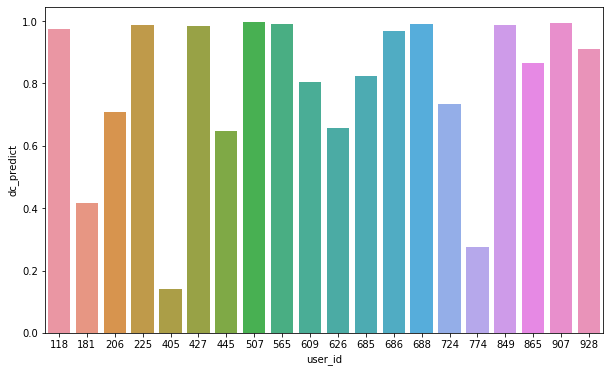

In [1036]:
# Deep_crossing
## deep_crossing model
dc_recommendation=data_not_see.sort_values(by="dc_predict",ascending=False).groupby("user_id").head(5)
dc_recommendation=dc_recommendation.sort_values(by="user_id")
dc_recommendation.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("dc_predict").index,get_top_5_mean_recommendation_value("dc_predict"))

Deep&crossing is just like wide and deep model, it fails to recomment movies for 181,405,774,and other performance are also not very good compared to DIN

### Base_embedding _MLP model

* **mean probability of these 5 movies predicted by models**

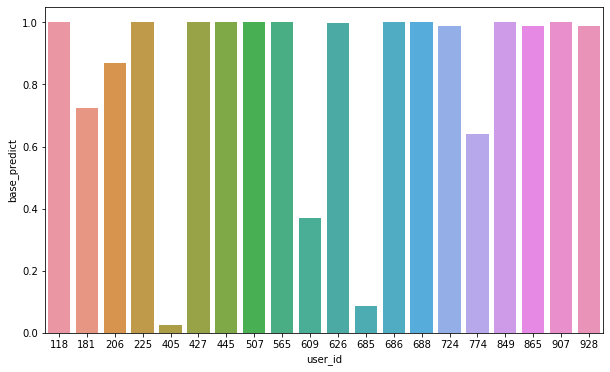

In [1037]:
# Base_MLP
## Base_MLP model
bs_recommendation=data_not_see.sort_values(by="base_predict",ascending=False).groupby("user_id").head(5)
bs_recommendation=bs_recommendation.sort_values(by="user_id")
bs_recommendation.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(get_top_5_mean_recommendation_value("base_predict").index,get_top_5_mean_recommendation_value("base_predict"))

Base model also failed to recommend film to user 405,609,685, movies recommend to 774 is also not very high, but other recommedation values seems good,other values are more close to 1

# Summary

* we first explore our three dataset including rating, user-files and movie-files,**we use NaN value imputation, normalizaiton to get our data**
* 
* the first rating files **only contains 4 columns**: user id ,movie id, rating and timestamp, so we diged the **movie features** like movie aevrage rating, movie standard deviation rating ,released year and etc. We also diged the **user features** based on time, because we don't want to add future behaviours before the timestamp, then we add user average rating, user most liked top 5 movie ids and genres and etc. So we extend our rating files from **only 4 columns to nearly 40 columns**, which contains a lot of information about the dataset.
* 
* after we finished our final dataset, data visualization was carried out, and we first focuesed on the movies,it shows that **"Star War"** is the most popular movie and many people set a rate on it, while **"drama" is the most popular movie genre** that dicrectors like at that time, and most of the movies are shot **after 1992**. Then we focused on the user behaviours, is shows that most of the people are nice and the 4 is most rated by users. **User 405** which is a young lady is the champion to see the most movie, which is 736 out of 1682. However, such experience made her more critical that her mean rating value to all the movie she saw is **only near 1.8**. Further more, we could find out user 849, and user 688 are the most nice persons out of the 943 users, their mean rating is extremely high, they know waht they want to see and watch the good movies they liked. user 181 and user405, are the most critical two persons.
* 
* We implement 6 different models for recommendation systems, they are base embedding models, Deep&crossing model, Nerual Cf model, Wide&Deep model, AFM model and DIN model. some of the model are fine-tuned by changing the hyperparamters. And the result shows that the Rank of model is **DIN>Wide&Deep>Nerual_CF>Deep&Crossing>Base_Embedding_MLP>AFM**. The ROC curve also prove this rank. AUC of DIN is largest and near 78% while the least one which is AFM is only 73.1%, which shows that DIN is very good model in capture the information between users and movies. 
* 
* After all the models are established, we **self-made a dataset** to recommend some user about the movies that she or he did not see before, we choose the top 10 nice persons and the top 10 critical persons to recomend there movies.The dataset is combined by the **user newest behaviours** and movie features. After prediction, the top 5 recommended movies are ouput by each model. It shows that not all the models can successfully find movies for user.Wide& Deep fails to recommend **user 405**,a little failed of **181,774**, Deep&Crossing failed to recommend movie for user **181,405,774**, Base model failed to recommend for user  **405,609,685**. If we check the user id carefully, **all these user ids are in the top 10 critical persons**, their accent for movies are really hard for these models to predict.
* 
* However, three other models **DIN,AFM,nerual CF** is good to recommend all the movies to users, and here it seems that Nerual CF are better than DIN and AMF.However, **Nerual CF only need user id and movie id** as inputs, so actually it can not be very correct to recommend users and there are many information maybe lost, so the recommendation result may be not convinced as much as other two models. Then the performance of AFM is least in test set,and it also only use the categorical features,there are also many informantion lost. In this case, AFM also is not convinced as much as DIN.
* 
* In fact, **We could realize that in all the models with all features as inputes (base_model,Deep_crossing,wide & deep,DIN), only DIN successfully recommend** all the critical users about the movies, it indicates that models are sometimes can not deal with many information about the user and movies and can not find the inner regulation, here **only DIN worked good and seems find the regulation**. So, **DIN is the most convinced model**, since first it contains every information we extracted, second the performance is also the best, third it can recommend critical individuals movies.